# Прогнозирование оттока клиентов сети фитнес-центров

**Автор:**  

Григорьев Павел


**Описание проекта:**   

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Распространённая проблема фитнес-клубов и других сервисов - отток клиентов. Чтобы бороться с оттоком, отдел по работе с клиентами перевёл в электронный вид множество клиентских анкет. Необходимо провести анализ и подготовить план действий по удержанию клиентов.   
А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;

**Цель:**  

Разработать стратегию удержания клиентов сети фитнес-центров на основе анализа данных, включая прогнозирование вероятности оттока, сегментацию клиентов и выявление ключевых факторов, влияющих на отток.

**Источники данных:**  

Данные предоставленны фитнес-центром. 

**Условия проведения анализа данных:**  


**Главные выводы:**  
тут помещаем самое главное из общего вывода, примерно до полустраницы, чтобы не было сильно много и при этом указать все главные выводы
Будет идеально, елси выводы на похожие темы будут рядом, то есть елси мы имеем несколько выводов о доходе, то лушче поместить их рядом

- Женщины чаще возвращают кредит, чем мужчины.
- Долги присутствуют у людей с разным доходом.


**Рекомендации:**

- Добавить контроль данных, чтобы не дублировались значения с разными регистрами в колонке с образованием.
- Добавить уникальный идентификатор клиента, чтобы избежать дублирования строк.


## Загрузка библиотек <skip>

In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import plotly.express as px
import pagri_data_tools  # type: ignore
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

## Описание и изучение данных


### Описание данных


> - children - количество детей в семье
> - days_employed - общий трудовой стаж в днях


### Изучение данных


> сначала грузим 5-10 строк (указываем в `pd.read_csv` `nrow`)


> Изучаем данные и определяемся с типами, потом их указваем в `pd.read`


> Важно привести названия столбцов к нижнему регистру, убрать пробелы (заменить их на \_),  
> так как в том же merge могту быть проблемы, если это не сделать и вообще будет удобнее работать


> Если после попытки привести тип к нужному, мы получили ошибку,  
> то обязательно изучаем эти строки. Именно строки, не только сами занчения, которые не можем преобразовать.  
> Часто бывает у нас в ругих столбцах есть категория например, которая портит все,  
> и при этом это выброс может быть. Поэтому обязательно првоеряем строки, в которых строки не преобразуются в нужный тип.


> Очень важно писать код, чтобы не учитывался порядок столбцов. Чтобы если порядок изменится, то наш скрипт будет работать верно.


> Также важно категориальные столбцы привести к типу `category` и для столбцов, которые имеют малый диапазон значений заменить на меньший тип,  
> например на `int8`


> Делаем названия колонок краткими, но понятными.  
> Если у нас непонятное название типа, dob_years, то меняем его на более понятное, например, age.


#### Изучение переменных


Если таблиц больше 1, то делаем разделы по названию таблиц

##### Таблица users (информация о пользователях)

Загружаем данные и задаем типы данных для столбцов, где это возможно.

In [ ]:
dtype = {'is_apartment': 'category', 'studio': 'category', 'open_plan': 'category'}
df = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv') #, dtype=dtype, nrows = 5
                # , parse_dates=['first_day_exposition'], date_format='%Y-%m-%dT%H:%M:%S')
# df.rename(columns={'cityCenters_nearest': 'city_centers_nearest'}, inplace=True)
df.sample(5, random_state=7)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
4042,1,-2885.142188,50,среднее,1,женат / замужем,0,F,сотрудник,0,80236.028323,приобретение автомобиля
19177,2,-1803.080913,36,Среднее,1,женат / замужем,0,F,сотрудник,0,163292.220004,строительство собственной недвижимости
7372,1,-305.540665,27,СРЕДНЕЕ,1,гражданский брак,1,F,сотрудник,0,69799.488812,ремонт жилью
16245,1,-1593.946336,50,среднее,1,женат / замужем,0,F,сотрудник,1,107486.332934,на покупку подержанного автомобиля
11563,0,-1025.402943,64,высшее,0,женат / замужем,0,M,госслужащий,0,706401.475790,профильное образование


Смотрим типы переменных

In [ ]:
df.dtypes

Если у нас есть столбец, в котором могут быть неявные дубликаты. Нарпимер, разные названия и прочее.  
После изучения столбца сразу убираем эти дубликаты.

Чтобы исключить неявных дубликатов, переведем наименования в нижний регистр и удалить символы ',', '«', '»', '(', ')', '"', ' '.

Нужно проверить, что после нормализации категориальный тип остался прежний


In [ ]:
df.education = pagri_data_tools.normalize_string_series(df.education)
df.education.value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

In [ ]:
df.education.dtype

Если у нас в столбце, который должен быть числоым стоят не числа и мы хотим из заменить на na и сделать столбец числовым, то делаем так

tbd означает "to be determined" - "будет определено позже"  
Так как нам нужен этот столбец в числовом виде, то заменим tbd на na.

In [ ]:
df.user_score.isna().sum()

np.int64(6701)

In [ ]:
(df.user_score == 'tbd').sum()

np.int64(2424)

In [ ]:
df['user_score'] = df['user_score'].replace('tbd', pd.NA)
df['user_score'] = pd.to_numeric(df['user_score'])

In [ ]:
df.user_score.isna().sum()

np.int64(9125)

In [ ]:
(df.user_score == 'tbd').sum()

np.int64(0)

> Сразу меняем название колонок, которые имеют непонятные названия.


In [ ]:
df.columns = [col.lower() for col in df.columns]

In [ ]:
df = df.rename(columns={'dob_years': 'age'})


Создаем верменный файл, в который заносим потенциальные выбросы, чтобы их потом отдельно изучить в разаделе изучения выбросов.  

В этот же файл сразу записываем важные наблюдения, из которых потом выберем наблюдения для промежуточных выводов.  

И в начало файла поместить описание переменных, чтобы не прыгать в начало отчета, так как вряд ли все названия и описание запомняться.  

В наблюдения обязательно записываем то, что будет копироваться в выводы, например наличие пропусков.  
Так как когда будем проходить и собирать наблюдения для выводов, то сами результаты смотреть не будем, поэтому  
важно все важно помещать в наблюдения.

И важно сразу писать наблюдения с привязкой к названию столбца.  
То есть не писать видно 10 процентов пропусков и прочее, а писать что видно 10 процентов пропусков в столбце возраста и так далее.  

ВАЖНО  
чтобы далее было удобно совздавать выводы, сразу стараемся важные выводы писать правильно, чтобы потом не нужно было проходить и их менять.   

- Пока изучаем отдельные столбца просто пишем наблюдения.  
- Далее перед изучением дубликатов копируем в temp.ipynb и делим на наблюдения. выбросы, пропуски, дубли.  
- И далее когда изучаем смотрим на эти записи.  
- Во время изучения пишем просто наблюдения.
- И далее проходим и собираем все наблюдеия от изучения дублей, пропусков и остального. 
- Помещаем во временный файл. 
- Копируем все в промежуточный вывод и также копию оставляем в temp.ipynb.
- И далее при предобработке обращаемся к temp.ipynb.

Схема такая  
- мы пишем наблюдения под таблицей или графиком.  
Пишем только то, что имеет смысл, то есть если выбросов нет, то не нужно это писать.  
- далее мы важные наблюдения копируем в промежуточный вывод и затем копируем в основной вывод.  
- не меняем тест выводов, пока не сделаем ссылки
- далее можно менять текст выводов.  

ВАЖНО   
Когда мы видим таблицу или график, то мы придумываем вопросы к результату.  
Все возможные вопросы прочие вопрсоы)
И отвечая на эти вопросы мы получаем наблюдения и выводы
И чтобы задавать правильные вопросы, мы должны сначала подумать о физике параметров, которые мы видим.
Схема такая  
- строим очередную колонку  
- сначала понимаем физику этого параметра, думаем что с ним связано, что он описывает, какие могут быть у него значения  
- это важно, чтобы посмотреть на данные и сделать правильные выводы  
- например, у нас в колонке количество дней продажи. Мы подумали и поняли, что тут важно длительность продажи, как долго шли продажи и так далее  
- это очень важно, не только просто смотреть как на столбец, а держать в голове его физику и думать какие вопросы ему задать.  
- в анализе самое главное это задавать правильные вопросы данным, а чтобы это сделать, нужно понять природу параметра

Вопросы (важно мы не пишем все наблюдения, а только те, которые могут быть важны для анализа, то есть мы смотрим, задаем вопросы данным и   
и если ответ важен, то мы записываем наблюдения)
- насколько уникальные значения
- какие значения чаще всего встречаются, какие редко, какие не встречаются, какие должны встречаться, но их нет (думаем какие значения могут быть у параметра и смотрим есть ли они в данных)
- сколько дубликатов, нулей, отрицательных занчений, допустимы ли они в этом столбце
- какие максимальные и минимальные значения, реальные ли они, совпадают ли с физикой параметра, каковы причины макс и мин значений
- какой размах значений между макс и мин, какой размах внутри квантилей, в каких квантилях больше размах, а в каких меньше
- сравниваем моду, медиану и среднее и смотрим на гистограмму, какое распределение у нас, какое должно быть у этого параметра
смотрим на пики на гистограмме, почему они появились.
- какая мера центральной тенденции лушче подходит для этого параметра (обязательно записываем это во верменный файл, чтобы далее использовать при анализе)
- смотрим на std большое ли оно, какое оно должно быть у этого параметра
- смотрим на самые частые значения, какие они, какие они должны быть, почему это значение чаще всего встречается, так и должно быть
- смотрим на выбросы, насколько они реально могут быть у данного параметра (если сомневаемся в реальности, то записываем во временный файл для изучения далее)
- как, почему, зачем, сколько, как долго, быстро ли, медленно ли, важно ли это, из-за чего это и 

Используем метод `my_info` или `info_gen` для вывода информации о датасете и колонках


ВАЖНО  
если заметил выброс в колонке, то записываем не только в наблюдения.  
Задача все выбросы записать и вставить в блок где будем обрабатывать выбросы и в блок изучения выбросов.  
Это очень важно, так как потом можно забыть, что в какой-то колонке было некорректное значение.


Задача изучения не только найти аномалии и записать их для выводов.  
Важно срауз думать как мы будем обрабатывать найденные аномалии.  
И выдвигать и проверять гипотезы, и если нашли что-то важно или пришло в головку,  
что поможет обработать, то это записываем во временный файл.  
То есть мы уже начинаем этап обработки в процессе изучения.  

Следим за аномалиями.


Не забываем смотреть на количество мод. Если у нас распределение с 2 и более модами, то это может сигнализировать о проблемах.  
Например, мы так можем определить что у нас часть данных в секунадх, а часть в минутах. Это проявляется в двух разных пиках.


Для категориальных переменных записываем сколько элементов в каждой группе этой категориальной переменной.  
Важное из этого распределения количества внутри групп берем в выводы, и также сохраняем количество элементов,  
чтобы по ходу анализа можно было посмоттреть сколько элементов в определенной группе


Добавить вторую гистограмму рядом с первой.  
На этой гистограмме изображаем данные без выбросов.  
То есть обрезаем по 5 и 95 квантилям.  
Это позволит посмотреть сразу на картину без выбросов.  
Часто гистограмма кажется другой форме, так как сильно много выбросов.  
И получается как бы растянутая.  
Мы выбираем кусок без выбросов и увидем его в увеличенном виде.  

ОЧЕНЬ ВАЖНО  
- в наблюдения пишем обязательно диапазон значений столбца.  
Рынок жилья представлен объектами общей площадью от 12 до 900 кв.м. 
- пишем медианное занчение и по гистограмме и по квантилям определяем оснвоной диапазон.  
В основном это жилье от 30 до 100 кв.м. с пиком в сегменте 30-75 кв.м  
Это все нужно, чтобы потом сформулировать вот такой вывод (в оснвоном выводе отчета), то есть мы для разных столбцов пишем диапазоны,  
основной дипазаон, медианы, моды, а потом уже собираем это в 1 или несколько выводов,  
Например.  
Рынок жилья представлен объектами общей площадью от 12 до 900 кв.м. В основном это жилье от 30 до 100 кв.м. с пиком в сегменте 30-75 кв.м. В жилой площади квартиры преобладает диапазон 15-50 кв.м. Размер площади кухни-от 5 до 15 кв.м., с пиком 9 кв.м. Это стандартные небольшие квартиры эконом-класса. Подавляющее большинство квартир- 1-3 комнатные, с высотой потолка 2,6-2,7 м., но встречаются редкие варианты до 19 комнат и высотой потолка до 20 кв.м. (либо ошибка, либо свободная планировка с возможностью многоуровневости).


**Наблюдения:**  

- В колонке с длительностью звонка 20 процентов нулей.
- Максимальная длительность звонка 38 минут.
- Длительность звонка варьируется от 0 до 38 минут.
- В основном длительность звонка находится в диапазоне от 1.3 до 10.7 минут.
- Чаще всего звонок составляет 0 минут.

ОЧЕНЬ ВАЖНО  
не забываем для каждого столбца смотреть, чтобы значнеия были физически возможны.  
Так как иначе мы пропустим и не изучим эти выбросы.  

Изучим каждый столбец отдельно.

ВАЖНо  
для каждого столбца делаем так
- смотрим на пропуски, дубли, нули, отрицательные значения, записываем если что-то из этого есть
- далее смотрим на максимальное и минимальное значение и думаем эти значения могли быть физически. Если нет, то сразу пишем, что это ошибки.  
- Далее записываем диапазон от мин до макс
- далее записываем основной диапазон от 25 до 75 процентилей
- Далее смотрим на статистики
- Смотрим на гистограмму
- Смотрим на самые часто встречающиеся занчения

ВАЖНО  
Для каждой категориальной переменной изучаем значения на адекватность, особенно всякие рейтинги в виде букв и прочие кодировки.  
Нужно убедиться, что значения правильные и такие существуют. Если есть занчения, которых не должно быть, то отмечаем это.  
Это также является ошибкой и аномалией. Которую потом нужно будет изучить и обработать.  

ОЧЕНЬ ВАЖНО  
Для категориальных переменных смотрим на количество уникальных значений и сколкьо у нас показывается в top n  
Если значений больше, то нуно ниже перед наблюдениями вывести все значения и проверить их на адектватность и реальность таких значений.  
Задача все категориальные переменные проверить на адекватность и реальность.  
И нужно посмотреть на все значения, если это возможно.  

In [ ]:
pagri_data_tools.value_counts_table(df, 'platform', chunk_size = 5, tables_in_row = 10)

Чтобы было удобно, считаем сколько у нас столбцов, копируем next и ячейку наблюдения и вставляем столко раз, сколько у нас колонок

Изучим по отдельности каждый столбец.

In [ ]:
gen = pagri_data_tools.info_gen(df)
gen.next()

Если нужно построить 2 гистограммы (полную и обрезанную по 1 и 99 квантилю)

In [ ]:
gen.next('dual')

**Наблюдения:**  

- В колонке цель кредита пропусков нет


> ВАЖНО  
> Если увидели, что у нас в категориальной переменной одни и те же значения, но записанные с большой и с маленькой буквы, например,  
> или другие проблемы с написанием одно и того же слова, что приводит к увеличению значений в категории.  
> То нужно сразу это убирать, так как дальнейший анализ будет страдать.  
> Для дальнейшего анализа срауз приведем колонку education к нижнему регистру и удалим лишние пробелы


> сделать предположения, почему могло так произойти, выдвигаем гипотезы


> придумать способы проверки выдвинутых гипотез и записать


> если у нас по оси x время, то проанализировать сезонность


> подумать а так и должно было получиться, основываясь на понимании физики параметра


> зафиксировать возможные рекомендации


> Для гистограмм, нужно понять почему именно такое распределение метрики.  
> Совпадет это с логикой этой метрики.


> Также когда строим гистограммы и вайолин плот, то не просто фиксируем, что есть тяжелые хвосты, разброс между квартилями такой-то.  
> А думаем почему так, пытаемся связать это с физикой параметра. Должно быть физическое объяснение всех аномалий.  
> Если объяснения нет, то возможно это инсайт.


> Важно убедиться, что у нас есть данные на все источники, которые заявлены. Например, мы изучаем источники трафика и у нас они в разных таблицах.  
> Нужно убедиться, что во всех таблицах есть все источники, и проверить нет ли аномалий, возможно какой-то сильно выбивается или какого-то вообще где-то нет.


> И очень важно сверить, что периоды в разных таблицах (если у нас больше одной таблицы) совпадают.


> Важно проверить соответствуют ли временной период данных тому, который заявлен в задании,  
> определиться что будем делать с неполными периодами.


> Вообще, когда у нас несколько таблиц и там есть категориальные переменные или время, то  
> мы должны взять уникальные значения категориальных переменных из каждой таблицы (одниаковые переменные) и сравнить.  
> Количество уникальных должно совпадать, иначе нужно разбираться  
> И с верменем как минимум мин и макс даты должны совпадать до дня, а лушше до минуты часа


> Очень важно, если у нас есть стартовая дата чего-то и конечная, то обязательно нужно проверить,  
> нет ли у нас записей, где конечная дата меньше стартовой.


> Важная проверка, если у нас есть категории и даты, то сгруппировать по категориями и
> вывести количество занчений, минимальную и максимальную дату  
> Таким образом мы сразу поймем распределение в категории и  
> увидем какие временные интервалы у каждой категории  
> Если у нас все категории должны быть в один день, то мы поймем нет ли багов


> Вообще очень важно смотреть не только на аномалии в значениях, но и аномалии в категориальных переменных.  
> А тут аномалией будет отстутствие какого-то значения, хотя в описании или поставновке задачи оно есть.  
> Также совпадение количества значений категориальных переменных в разных таблицах.


> Внимательно посмотреть на столбцы, если есть столбцы, в которых могут быть потенциальные анамали, то проверить их.  
> Например, есть столбец возрасти стаж работы, проверить, что возраст больше стажа.  
> И подобные случаи.


> Проверка на нарушения уникальности  
> Убедить, что столбцы, значения в которых не должны повторяться и должны быть уникальными, такие в действительности.  
> Смотрим на результат функции `my_info`


> Проверка на ошибки целостности  
> Если у нас есть столбцы, в которых значения должны совпдаать попарно, то проверяем на это  
> `get_non_matching_rows`


Суть в том, что мы смотрим, чтобы для одного уникального значения в колонке col1 было одно уникальное занчение в колонке col2.

In [ ]:
pagri_data_tools.get_non_matching_rows()

Если нашли такие значения, то смотрим на них

In [ ]:
df[df.name == 'Battlezone']

> Проверка условий  
> Проверьте, что данные в датафрейме удовлетворяют определенным условиям, таким как "возраст > 18" или "страна == 'Россия'"


Проходим и собираем наблюдения и выбросы в файл temp.ipynb

ВАЖНО  
сразу делим на аномалии и наблюдения, чтобы потом не делить

Если у нас несколько датафреймов, то в temp.ipynb записываем отдельно  
список категориальных переменных (с описанием)  
и список числовых переменных (с описанием)  
Чтобы далее можно было из этого списка сверять и изучать, что нужно 

Соберем все датафреймы в словарь для удобства дальнейшей работы.

In [ ]:
dfs = dict(
    users = df_users
    , calls = df_calls
    , messages = df_messages
    , internet = df_internet
    , tariffs = df_tariffs
)

#### Изучение дубликатов


ВАЖНО  
Если у нас есть временная переменная, то нуно посмотреть количество дублей, выбросов, пропусков в столбце во времени.  
Мы так сможем определить есть ли зависимсть от времени

ВАЖНО  
для всех разделов дальше  
Если у нас много таблиц и мы их не можем просто соеденить и посмотреть в разрезе категорий.  
То берем все категориальные перменные и думаем, в разрезе каких их них будет полезно посмотреть   
наши аномалии (дубли, пропуски, выбросы, нули, отрицательные числа).  
И далее объединаям таблицы так, чтобы у нас получился датафрейм в котором столбец с нашей колонкой с аномалиями и столбец с категорией.  
И изучаем. И так по каждой категории.  
Нужно написать автоматизацию для этого.  
Когда мерджим таблицы, то из каждой берем только необходимые поля.  
Прям внутри pd.merge пишем не df, а df[columns], где columns указываем нужные колонки

Пример

In [ ]:
series_zeros_calls = pagri_data_tools.find_columns_with_zeros_values(df_calls)

In [ ]:
series_zeros_internet = pagri_data_tools.find_columns_with_zeros_values(df_internet)

У нас нули в длительности звонков и в объеме интернет-трафика.  
При изучении каждой из этих колонок было замечено, что у них похожие распределения. Это интересно.  
Объеденим эти два датафрейма, чтобы посмотреть у одних и тех же ли пользователей были нули в этих колонках.

In [ ]:
duration_zeros = series_zeros_calls['duration']
mb_used_zeros = series_zeros_internet['mb_used']

In [ ]:
common_users_with_zeros = set(duration_zeros['user_id']).intersection(set(df_internet['user_id']))
len(common_users_with_zeros)

491

Посмотрим в разрезе названия тарифа на нулевые значения

In [ ]:
duration_merged = pd.merge(duration_zeros[['user_id', 'duration']], df_users[['user_id', 'tariff']])

In [ ]:
duration_merged.groupby('tariff', observed=True).size().to_frame('count')

,count
tariff,
smart,25669
ultra,13944


Если у нас несколько датафреймов.  Далее во всех разделах изучения (дубли, пропуски, выбросы, отрицательные значения, нули) смотрим, если у нас для каждой таблицы  
будет много информации, то для каждой таблицы создаем подразделы.  
А если информации мало, то помещаем все в одни раздел как для одного датафрейма.  

Берем из временного файла названия таблиц, помещаем в ячейку и далее идем для каждой таблицы выполняем код  
Если в итоге кода много, то просто вместо ячейки с текстом, делаем ячейку с подразделом (добавляем несколько #)

In [ ]:
df_users Таблица users (информация о пользователях)
df_calls Таблица calls (информация о звонках)
df_messages Таблица messages (информация о сообщениях)
df_internet Таблица internet (информация об интернет-сессиях)
df_tariffs Таблица tariffs (информация о тарифах)

ВАЖНО  
в временный файл записываем наблюдения по дубликатам, выбросам, нулевым, отрицательным значениям и пропусах,  
которые нужны для обработки. Чтобы потом не бегать по отчету.  
Записываем наблюдения, которые нужны для обработки, нарпимер, у нас есть записи с 0 комнат и мы их  
изучили в разрезе площади и увидели что все они скорее всего студии и однокомнатыне.  
Это нужно записать, чтобы в обработке заменить 0 на 1.  

Вообще основная задача этого этапа изучения данных не только обнаружить дубли, аномалии, пропуски,  
но и сформулировать гипотезы, которые помогут нам в обработке.   
Поэтому думаем не только что видим, а думаем сразу как будем обрабатывать и как можно проверить гипотезы.

В дальшейших разделах изучения данных схема такая 
- смотрим каждый столбец 
- изучаем его аномалии по категориям
- в процессе изучения по категориям стараемся определить закономерности, которые помогут обработать аномалии
- для каждого столбца думаем как можно обработать аномалии, какие другие столбцы могут помочь определить закономерности.  
- если определили числовой столбец, который может помочь, то сразу выдвигаем и проверяем гипотезу.  
- и все записываем во временный файл, чтобы потом обрабатывать столбцы

> Не забываем про ИИ.  
> Пишем список столбцов (именно что они значат, то есть образование, пол и прочее), говорим, что есть дубли.  
> И просим предложить причины этих дублей. Если видим важное, то используем для рекомендаций, выводов и замены дублей в предобработке.


> Проверяем на дубли

- Важно помнить, что если у нас есть id и название товара, то названия товара все равно нужно проверить на дубли,
  > возможно у нас 2 ай ди с одним названием.
- Также важно в каждой отдельной колонке проверить дубли и если их много, то посмотреть на соседние колонки, что там происходит
- Дубликаты часто носят скрытый характер.
  > То есть это могут быть поля, которые записаны по разному, но относятся к одному и тому же.  
  > Поэтому важно, если у нас категориальный признак, изучить нет ли повторящихся категорий, которые записаны немного по разному.  
  > Так как это создает шум, мы по сути имеем две разные категории, но на самом деле это одна. Нужно собрать их в одну.
- И очень важно, если мы не подтвердили, что это действительно дубликат (например у нас нет ай ди клиента и мы не смогли выяснить один и тот же ли это человек),
  > то нужно аккуратно удалять их. Но и оставлять много дублей плохо, так как они вносят шумы и искажения.
- Помним, что наличие дубликата не говорит точно, что это дубль, возможно у нас нет ещё колонок, котоыре бы детализировали и разделили эти дубли.
  > Поэтому тут могут быть рекомендации, чтобы добавли в фрейм доп колонки, которые помогут убрать дубли (либо сам ищешь ещё поля)


> Когда смотрим на дубли, то нужно ответить на вопрос так и должно быть, это нормально, что дубли в этих колонках.  
> Например у нас дубли во всех строках таблицы, нам нужно понять это может быть или этого не может быть, и нужно разбираться.  
> Аналогично когда смотрим колонки по 2, 3 и так далее, то самое главное, ответить на вопрос дубли могут быть в этих колонках.  
> Также когда разбиваем по категориям, задаем себе вопрос так могли распреедлеиться дубли.


> `check_duplicated`  
> `check_duplicated_combinations_gen`  
> В первую функцию можно передавать весь датафрейм и можно выбирать нужные столбцы для проверки на дубли и передавать их.


Посмотрим на дубли во всех датафреймах.


In [ ]:
for key, df in dfs.items():
    display(f'{key} - {pagri_data_tools.check_duplicated(df)}')

'users - no duplicates'

'calls - no duplicates'

'messages - no duplicates'

'internet - no duplicates'

'tariffs - no duplicates'

> Если мы нашли колонки в которых дубликатов не должно быть, то нужно изучить эти дубликаты по категориальным переменным в нашем датафрейме  
> `pagri_data_tools.analyze_anomaly_by_category`


In [ ]:
pagri_data_tools.analyze_anomaly_by_category(df, series_zeros, "by_category", "rooms", 'studio')

**Наблюдения:**

- Особых перекосов в сторону определенного значения в категории не наблюдается


> Идем по порядку с помощью next(gen)  
> если в выводе нет ничего интересного, то выше помещаем ячейку с таким содержимым
> %%capture  
> next(gen)  
> снова выполняем next(gen), если снова ничего интересного то, к ячейке выше добавляем next(gen) будет так  
> %%capture  
> next(gen);next(gen)  
> и так далее, пока не появится важная ячейка  
> далее оставляем эту важную ячейку и снова повторяем с первого пункта,  
> в итоге между ячейками с нужным выводом будут ячейки с запрещенным выводом и можно будет прогонять ноутбук весь целиком и выводы будут в нужнфх местах


Посмотрим на дубли во всем датафрейме


In [ ]:
pagri_data_tools.check_duplicated(df)

В датафрейме полных строк дубликатов нет.

Если строк дублей мало, то можно их просто изучить в таблице.

In [ ]:
df[df.duplicated()]

In [ ]:
df[df['name'].isna() | df['genre'].isna()]

In [ ]:
for key, df in dfs.items():
    display(f'{key} - {pagri_data_tools.check_duplicated(df)}')

Посмотрим сколько у нас дублей в каждой колонке


In [ ]:
series_duplicated = pagri_data_tools.find_columns_with_duplicates(df)

In [ ]:
for key, df in dfs.items():
    print(key)
    series_duplicated = pagri_data_tools.find_columns_with_duplicates(df)   

У нас нет столбцов, в которых значения долны быть уникльыми. Поэтом все впорядке.

Посмотрим есть ли дубликаты одновременно в названии игры, жанре и платформе

In [ ]:
pagri_data_tools.check_duplicated(df[['name', 'platform', 'genre']])

Можно посмотреть топ 10 по какой-то переменной и изучить их отдельно   

In [ ]:
duration_zeros.user_id.value_counts().iloc[:10]

Например, у нас нули в длительности звонка, мы можем найти у каких пользователей больше таких звонков и изучить их отдельно  

Если у нас много данных и мы не можем соеденить датафреймы, то мы можем посмотреть сколько одинаковых строк по какой-то переменной.  
Лучше чтобы эта переменная была уникальная, также это можно сделать по нескольким переменным

In [ ]:
duration_zeros = series_missed['duration']
mb_used_zeros = series_missed['mb_used']
common_users_with_zeros = set(duration_zeros['user_id']).intersection(set(df_internet['user_id']))
len(common_users_with_zeros)

> Думаем какие столбцы должны быть уникальными и где дублей не должно быть.  
> И их уже изучаем на дубли.


> Можно посмотреть на строки датафрейма в колонках с дублями  
> Это делаем, если есть время, так как этот шаг редко даст результат, так как на глаз сложно определить закономерности.  
> Суть этого шага посмотреть на строки датафрейма в разных колонках с дублями и выдвинуть гипотезы с закономеностями в этих дублях
> по очереди берем колонки и смотрим на датафреймы (записано рядом, чтобы показать, что не одну колонку только беерем)

In [ ]:
col1_duplicated = series_duplicated['col1']
col2_duplicated = series_duplicated['col2']

In [ ]:
col1_duplicated.head()
col2_duplicated.head()

Важно подумать не только о одиночных столбцах, которые долны иметь уникальные значения.  
Но обязательно подумать какие комбинации столбцов должны быть уникальными.  
Если есть такие комбинации, то фильтруем датафрейм по этим столбцам и используем


In [ ]:
filtered_df = df[['col1', 'col2']]
pagri_data_tools.check_duplicated(filtered_df)

> Если у нас есть столбцы в которых значения должны быть уникальными, то помещаем их в отдельный датафрейим и изучаем дальше.


> когда изучаем по категориям, то смотрим на diff_sum_pct, тут логика такая -  
нам нужно сравнить количество строк с пропусками в каждой категории, учитывая размер этой категории.  
То есть если у нас категории например дорогие квартиры и дешевые (категориальная переменная нарпимер категория стоимости)  
и в них соотношение пропусков 1000 к 500, а общее соотношение групп 700 на 800, то явно отличается количество.  
Поэтому мы смотрим на отличия, и если они существенны, то делаем вывод, что категория влияет на пропуски.  
Иначе пишем, что влияние не обнаружено.  

In [ ]:
gen = pagri_data_tools.check_duplicated_combinations_gen()

Посмотрим на дубли в комбинации колонок с названием игры, жанром и платформой.

In [ ]:
gen = pagri_data_tools.check_duplicated_combinations_gen(df[['name', 'platform', 'genre']], n=3)

In [ ]:
next(gen)

Group by 2 columns


,name,platform,genre
name,,,
platform,3,,
genre,5014,16150,


**Наблюдения:**  

- В паре платформа и название игры всего 3 дубликата
- В парах жанр/название игры и жанр/платформа много дубликатов.

Посмотрим на строки с дублями в названии игры и платформе

In [ ]:
df[df[['name', 'platform']].duplicated(keep=False)].sort_values(by=['name', 'platform'])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,"2,012.00",Sports,2.11,0.22,0.00,0.23,83.00,5.50,E
16230,Madden NFL 13,PS3,"2,012.00",Sports,0.00,0.01,0.00,0.00,83.00,5.50,E
5972,Need for Speed: Most Wanted,PC,"2,005.00",Racing,0.02,0.23,0.00,0.04,82.00,8.50,T
11715,Need for Speed: Most Wanted,PC,"2,012.00",Racing,0.00,0.06,0.00,0.02,82.00,8.50,T
1190,Need for Speed: Most Wanted,X360,"2,012.00",Racing,0.62,0.78,0.01,0.15,83.00,8.50,T
1591,Need for Speed: Most Wanted,X360,"2,005.00",Racing,1.00,0.13,0.02,0.10,83.00,8.50,T


In [ ]:
next(gen)

Group by 3 columns


name | platform | genre,3


Посмотрим на дубликаты одновременно в названии игры, жанре и платформе

In [ ]:
pagri_data_tools.check_duplicated(df[['name', 'platform', 'genre']])

Duplicated is 3 (0.0%) rows


count
name                        platform genre        
madden nfl 13               ps3      sports      2
need for speed: most wanted pc       racing      2
                            x360     racing      2

Посмотрим на строки датафрейма с этими дубликатами

In [ ]:
df[df[['name', 'platform', 'genre']].duplicated(keep=False)].sort_values(by=['name', 'platform', 'genre'])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,"2,012.00",Sports,2.11,0.22,0.00,0.23,83.00,5.50,E
16230,Madden NFL 13,PS3,"2,012.00",Sports,0.00,0.01,0.00,0.00,83.00,5.50,E
5972,Need for Speed: Most Wanted,PC,"2,005.00",Racing,0.02,0.23,0.00,0.04,82.00,8.50,T
11715,Need for Speed: Most Wanted,PC,"2,012.00",Racing,0.00,0.06,0.00,0.02,82.00,8.50,T
1190,Need for Speed: Most Wanted,X360,"2,012.00",Racing,0.62,0.78,0.01,0.15,83.00,8.50,T
1591,Need for Speed: Most Wanted,X360,"2,005.00",Racing,1.00,0.13,0.02,0.10,83.00,8.50,T


**Наблюдения:**  

- У игры Madden NFL 13 все параметры совпадают в дублях, кроме количества проданных копий.  
Возможно часть проданных копий учлась отдельно. 
- В игре Need for Speed: Most Wanted у дублей разные года выпуска, поэтому это не дубли.

> смотрим по категориям

> ВАЖНО - убедиться, что нет в ноутбуке `_gen_` (делаем ctrl+F и вбиваем `_gen_`)  
ставим `_gen_` в том месте где хотим чтобы появились ячейки после работы в prep_dash  

Строчку с созданием gen оставляем без is_dash, это для отчета,  
И ниже пишем строчку с is_dash для создания dash app и потом ее удаляем

Код появится после работы в dash

In [ ]:
_gen_ 

ВАЖНО  
добавить в приложение dash возможность писать код на питоне для работы с текущим датафреймом.  
Это нужно чтобы изучить аномалии. То есть мы запускаем dash app.  
Далее у нас для каждой колонки будут выводиться разбивки по категориям  
Но дополнительно нужно будет проверять разные гипотезы, чтобы потом на основе этого обрабатывать данные.
Для этого нужно иметь возможность выполнять код и видеть результат.  
и чтобы можно было нужный код (который хотим поместить в отчет) сохранить также как next(gen)

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
gen = pagri_data_tools.analyze_by_category_gen(df, series_duplicated, is_dash=True)
pagri_dash.prep_dash(gen, "/colab/pagri-projects/quarto/projects/housing-ads-investigation/housing_ads_investigation.ipynb")

> Важно на дубли проверить и отдельные строки и целиком таблицу и подумать какие группы столбцов могут дать дубли и на это тоже проверить.


> Если в дублях у нас есть ай ди клиента, то тут понятно, если нет ай ди, то пишем рекомендацию, чтобы данные приходили с ай ди,  
> чтобы можно было понять это один человек или нет


> Если у нас id пользователя встречается не одни раз в таблице и есть другие поля которые должны быть всегда одни и те же,  
> напримем пол и прочее, то нужно проверить у всех ли пользователей все значения одинаковые в этом столбце.  
> Это может быть не только ай ди, любое уникальное поле, которое повторяется и для каждого этого поля есть другое  
> поле, которое не должно меняться, нужно проверять а действительно ли это поле не меняется.


#### Изучение пропусков


ВАЖНО  
Если у нас есть временная переменная, то нуно посмотреть количество дублей, выбросов, пропусков в столбце во времени.  
Мы так сможем определить есть ли зависимсть от времени

ВАЖНО  
категориальные переменные с пропусков заменяем на что-то типа другое  
Даже если пропусков много.  
Это важно, так как когда смотрим на колонки с пропуском, то можем забыть, что определенные колонки категориальные,  
и на них не распрастраняется правило, что больше 20 процентов пропусков не трогаем.

Изучим пропуски в каждом столбце.

> Не забываем про ИИ.  
> Пишем название столбца (именно что они значат, то есть образование, пол и прочее), говорим, что есть пропуски.  
> И просим предложить причины этих пропусков. Если видим важное, то используем для рекомендаций, выводов и замены пропусков в предобработке.


> Проверяем на пропуски


> Когда смотрим на пропуски, то нужно ответить на вопрос так и должно быть, это нормально, что пропуски в этих колонках.  
> Когда смотрим на пропуски по категориям, то думаем есть ли закономерность, не случайно ли распределение по категориям


> Когда мы встречаем пропуски, прежде всего, нужно ответить на вопрос, существует ли закономерность в появлении пропусков.  
> Иными словами, не случайно ли их возникновение в наборе данных.  
> Случайно, значит нет закономерности с соседними столбцами, то есть пропуски есть для разных значений.  
> А могут быть неслучайные, то есть существует явная закономерностЬ, что пропуски есть только у сторок с общими занчениями в другом столбце.  
> Чтобы это проверить, нужно взять столбец с пропусками, отфильтровать только пропуски (взять их) и  
> посмотреть как эти пропуски распределены по другой переменной.


- Первое что нужно сделать, когда мы видим пропуск или выброс, это проверить является ли оно случайным.
  > То есть посмотреть не относятся ли все выбросы к одной категории. Если это так, то это уже не случайно и мы нашли аномалию, которую можно изучать.  
  > Если у нас случайны разброс пропусков в категориях, то значит тут есть случайность.  
  > Например, у нас возраст 0, и мы видим, что больше всего это у женщин. Следовательно получаем гипотезу, что женщины не хотят сообщать свой возраст.
- В пропусках мы можем определить какие категории, платформы и прочее не собираются данные. Смотрим пропуски, далее смотрим у каких категорий их больше,
  > и получаем вывод, что нужно обратить внимание на эти категории или системы, почему там пропуски


> `find_columns_with_missing_values`  
> `check_na_in_both_columns`  
> `analyze_by_category_gen`


ВАЖНО  
категориальные переменные с пропускамми более 20 процентов не игнорируем.

Посмотрим на пропуски в каждом столбце

In [ ]:
series_missed = pagri_data_tools.find_columns_with_missing_values(df)

days_employed,2174 (10.10%)
total_income,2174 (10.10%)


In [ ]:
for key, df in dfs.items():
    print(key)
    series_duplicated = pagri_data_tools.find_columns_with_missing_values(df)   

Если в колонке пропусков мало (меньше 10-20 штук), то можно их просто изучить в таблице

Если хотим сразу несколько посмотреть и их мало, то можно использовать побитовый или

In [ ]:
df[df['name'].isna() | df['genre'].isna()]

> Можно посмотреть на строки датафрейма в колонках с пропусками  
> Это делаем, если есть время, так как этот шаг редко даст результат, так как на глаз сложно определить закономерности.  
> Суть этого шага посмотреть на строки датафрейма в разных колонках с пропусками и выдвинуть гипотезы с закономеностями в этих пропусках
> по очереди берем колонки и смотрим на датафреймы (записано рядом, чтобы показать, что не одну колонку только беерем)


In [ ]:
col1_missed = series_missed['col1']
col2_missed = series_missed['col2']
col1_missed.head()
col2_missed.head()

> Думаем какие столбцы связаны, и их лучше изучить вместе на пропуски.  
> Смотрим на количество и процент пропусков в разных колонках и если они равны, то можно выдвинуть гипотезу, что пропуски совпадают
> То есть у нас может появиться гипотеза, что пропуски в нескольких столбцах связаны между собой.  
> Вот мы береме эти столбцы и смотрим сколько прпоусков в обеих колонках вместе, если это совпадает с пропусками в каждой колонке,  
> то гипотеза подтвердилась.


> Пример  
Можно заметить, что количество пропусков в колонке с количеством парков рядом и количеством прудов рядом совпадает.  
Выдвигаем гипотезу, что пропуски в одних и тех же строках в обоих столбцах.  

Если в колонке пропусков мало (меньше 10-20 штук), то можно их просто изучить в таблице

Если хотим сразу несколько посмотреть и их мало, то можно использовать побитовый или

In [ ]:
df[df['name'].isna() | df['genre'].isna()]

Изучим пропуски одновременно в несколкьих колонках.

In [ ]:
gen = pagri_data_tools.check_na_combinations_gen(df[['critic_score', 'user_score', 'rating']])

In [ ]:
next(gen)

Посмотрим на строки датафрейма, где пропуски одновременно в нескольких столбцах

In [ ]:
df_na_in_both_columns = pagri_data_tools.check_na_in_both_columns(df, ['parks_around3000', 'ponds_around3000'])
df_na_in_both_columns.sample(10)

**Наблюдения:**  

- Большинство пропусков в столбцах оценка пользователей и оценка критиков находятся в одних и тех же строках.

Смотрим на строки не только всего датафрейма, но и только на выбранные строки.  

In [ ]:
series_missed['living_area'][['total_area', 'living_area', 'kitchen_area']].sample(10)

**Гипотеза подтвердилась**:
- Пропуски в одних и тех же строках в колонках с количеством парков рядом, количеством прудов рядом совпадает,  
растоянием до центра, растоянием до аэропорта примерно равны  

Посмотрим как распределены пропуски по категориям в строках, где прпоуски одновременно в этих столбцах.  

In [ ]:
gen = pagri_data_tools.analys_filtered_df_by_category(df, df_na_in_both_columns, 'df with na')

Если хотим показать только часть из gen, то подставляем нужные категории в эту функцию  


In [ ]:
pagri_data_tools.analyze_share_by_category(df, df_na_in_both_columns, 'df with na', 'is_apartment')

> Изучаем пропуски по категориям


> ВАЖНО - убедиться, что нет в ноутбуке `_gen_` (делаем ctrl+F и вбиваем `_gen_`)  
ставим `_gen_` в том месте где хотим чтобы появились ячейки после работы в prep_dash  

Строчку с созданием gen оставляем без is_dash, это для отчета,  
И ниже пишем строчку с is_dash для создания dash app и потом ее удаляем

In [ ]:
_gen_ 

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
gen = pagri_data_tools.analyze_by_category_gen(df, series_missed, is_dash=True)
pagri_dash.prep_dash(gen, "/colab/pagri-projects/quarto/projects/housing-ads-investigation/housing_ads_investigation.ipynb")

> когда изучаем по категориям, то смотрим на diff_sum_pct, тут логика такая -  
нам нужно сравнить количество строк с пропусками в каждой категории, учитывая размер этой категории.  
То есть если у нас категории например дорогие квартиры и дешевые (категориальная переменная нарпимер категория стоимости)  
и в них соотношение пропусков 1000 к 500, а общее соотношение групп 700 на 800, то явно отличается количество.  
Поэтому мы смотрим на отличия, и если они существенны, то делаем вывод, что категория влияет на пропуски.  
Иначе пишем, что влияние не обнаружено.  

> Смотрим на все поля  
> in_category_pct говорит о том сколько в этом значении категории изучаемых значений  
> in_column_pct говорит о том сколько процентов изучаемого значения данного значения категории в общем  
> total_count_pct помогает анализировать in_column_pct, так как мы видим сколько занимает это значение в общем


#### Изучение выбросов


ВАЖНО  
Если мы при изучении колонки, обнаружили выбросы (это может быть просто выбивающееся значение), то тут нужно посмотерть на строки датафрейма с этими значениями.  

ВАЖНО  
Выбросы могут быть не очевидны, например, у нас лог заказов и есть пользователи, которые совершили слишком много заказов.  
Крупные заказы мы заметим, но важно тут сгруппировать по id (это может быть пользователь, заках и прочее) и посмотреть аггрегированные занчеия,  
построить boxplot и если есть выделяющиеся id, то их нужно изучить

ВАЖНО  
Если у нас есть временная переменная, то нуно посмотреть количество дублей, выбросов, пропусков в столбце во времени.  
Мы так сможем определить есть ли зависимсть от времени

Изучим выбросы в каждом столбце.

ВАЖНО  
Выбросы могут быть не заметны в общей картине, но в конкретной категории это будет выброс.  
Поэтому по возможности нужно изучить хотя бы макс и мин значения в каждой категории и год мин и макс.  
Например, у нас продажи игр и есть категория платформа.  
Мы видим макс и мин год и вроде все нормально, но если посмотреть на конкретную платформу, то есть игры с датой 1985 год, хотя эта платформа  
появилась позднее.   
Вот такие выбросы могут быть не видны в общей картине. 

ВАЖНО  
Если хотим изучить выбросы по категориям которых ещё нет и они будут дальше или если у нас несколько таблиц и мы хотим изучить  
пропуски в одной таблице в разрезе категориальной переменной из другой таблицы.  
То создаем временную таблицу для этого, объединаям все что нам нужно в одну таблицу,  
создаем нужные категории и изучаем пропуски, выбросы дубликаты.

ВАЖНО   
когда изучаем выбросы, нулевые и отрицательные значения, то нужно сразу проверять гипотезы.  
То есть если у нас нарпимер 0 команат, то мы выдвигаем гипотезу, что это студии и однокомнатыне и если у нас есть площадь или  
другой паарметр по которому мы можем проверить гипотезу, то проверяем.  
Также с другими параметрами.  
Именно тут в изучении данных мы должны выдвигать гипотезы и проверять их.  
И результаты писать в отчет и во верменный файл, чтобы потом в обработке данных использовать эти выводы гиптоез для замены пропусков.  

Не забываем изучать по категориям сильно низкие и сильно высокие знения.  
Например, если у нас цены на квартиры, то нужно посмотреть по категории населенный пункт.  
Так как мы сможем понять в этом населенном пункте могут быть такие занчения или нет.  
Аналогично и не с населенными пунктами.  
Наша задача - определить какая категориальная переменная характеризует переменную с выбросами.  
И посмотреть в ее разрезе, что поможет нам понять, что это за выбросы.

> Не забываем про ИИ.  
> Пишем название столбца (именно что они значат, то есть образование, пол и прочее), говорим, что есть выбросы.  
> Обязательно приводим значения выбросов, самые характерные, чтобы дать ИИ болше информации.
> И просим предложить причины этих выбросов. Если видим важное, то используем для рекомендаций, выводов и замены выбросов в предобработке.


> Когда смотрим на выбросы, то нужно ответить на вопрос так и должно быть, это нормально, что выбросы в этих колонках.


- Выбросы это не только просто сильно большое или сильно маленькое значение.
- Выбросы нужно также смотреть по мультипараметрам, с помощью моделей и искать аномалии.
- Выброс это то, что отделяется от других, что выбивается из общей картины. Следовательно это что-то особенное.
- Тажке выбросы говорят не только о плюсах, но и о минусах. Выбросы могут сказать, что у нас что-то сломалось.
  > Что-то не записывается, или работает с багами. Все это можно увдитеь по выбрасам и аномалиям.
- Обязательно посмотреть выбросы в разрезе категорий, так как мы сможем сделать выводы об их источнике.
- Если мы работаем со строгой отчетностью, то тут любой выброс это уже инсайт и нужно идти разбираться откуда это взялось.


> Если мы во время изучения данных выявили потенциальные выбросы, то нужно их отдельно изучить.  
> Для этого создаем датафрейм с нужными значениями и помещаем его в `Series`,  
> индекс это название колонки, в которой мы изучаем выброс.  
> Далее отдаем этот `Series` в функцию `analyze_by_category_gen`.


> Сначала изучим потенциальные выбросы, которые мы выявили при изучении колонок.  
> У нас в количестве детей есть значение 20.  
> Изучим его подробнее.


> Важно при изучении колонок записывать выбросы отдельно и потом коппировать сюда.  
> А тут нужно изучить эти значения отдельно.


> когда изучаем по категориям, то смотрим на diff_sum_pct, тут логика такая -  
нам нужно сравнить количество строк с пропусками в каждой категории, учитывая размер этой категории.  
То есть если у нас категории например дорогие квартиры и дешевые (категориальная переменная нарпимер категория стоимости)  
и в них соотношение пропусков 1000 к 500, а общее соотношение групп 700 на 800, то явно отличается количество.  
Поэтому мы смотрим на отличия, и если они существенны, то делаем вывод, что категория влияет на пропуски.  
Иначе пишем, что влияние не обнаружено.  

Строчку с созданием gen оставляем без is_dash, это для отчета,  
И ниже пишем строчку с is_dash для создания dash app и потом ее удаляем

> ВАЖНО - убедиться, что нет в ноутбуке `_gen_` (делаем ctrl+F и вбиваем `_gen_`)  
ставим `_gen_` в том месте где хотим чтобы появились ячейки после работы в prep_dash  

Если выбросов мало (меньше 10), то лучше просто показать датафрейм с этими выбросами и написать наблюдения.  

In [ ]:
series_outliers = pd.Series([df[df.children == 20]], index=['children'])

Проверим нет ли у нас выбросов по сумме заказов по пользователям.

Сгруппируем по пользователям и посмотрим топ пользователй по сумме заказа.

In [ ]:
df_orders.groupby('uid')[['revenue']].sum().sort_values('revenue', ascending=False).head(5)

,revenue
uid,
5539673724080479777,"11,810.18"
11149926373378902217,"10,519.46"
17999372575896145244,"1,979.33"
6731421022966725351,"1,450.68"
3644482766749211722,"1,444.29"


**Наблюдения:**  

- 2 пользователя имеют намного болше суммы заказов, чем остальные. Скорее всего это оптовики или перекупы.

Нужно проверить все id (не только пользователей, но и другие, для которых нет категории, то есть где количество уникальных значений большое), чтобы убедиться, что нет сильных выбросов)  
Нужно взять id, сгруппировать по ним и аггрегировать все числовые переменные и убедиться, что нет явно выбросов.

ВАЖНО  
это очень важно, если у нас есть переменная, которая принмает много разных значений и это идентификатор, то мы далее будем аггрегировать данные,  
и не заметим, что какой-то id может выделяться от остальных по какой-то числовой переменной.  
По сути это выброс, который мы пропустим. И он будет нам искажать картинку.  
Поэтому нужно изучить все id по всем числовым переменным, чтобы убедиться, что явных выбросов нет.

таким образом нам нужно изучить выбросы по неаггрегированным данным, чтобы обнаружить слишком большие значения.  
И также нужно изучить выбросы по аггрегированным данным, чтобы обнаружить слишком большие суммарные занчения по категории.

In [ ]:
_gen_ 

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
gen = pagri_data_tools.analyze_by_category_gen(df, series_outliers, is_dash=True)
pagri_dash.prep_dash(gen, "/colab/pagri-projects/quarto/projects/housing-ads-investigation/housing_ads_investigation.ipynb")

> Смотрим на выбросы используя Z-score  
> `detect_outliers_Zscore`


In [ ]:
series_outliers = pagri_data_tools.detect_outliers_Zscore()
# сначала смотрим на значения с большим количеством выбросов
series_outliers['col'].col.value_counts().to_frame('outliers')
# затем уже изучаем определенные датафреймы в series_outliers
series_outliers['col'].head()

Строчку с созданием gen оставляем без is_dash, это для отчета,  
И ниже пишем строчку с is_dash для создания dash app и потом ее удаляем

In [ ]:
_gen_ 

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
gen = pagri_data_tools.analyze_by_category_gen(df, series_outliers, is_dash=True)
pagri_dash.prep_dash(gen, "/colab/pagri-projects/quarto/projects/housing-ads-investigation/housing_ads_investigation.ipynb")

> `detect_outliers_quantile`


Посмотрим на выбросы используя квантили.    
Выбросами будем считать значения, которые выходят за пределы 5 и 95 квантилей.

Определение того, какой процент выбросов за пределами 5-го и 95-го квантилей можно считать "небольшим", может зависеть от контекста и специфики ваших данных. Однако, в общем случае можно использовать следующие ориентиры:

- 0% - 5%: Это обычно считается очень низким уровнем выбросов. Если процент выбросов находится в этом диапазоне, это может указывать на то, что данные достаточно чистые и не содержат значительных аномалий.
- 5% - 10%: Этот диапазон все еще может считаться приемлемым, особенно в некоторых областях, где небольшое количество выбросов является нормальным явлением.
- 10% - 20%: Это может быть признаком того, что в данных есть некоторое количество аномалий, и вам стоит обратить на них внимание. В зависимости от контекста, это может быть допустимо, но требует дальнейшего анализа.
- Более 20%: Это обычно считается высоким уровнем выбросов. Если процент выбросов превышает 20%, это может указывать на наличие значительных аномалий или проблем с данными, и вам следует провести более детальный анализ.

Важно посмотреть насколько одинаковые проценты выбросов в разных столбцах.  
Если процент примерно одинаковый, то это говорит об однородности данных.

In [ ]:
series_outliers = pagri_data_tools.detect_outliers_quantile(df)

**Наблюдения:**  

- Процент выбросов во всех колонках, кроме года выпуска, находится в диапазоне 0-5%. Это может указывать на то, что данные достаточно чистые и не содержат значительных аномалий.
- Процент выбросов во всех колонках примерно одинаковый, что может свидетельствовать об однородности данных.

Посмотрим на выбросы используя квантили.    
Выбросами будем считать значения, которые выходят за пределы 5 и 95 квантилей.

In [ ]:
series_outliers = pagri_data_tools.detect_outliers_quantile(df)

**Наблюдения:**  

- Процент выбросов во всех колонках, кроме года выпуска, находится в диапазоне 0-5%. Это может указывать на то, что данные достаточно чистые и не содержат значительных аномалий.
- Процент выбросов во всех колонках примерно одинаковый, что может свидетельствовать об однородности данных.

Посмотрим от 1 до 99 квантиля

In [ ]:
series_outliers = pagri_data_tools.detect_outliers_quantile(df, lower_quantile=0.01, upper_quantile=0.99)

Посмотрим на распределены выбросы во времени

In [ ]:
config = dict(
    df = outliers_by_month
    , x = 'date'
    , y = 'revenue'  
    , barmode = 'group'
    , orientation = 'v'
    , func = 'sum'
    , xaxis_show = True
    , yaxis_show = True
    , showgrid_x = False
    , showgrid_y = True      
    , sort = True    
    , sort_axis = False    
    , sort_legend = True      
    , width = 1000
    , height = 450                                                                                                                         
)
fig = pagri_data_tools.bar(config)
fig = pagri_data_tools.plotly_default_settings(fig)
fig.update_layout(
    title_text = 'Суммарная стоимость заказа по дням'
    , yaxis_title_text = 'Стоимость заказа'
    , xaxis_title_text = 'Дата'
    , xaxis=dict(
        dtick='D1',  # Интервал в 1 день
        tickformat='%d %b',  # Формат отображения даты
        tickangle=-45,  # Угол наклона меток
        showgrid = False
    )    
)


**Наблюдения:**  

- Боьше всего суммарных выбросов в стоимости заказа было в декабре 2017 года

Строчку с созданием gen оставляем без is_dash, это для отчета,  
И ниже пишем строчку с is_dash для создания dash app и потом ее удаляем

In [ ]:
_gen_ 

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
gen = pagri_data_tools.analyze_by_category_gen(df, series_outliers, is_dash=True)
pagri_dash.prep_dash(gen, "/colab/pagri-projects/quarto/projects/housing-ads-investigation/housing_ads_investigation.ipynb")

> Посмотрим на строки датафрейма с выбросами


In [ ]:
col1_outliers = series_outliers['col1']
col2_outliers = series_outliers['col2']

In [ ]:
col1_outliers.head()
col2_outliers.head()

> Изучить выбросы по категориями  
> `analyze_by_category_gen`


> Смотрим на все поля  
> `in_category_pct` говорит о том сколько в этом значении категории изучаемых значений  
> `in_column_pct` говорит о том сколько процентов изучаемого значения данного значения категории в общем  
> `total_count_pct` помогает анализировать `in_column_pct`, так как мы видим сколько занимает это значение в общем


Строчку с созданием gen оставляем без is_dash, это для отчета,  
И ниже пишем строчку с is_dash для создания dash app и потом ее удаляем

In [ ]:
_gen_ 

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
gen = pagri_data_tools.analyze_by_category_gen(df, series_outliers, is_dash=True)
pagri_dash.prep_dash(gen, "/colab/pagri-projects/quarto/projects/housing-ads-investigation/housing_ads_investigation.ipynb")

Если переменная распределенна нормально, то выбросы можно определить как точки за пределами плюс минус 3 стандартных отклонения.  

Написать функцию для определения выбросов через 3 стандартных отклонения.

Если у нас есть адреса, и мы знаем, что данные из одного города или из определенных, то нужно убедиться, что нет дургих городов

In [ ]:
df[~df.address.str.lower().str.contains("москва")]

Определение выбросов через дендрограмму

Можно либо строить дендограмму по всем данным, либо взять выбросы (до 0.01 квантиля и полсе 0.99 квантиля)

Чтобы определить выбросы через дендограмму, необходимо проанализировать высоту, на которой происходит слияние кластеров. Выбросы обычно будут находиться на значительном расстоянии от остальных кластеров, что проявляется в виде длинных ветвей на дендр ограмме. Вот несколько шагов, которые помогут вам в этом процессе:

In [ ]:
import numpy as np
import pandas as pd
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage

# Пример данных
data = {
    'Feature1': [1.0, 2.0, 1.5, 8.0, 8.5, 9.0],
    'Feature2': [1.0, 1.5, 1.2, 8.0, 8.5, 9.0],
    'Category': ['A', 'A', 'A', 'B', 'B', 'B']  # Категориальный признак
}

df = pd.DataFrame(data)

# Выбор числовых признаков
numerical_data = df[['Feature1', 'Feature2']]

# Стандартизация данных
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)

# Вычисление иерархической структуры для дендограммы
linked = linkage(numerical_data_scaled, method='ward')

# Построение дендограммы с использованием Plotly
fig = ff.create_dendrogram(linked, orientation='bottom')
fig.update_layout(title='Dendrogram for Numerical Features',
                  xaxis_title='Distance',
                  yaxis_title='Observations',
                  width=800,
                  height=600, 
                  )
fig.show()

- Обратите внимание на высоту, на которой происходит слияние кластеров. Если два кластера сливаются на большой высоте, это может указывать на наличие выбросов.
- Выбросы будут представлены как отдельные ветви, которые соединяются с основным деревом на значительном расстоянии.

#### Изучение отрицательных значений


ВАЖНО  
Если у нас есть временная переменная, то нуно посмотреть количество дублей, выбросов, пропусков в столбце во времени.  
Мы так сможем определить есть ли зависимсть от времени

> Не забываем про ИИ.  
> Пишем название столбца (именно что они значат, то есть образование, пол и прочее), говорим, что есть отрицательные значения там где их быть не должно.  
> Обязательно приводим значения, самые характерные, чтобы дать ИИ болше информации.
> И просим предложить причины этих отрицательных значений. Если видим важное, то используем для рекомендаций, выводов и замены отрицательных значений в предобработке.


> Очень важно, если у нас есть столбец, в котором не должно быть отрицательных значений, то нам нужно отдельно изучить положительные и отрицательные значения.  
> И те и те посмотреть по категориям.  
> И на основе этого изучения мы моежм заметить причины отрицательных значений.  
> Например, в колонке стажа у нас очень много отрицательных значений и есть положительные значения.  
> Мы отдельно посмотрели отрицательные значения и они в основном принадлежат работающим людям.  
> А положительные пренадлежат пенсионерам.  
> Важно и полоительные и отрицательные значения посмотреть их макс и мин.  
> Вот мы для стажа посмотрели макси и мин и видим, что отрицательные значения похожи на реальные значения в годах.  
> А вот положительные слишком большие, и далее мы поняли, что это данные в часах.  
> В итоге у нас уже много предположений, которые помогут выяснить откуда появляются странные данные в этом столбце.  
> К тому же мы можем попробовать заменить отрицательные значения, если у нас есть уверенность на основе анализа.


Изучим отрицательные значения в каждом столбце.

In [ ]:
series_negative = pagri_data_tools.find_columns_with_negative_values(df)

> Определяем в каких колонках не должно быть орицательных значений.  
> Колонки в которых допустимы отрицательные значения удаляем из `series_negative`


> Изучим отрицательные значения в разрезе категорий


> Смотрим на все поля  
> in_category_pct говорит о том сколько в этом значении категории изучаемых значений  
> in_column_pct говорит о том сколько процентов изучаемого значения данного значения категории в общем  
> total_count_pct помогает анализировать in_column_pct, так как мы видим сколько занимает это значение в общем


> когда изучаем по категориям, то смотрим на diff_sum_pct, тут логика такая -  
нам нужно сравнить количество строк с пропусками в каждой категории, учитывая размер этой категории.  
То есть если у нас категории например дорогие квартиры и дешевые (категориальная переменная нарпимер категория стоимости)  
и в них соотношение пропусков 1000 к 500, а общее соотношение групп 700 на 800, то явно отличается количество.  
Поэтому мы смотрим на отличия, и если они существенны, то делаем вывод, что категория влияет на пропуски.  
Иначе пишем, что влияние не обнаружено.  

> ВАЖНО - убедиться, что нет в ноутбуке `_gen_` (делаем ctrl+F и вбиваем `_gen_`)  
ставим `_gen_` в том месте где хотим чтобы появились ячейки после работы в prep_dash  

Строчку с созданием gen оставляем без is_dash, это для отчета,  
И ниже пишем строчку с is_dash для создания dash app и потом ее удаляем

In [ ]:
_gen_ 

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
gen = pagri_data_tools.analyze_by_category_gen(df, series_negative, is_dash=True)
pagri_dash.prep_dash(gen, "/colab/pagri-projects/quarto/projects/housing-ads-investigation/housing_ads_investigation.ipynb")

#### Изучение нулевых значений


ВАЖНО  
Если у нас есть временная переменная, то нуно посмотреть количество дублей, выбросов, пропусков в столбце во времени.  
Мы так сможем определить есть ли зависимсть от времени

Помним, что важно выдвигать гипотезы и потом их проверять.   
Например так  
Выдвинем гипотезу, что 0 комнат у студий и однокомнатных.  
Проверим гипотезу по полощади.  

> Не забываем про ИИ.  
> Пишем название столбца (именно что они значат, то есть образование, пол и прочее), говорим, что есть нули там, гед их быть не должно.  
> И просим предложить причины этих нулей. Если видим важное, то используем для рекомендаций, выводов и замены нулей в предобработке.


Изучим нулевые значения в каждом столбце.

In [ ]:
series_zeros = pagri_data_tools.find_columns_with_zeros_values(df)

In [ ]:
df_na_in_both_columns = pagri_data_tools.check_zeros_in_both_columns(df, ['parks_around3000', 'ponds_around3000'])
df_na_in_both_columns.sample(10)

Посмотрим на нули в стоимости заказа

In [ ]:
series_negative.revenue.head()

,order_dt,revenue,uid
1802,2017-06-22 18:19:00,0.00,17030528792926543083
2787,2017-07-07 15:54:00,0.00,10281425020415612933
4783,2017-08-02 14:54:00,0.00,184148767273119549
5095,2017-08-09 14:48:00,0.00,5603453646174104178
5863,2017-08-23 13:43:00,0.00,5603453646174104178


Посмотрим есть ли зависимость от пользователей

In [ ]:
series_negative.revenue.groupby('uid')[['revenue']].count().sort_values('revenue', ascending=False).head(10)

,revenue
uid,
2037345392173160982,12
5603453646174104178,6
8277558335454815700,6
4927261749585088199,4
5570343171257035973,4
2883839899480223178,2
184148767273119549,1
10281425020415612933,1
15254206642996645755,1


**Наблюдения:**  

- У пользователя с id 2037345392173160982 больше всего нулей в стоимости заказа.

> Определяем в каких колонках не должно быть нулевых значений.  
> Колонки в которых допустимы нулевые значения удаляем из `series_negative`


In [ ]:
series_zeros = series_zeros.drop('children')
series_zeros = series_zeros.loc[['rooms', 'airports_nearest']]
series_zeros

dob_years           children  days_employed  dob_years educ...
dtype: object

> Изучим нулевые значения в разрезе категорий


> когда изучаем по категориям, то смотрим на diff_sum_pct, тут логика такая -  
нам нужно сравнить количество строк с пропусками в каждой категории, учитывая размер этой категории.  
То есть если у нас категории например дорогие квартиры и дешевые (категориальная переменная нарпимер категория стоимости)  
и в них соотношение пропусков 1000 к 500, а общее соотношение групп 700 на 800, то явно отличается количество.  
Поэтому мы смотрим на отличия, и если они существенны, то делаем вывод, что категория влияет на пропуски.  
Иначе пишем, что влияние не обнаружено.  

> Смотрим на все поля  
> in_category_pct говорит о том сколько в этом значении категории изучаемых значений  
> in_column_pct говорит о том сколько процентов изучаемого значения данного значения категории в общем  
> total_count_pct помогает анализировать in_column_pct, так как мы видим сколько занимает это значение в общем


> ВАЖНО - убедиться, что нет в ноутбуке `_gen_` (делаем ctrl+F и вбиваем `_gen_`)  
ставим `_gen_` в том месте где хотим чтобы появились ячейки после работы в prep_dash  

Строчку с созданием gen оставляем без is_dash, это для отчета,  
И ниже пишем строчку с is_dash для создания dash app и потом ее удаляем

In [ ]:
_gen_ 

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
gen = pagri_data_tools.analyze_by_category_gen(df, series_zeros, is_dash=True)
pagri_dash.prep_dash(gen, "/colab/pagri-projects/quarto/projects/housing-ads-investigation/housing_ads_investigation.ipynb")

> После изучения данных у нас могут возникнуть вопросы по определенным значениям, это возможно не выбросы,  
> мы просто хотим подробнее их изучить.  
> Для этого создаем датафрейм с нужными значениями и помещаем его в `Series`,  
> индекс это название колонки, в которой мы изучаем выброс.  
> Далее отдаем этот `Series` в функцию `analyze_by_category_gen`.  
> Нужно сделать специальную функцию для этого, чтобы не использовать `analyze_by_category_gen`


In [ ]:
check_series = pd.Series([df[df.col_for_check == value_for_check]], index=['col_for_check'])
gen = pagri_data_tools.analyze_by_category_gen(df, check_series)
next(gen)

> Также мы можем изучить любые столбцы (или часть столбцов) по категориям.  
> То есть мы изучаем как распределены элементы по категориям


In [ ]:
check_series = pd.Series([df[df.col_for_check == value_for_check]], index=['col_for_check'])
gen = pagri_data_tools.analyze_by_category_gen(df, check_series)
next(gen)

> Сделать функцию определения выбросов на основе машинного обучения


> Дополнительные моменты, которые стоит проверить и изучить

- Проверить на сложные выбросы, типа у нас есть статус и возраст и мы видим что студент имеет возраст 60 лет, это реально, но уже подозрительно.
  > Вот таких моментов может быть много, но нужно додуматься, чтобы найти такие комбинации, но это важно делать.
- важно проверить на корректность данные, то есть смотрим по отдельности каждый столбец и изучаем мин, макс, и другие параметры, и
  > думаем, это физически реально. И особенно, когда у нас несколько связаных параметров, нет ли между ними противоречия.  
  > Например, у нас есть дата показа рекламы и есть дата создания рекламы, естественно создание должно быть раньше, это нужно проверить.
- Проверяем данные ошибки
  > Ошибки которые не являются дублями, пропусками или выбросами.  
  > Это сложно сделать, хотя бы заметить явные ошибки
- Проверить на ошибки согласованности
  > Например, у нас пользователь с одним ай ди имеет разные имена.
  > `display(df.groupby('name')['age'].nunique())`
- вообще нужно придумать разные проверки для колонок, особенно связанных. И провести эту проверку.


### Промежуточный вывод


> Из наблюдений собираем важные выводы


Чтобы собрать все наблюдения используем это  
нужно поставить `_pagristart_` где начало и `_pagriend_` где конец

Не забываем удалить метки `_pagristart_` и `_pagriend_` 

In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.collect_observations(notebook_path, '/home/pagri/git_repos/pagri-projects/quarto/projects/prospective_tariff_for_telecom/temp_for_report.ipynb')

Тут помещаем все наблюдения про диапазоны столбцов, основные диапазон и медианы с модами.  
Чтобы в конце скопировать отсюда и составить уже общий вывод.  

> Принимаем решение, как именно мы будем проводить обработку, почему именно так, \*зафиксировать рекомендации.  
> То есть отвечаем на вопрос, что будем делать с выбросами, что будем делать с null.  
> Будет идеально если тут зафиксировать рекомендации


**Промежуточный вывод**

>

- **children** Присутствует 47 отрицательных значений с "-1", а также аномалия в виде 20 детей ...
- **days_employed** Большая часть данных стобца со знаком "-". Однако, эти данные представляют из себя 84% всей выборки. ... будут заменены на .. исходя из определенного критерия, который будет описан далее.
  > - Причины пропущенных значений в столбцах **days_employed** и **income**:
  >   - Во-первых, это может быть из-за неправильной выгрузки данных. Оставим это предположение до того момента, пока не убедимся в неверности других предположений.**Наиболее вероятно**
  >   - Во-вторых, одной из гипотез было предположение об отсутствии трудового опыта у данной части выборки. Однако, если распределение по возрасту в данной группе равномерное по всем возрастам выборки. Также большая доля этой части выборки трудоустроена. **Гипотеза не подтверждена**
  >   - В-третьих, возможно, что эта часть выборки не имеет официального трудоустройства. Данная гипотеза вызывает сомнение в связи с тем, что при наличии достаточно большого стажа работы у представителей выборки у ее представителей нет официального трудового стажа. К тому же 18.9% данной выборки являются госслужащими. **Гипотез не подтверждена**
- **age** .. 0 возраст у 101 человека.
- **education & education_id** Необходимо будет привести данную категорийнуй переменную к общему виду. Избавиться от разного регистра. Но можно не тратить на это время и использовать следующий столбец **education_id**. Это позволит использовать меньше памяти и не повлияет на качество анализа.
- ...


## Предобработка данных


ВАЖНО  
Удалять значения нужно по одной колонке.  
Чтобы контролировать скоько занчений мы должны удалить и сколько удалили.  
Иначе, если мы будем удалять сразу в нескольких полях, то мы не сможем точно убедиться, что не удалили лишние значения.

ВАЖНО  
помним, что когда мы удаляем записи  
`df = df[df.column > 0]`
то удаляются `na`  
поэтому нужно делать так  
`df = df[~(df.column <= 0)]`

Сразу записываем в файл что заменили и что удалили для промежуточного вывода.  

для некоторых пропущенных значений можно предположить логичную замену. Например, если человек не указал число балконов — скорее всего, их нет.   
Такие пропуски правильно заменить на 0. Для других типов данных нет подходящего значения на замену.   
В этом случае правильно оставить эти значения пустыми. Отсутствие значения — тоже важный сигнал, который не нужно прятать;

> Важно, когда удаляем строки, то делаем сброс индекса


In [ ]:
.reset_index(drop=True)

> Не забываем про ИИ  
> Когда мы проводим предобработку данных, то первый вопрос мы себе задать следующий
> Какава вероятнсоть, что это является истиной? Если вероятнсоть ниже 60 прцоентов, то это делать не стоти и может лучше оставить как есть или не трогать этот столбец.  
> Например, у нас дубли или отрицательные значеия и мы выдвинули гипотезу, что это просто неправильный знак и хотим взять модель числа.  
> Но если мы подумаем, а высокая ли вероятность, что число просто с неверным знаком, то вероятнсот этого низкая.  
> Поэтому это делать не нужно.  
> Другое дело у нас датафрейме 1 прцоент полных дублей и при этом у нас есть достаточно точные колонки типа зарплаты с точностью до рублей или стаж в днях.  
> Вот тут мы можем с высокой вероятностью утверждать, что это дубли, так как мало вероятно что будет две записи настолько точно совпадать.  
> Поэтому сначала думаем насколько вероятна та гипотеза, которую мы выдвинули и хотим по ней изменить наши данные.  
> Тут лучше придерживаться правила не навреди.


> Когда удаляем значения из категориальных столбцов pandas, и в этом столбце нет больше таких занчений, которые удалил.  
> То нужно удалить это значение из категории


In [ ]:
df.drop(df[df.gender == 'XNA'].index, inplace=True)
df['gender'] = df['gender'].cat.remove_unused_categories()
df.value_counts(dropna=False)

In [ ]:
df.shape[0]

### Предварительная фильтрация данных


> Если у нас датасет за год, например, и первый или последний месяц неполные, то их лучше выбрасить, если мы будем  
> расчитывать месячные метрики.  
> Но сначала конечно нужно проанализировать столбцы без обрезания, чтобы убедиться, что там нет ничего необычного.


ВАЖЖО  
Посмотреть насколько репрезентативные данные за все периоды.  
Если у нас данные по годам, например, то посмотреть возможно до определенного года данных мало.  
Или картина меняется в какой-то момент (причем это может быть не связано с данными, а просто с изменением разных факторов).
Желательно либо разделить датафрейма на несколько, либо отбросить нерелевантные периоды.  
Так как важно, чтобы во время анализа данные были репрезентативными.

Данные до 90-х годов несущественны для анализа, поскольку занимают ничтожную часть от последующих данных, в дальнейшем мы не будем использовать их для исследования.

Оставим только нужные столбцы для дальнейшего анализа.

Крайне маленький процент игр выпускался в период с 1980 до ~1994. Потому в рамках анализа мы не будем брать этот период для сравнения. Пик выпуска игр приходится на 2007-2011 год.

> Сохраним исходный датафрейм в переменную df_origin, чтобы была возможность вернуться к нему


In [ ]:
df_origin = df.copy()

> Удаляем ненужные столбцы


In [ ]:
df = df.drop(['col1', 'col2'], axis=1)
df.head(1)

- Думаем, какие колонки нам нужны, выбираем только их для дальнейшей работы.
  > Остальные убираем в другой датасет.
- Важно после изученя данных сначала убрать не нужные столбцы, а потом уже заниматься преобразованием (удалением пропусков и выбросов).
  > Думаем прежде чем удалять строки, так как возможно лучше удалить столбец и строки удалять будет не нужно.
- Пишем почему выбираем определенные столбцы


### Обработка выбросов


> Не забываем про нулевые значения и отрицательный.  
> В столбцах, где их быть не должно, они являются выбросами.


> С обработкай нулевых и отрицательных значений нужно быть внимательным.  
> Нужно сначала хорошо подумать, откуда могло это появиться,  
> тут поможет анализ этих значений в предыдущей главе.  
> Думаем откуад появилось отрицательное или нулевое занчение,  
> и если у нас есть гипотезы, которые похожи на правду (мы думаем что вероятность их истины больше 60%),  
> то мы обрабатываем их исходя из гипотезы.  
> Например, -1 часто бывает как отсутсвие чего-то, то есть мы в зависимости от контекста можем заменить его на 0.


> Важно каждый раз, когда мы удаляем что-то из датафрейма, то убедиться, что мы удалили столько строк, сколько и хотели.  
> Для этого выводим размер датафрейма до удаления.  
> Смотрим сколько строк мы хотим удалить.  
> Далее не сохраняя в датафрейм удаляем строки и смотрим верный ли итоговый размер.  
> Если все верно, то удаляем уже с сохранением.


> Не забываем, что выбросы мы также можем заменять на медианные значения.


> Посмотрим где у нас отрицательные значения


In [ ]:
pagri_data_tools.check_negative_value_in_df(df)

In [ ]:
df.shape[0]

21525

In [ ]:
df = df[df.children >= 0]
df.shape[0]

21478

> Посмотрим где у нас нулевые значения


In [ ]:
pagri_data_tools.check_zeros_value_in_df(df)

> Обрабатываем нулевые и отрицательные значения, затем снова проверяем


In [ ]:
pagri_data_tools.check_negative_value_in_df(df)

,negative


In [ ]:
pagri_data_tools.check_zeros_value_in_df(df)

,zeros


> Также нужно обработать выбросы, которые мы обнаружили при изучении данных.  
> Это могут быть любые колонки со значениями, которые не моут быть в реальности.


> Нужно сначала обработать выбросы, а потом уже обрабатываться пропуски.  
> Так как мы заоплняем пропуски, учитывая значения в колонке, которые возможно мы потом удалим.


- Помним про нулевые и отрицательные значения
- Нулевые значения, отрицательные значения являются выбросами, если они не могут быть у этой колонки.
- Очень важно понимать, когда выброс можно отбросить и он реально выброс и когда нельзя.
  > Опираемся на физику параметра, думаем это значение физически возможно.
- Также выброс может казаться выбрасом, но для бизнеса это не выброс.
  > Например у нас суммы покупок и одна покупка сильно выделяется, а там просто человек купил супе дорогой каньяк, например.
- Когда хотим обрезать выбросы, то думаем, какой порог может быть физически реальным и по нему режем, а не просто так берем какой-то перцентиль.
  > Всегда нужно думать с точки зрения физического возможного значения параметра и по нему резать (подумать а какое значение может быть максимально реальным и по нему обрезать)
- Если мы имеем дело со строгой отчестностью, то выбросы убирать нельзя, нужно разобраться откуда они.
- Если мы не можем с увереностью сказать, что это выброс, то нам не стоит его выкидывать, но работать как то нужно с ними,
  > тогда, логарифмируем (лучше использовать натуральный логарифм) эту колонку и работаем с такими значениями (тогда выбросы сожмуться).


> После удаления выбрасов, можно снова выполнить пункт про изучение выбрасов, так как выбросы могут появиться новые,  
> если у нас например выбросы были слишком нереальные значения, когда мы от них избавимся, будет лучше видно другое


### Обработка пропусков


ВАЖНО  
категориальные переменные с пропусков заменяем на что-то типа другое  
Даже если пропусков много.  
Это важно, так как когда смотрим на колонки с пропуском, то можем забыть, что определенные колонки категориальные,  
и на них не распрастраняется правило, что больше 20 процентов пропусков не трогаем.

> Важно помнить, что пропус может быть вызван тем, что во измежании дублирования строк, при созаднии сводной таблицы,  
> занчения не повторяются, а если потом эту таблицу куда то отправить, то там эти пропуски могут стать null  
> Поэтому сначала смотрим последовательно на значения и думаем, не может ли это быть таким случаем.  
> Это могут быть даты, которые идут подряд и меду ними пропуски.  
> Или список названий четко по порядоку и между ними пропуски, это может быть вызвано как раз последствием создания сводной таблицы.  
> В пандас это видно, когда мы группируем строки, у нас в индексе дубли не пишуться, но пандас занчет, что там есть занчения,  
> но после импорта куда-то там могут не продублироваться значения и возникнут пропуски.


> Прежде чем обрабатывать пропуски, нужно подумать а можем ли мы их заменить исходя из имеющихся столбцов.  
> Например, у нас есть столбец с пропусками возраст, и есть стаж,  
> мы можем возраст заменить так стаж + 18 + 5  
> Аналогично другие ситуации нужно сообразить как можно заменить пропуски.  
> И только если нет идей, тогда уже заменяем на медиану, например, по группам.


ВАЖНО  
Если у нас в данных есть временные ряды, то можно использовать заполнение соседними значениями «из прошлого». Когда у вас есть привязка ко времени и один из параметров присутствует в данных с меньшей частотой, чем другие, тогда применяется fillna() с параметром 'method'='ffill'. Здесь мы справедливо предполагаем, что отсутствующие значения стоит заполнять значениями «из прошлого»

In [ ]:
pagri_data_tools.check_missed_value_in_df(df)

In [ ]:
df = df.dropna(subset='name')
df.shape[0]

Заменим прпоуски в категориальных переменных.  

В рейтинге заменим пропуски на значение 'не указано'

In [ ]:
df.rating.value_counts(dropna=False)

In [ ]:
df['rating'] = df['rating'].cat.add_categories(['не указано'])
df['rating'] = df['rating'].fillna('не указано')

In [ ]:
df.rating.value_counts(dropna=False)

> Если решии заменять прпоуски значениями, учитывая категории, то нужно убедиться, что размер этих категорий достаточный.


> Посмотрим размеры групп, если заменять внутри этих групп


In [ ]:
category_columns = ['education', 'family_status', 'gender', 'income_type']
value_column = 'total_income'
pagri_data_tools.check_group_count(df, category_columns, value_column)

> Заполним пропуски в группах от 10 элементов


In [ ]:
df[value_column] = pagri_data_tools.fill_na_with_function_by_categories(df, category_columns, value_column, func='median', minimal_group_size=10)

> Проверим сколько у нас осталось пропусков


In [ ]:
pagri_data_tools.check_missed_value_in_df(df)

> Если пропуски остались, то убираем какую-нибудь категорию и повторяем.


> что-то изменили - > посмотрели не изменилось ли количество дублей  
> `check_duplicated`


In [ ]:
pagri_data_tools.check_duplicated()

> Увидели пропуск — подумайте, нормально ли это. Сколько вообще пропусков может быть в этом столбце?  
> К примеру, в списке с электронными адресами пользователей, согласных на рассылку, будет много пропусков. Далеко не все предоставляют email.


> Можно использвоать такой подход

- если количество пропусков меньше 5 процентов, то удаляем (лучше меньше 1 процента)
- если количество пропусков от 5 до 20 процентов, то подбираем чем заменить, удалять не стоит
- если больше 20 процентов, то не трогаем, так как исказим


> Но оставляя пропуски, нам нужно помнить, что мы не можем по этим полям считать корреляцию с другими,  
> так как пропуски испортят расчет коэффициента корреляции. Аналогично другие метрики могут считаться некорректно.  
> Поэтому, если мы будем считать показатели по столбцу с пропусками, то их нужно либо убирать, либо этот столбец не использовать для расчетов.


> Для категориальных переменных оставлять пропуски нельзя, так как мы скорее всего будем группировать по ним и смотреть разные разрезы.  
> Поэтому в худшем случае, если не можем ничем заменить, и нет уверености, что пропуск можно заполнить пустой строкой (если значения физически нет),  
> то создаем категорию например `other` из пропусков.


> Если у нас пропуски в категориальной переменной и есть разные периоды или просто данные разбиты на части (то есть эта категориальная переменная повторяется),  
> то мы можем взять ещё какую-нибудь переменную, у которой нет пропусков, где пропуски у первой переменной и далее посмотреть другие периоды  
> Таким образом у нас будет предыдущий период, где будет занчение второй переменной и первой и если в нескольких периодах они одинаковые, то мы можем  
> заполнить и пропуски этим значением.  
> Ещё раз схема такая - берем 2 поля одно с пропусками, другое без, получаем новую таблицу, в этой таблице оставляем только униклаьные значения в поле без пропусков,  
> по этому полю будем джойнить. Далее в основнйо таблице дропаем описание и создаем новое описание из таблицы справочника.  
> `fill_missing_values_using_helper_column`


In [ ]:
pagri_data_tools.fill_missing_values_using_helper_column()

> Заполняем пропуски учитвая категории  
> `fill_na_with_function_by_categories`


> Важно следить, чтобы категории, по которым будем заполнять пропуски были обработаны.  
> Если у нас в категориальной переменной есть значение с большой буквы и с маленькой, то это одна категория,  
> но замена будет идити по двум, чтобы такого не было, нужно сначала обработать категориальную переменную.


> Также важно, чтобы в группах по которым мы будем считать значение для заополения было достаточно значений  
> для выбранной функции.  
> Например, если мы решили брать среднее, а в группе у нас 5 значений, то среди них может быть выброс и наше среднее будет некорректно.  
> Лучше в такой ситуации брать группу побольше для этих микрогрупп.  
> В идеале группы должны быть от 30 элементов.


> Можно посмотреть какой процент группах без значений


In [ ]:
temp = df.groupby(['education', 'family_status', 'gender', 'income_type'])['total_income'].sum()
(temp == 0).sum() * 100 / temp.size

In [ ]:
pagri_data_tools.fill_na_with_function_by_categories()

> Сделать функцию заполнения пропусков с помощью машинного обучения


> После удаления пропусков и выбросов желательно проверить какой прцоент строк мы удалили.


### Обработка дубликатов


> Все значения в колонках во всех таблицах нужно привести к нижнему регистру и по возможности к одному языку,  
> для перевода к одному языку можно использовать словарь, с помощью которого изменить неправильный язык  
> Это нужно, чтобы когда будем соединять таблицы, у нас условие соеденения правильно сравнивало равные значения.


> Можно посмотреть снвоа на дубликаты после обработки пропусков.


> `check_duplicated`  
> `find_columns_with_duplicates`  
> `check_duplicated_combinations_gen`  
> `get_duplicates_value_proportion_by_category`  
> В первую функцию можно передавать весь датафрейм и можно выбирать нужные столбцы для проверки на дубли и передавать их.


In [ ]:
pagri_data_tools.check_duplicated()

In [ ]:
pagri_data_tools.check_duplicated_value_in_df(df)

In [ ]:
pagri_data_tools.find_columns_with_duplicates()

> Заполним пропуски в группах от 10 элементов


In [ ]:
df[value_column] = pagri_data_tools.fill_na_with_function_by_categories(df, category_columns, value_column, func='median', minimal_group_size=10)

In [ ]:
pagri_data_tools.check_missed_value_in_df(df)

,missed
total_income,63 (0.3%)


Если у нас есть строки, которые нужно объеденить, то делаем так

Объеденим задублированные строки для игры Madden NFL 13

In [ ]:
df.shape[0]

16443

In [ ]:
df[df[['name', 'platform', 'genre']].duplicated(keep=False)].sort_values(by=['name', 'platform', 'genre'])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,"2,012.00",Sports,2.11,0.22,0.00,0.23,83.00,5.50,E
16230,Madden NFL 13,PS3,"2,012.00",Sports,0.00,0.01,0.00,0.00,83.00,5.50,E
5972,Need for Speed: Most Wanted,PC,"2,005.00",Racing,0.02,0.23,0.00,0.04,82.00,8.50,T
11715,Need for Speed: Most Wanted,PC,"2,012.00",Racing,0.00,0.06,0.00,0.02,82.00,8.50,T
1190,Need for Speed: Most Wanted,X360,"2,012.00",Racing,0.62,0.78,0.01,0.15,83.00,8.50,T
1591,Need for Speed: Most Wanted,X360,"2,005.00",Racing,1.00,0.13,0.02,0.10,83.00,8.50,T


In [ ]:
indices_to_combine = [604, 16230]

# Группируем строки по индексам и объединяем значения
combined_row = df.loc[indices_to_combine].groupby(['name', 'platform', 'genre'], as_index=False, observed=True).agg({
    'na_sales': 'sum',
    'eu_sales': 'sum',
    'other_sales': 'sum',
    'jp_sales': 'sum',
    'critic_score': 'first',
    'user_score': 'first',
    'rating': 'first',
    'year_of_release': 'first'
})

# Обновляем DataFrame, удаляя объединенные строки и добавляя новую
df = pd.concat([df.drop(indices_to_combine), combined_row], ignore_index=True)

In [ ]:
df.shape[0]

16442

In [ ]:
df.tail(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16441,Madden NFL 13,PS3,"2,012.00",Sports,2.11,0.23,0.00,0.23,83.00,5.50,E


Строки правильно объеденились.

> Если есть дубли, и мы считаем, что это не дубли, а просто разделились данные,  
> то объединеняем записи, которые имеют одинаковые значения ключевых признаков.  
> `merge_duplicates`


In [ ]:
pagri_data_tools.merge_duplicates()

> Если мы не уверены, что дубль является дублем и не хотим удалять, то можно использовать  
> маркировку дублей, можно добавить новую колонку, которая будет содержать информацию о том,  
> является ли строка дубликатом или нет.  
> `df['is_duplicate'] = df.duplicated()`


In [ ]:
df['is_duplicate'] = df.duplicated()

> Подумать, а можем ли мы обогатить данные, что разделит дубли.  
> То есть возможно в наших данных нет какого-то столбца, и тогда дубли уже не будут дублями.


> Если уверены, что это дубли, то удаляем их  
> `df.drop_duplicates()`


In [ ]:
df.drop_duplicates()

### Приведение данных к удобной форме


Если у нас есть переменная в которой значения - да, нет.  
То можно заменить значения на более удобные.  

Например, у нас столбец, который указывает является ли точка сетевой.   
Можно заменить значения и далее на графиках можно будет писать - тип точки  
Заменим "да" и "нет" на "сетевая" и "несетевая".  

Изменим значения в столбцах на более удобные


In [ ]:
df.debt = df.debt.apply(lambda x: 'есть' if x == '1' else 'нет').astype('category')

In [ ]:
df.is_apartment.value_counts()

In [ ]:
df.is_apartment = df.is_apartment.astype(str).map({'True': 'да', 'False': 'нет'}).astype('category')
df.is_apartment.value_counts()

ВАЖНО   
смотрим все переменные во всех датафрейма и приводим одинаковые метрики к одной размерности.  
И размерность делаем удобной для дальнейшего анализа.  
На пример, если у нас мегабайты и их больше 1000, то нужно сделать гигабайты (и важно в названии поля добавить _gb)  
Аналогично для всех метрик, суть в том, что если значение в поле больше 1000 и мы можем записать его в другом измерении, то делаем это.    
То же самое с секундами, минутами, часами и так далее.  
Думаем какая точность нам нужна и меняем размерность.  

> Если у нас в столбце, например, стаж данные в днях, то это нужно преобразовать в года.  
> Также если у нас в других столбцах данные в формате, который нужно изменить для лучшего анализа, то делаем это.


> Округлим значения в поле дохода до целого.  
> Целая часть выглядит реальной. А с дробной частью нужно разбираться почему стоько знаков.


ВАЖНО  
Если мы хотим перевесит тип float в int, то нужно проверить нет ли у нас дробных значений.

ВАЖНО  
этот способ na посчитает ка дробные

Убедимся, что в столбце нет дробных чисел.

In [ ]:
(df.critic_score % 1 != 0).sum()

In [ ]:
df.total_income = df.total_income.astype('int32')
df.head(1)

,children,age,education,family_status,gender,income_type,debt,total_income,purpose
0,1,42,высшее,женат / замужем,F,сотрудник,0,253876,покупка жилья


ВАЖНО  
Если у нас есть похожие числовые переменные в разных размерностях, то приводим их к одной размерности, чтобы сравнивать.  
Например оценка пользователей в 10 бальной системе и оценка критиков в 100 бальной системе.

> Посмотрим сколько у нас людей с полом XNA осталось


In [ ]:
(df.gender == 'XNA').sum()

1

> Посмотрим кто это


In [ ]:
df[df.gender == 'XNA']

,children,age,education,family_status,gender,income_type,debt,total_income,purpose
10701,0,24,неоконченное высшее,гражданский брак,XNA,компаньон,0,203905,покупка недвижимости


> Всего 1 человек. И мы не можем идентифицировать его пол.  
> Удалим, чтобы не мешало анализировать графики.


In [ ]:
df.shape[0]

21402

In [ ]:
df.drop(df[df.gender == 'XNA'].index, inplace=True)
df['gender'] = df['gender'].cat.remove_unused_categories()
df.value_counts(dropna=False)

21401

In [ ]:
df.shape[0]

ВАЖНО  
год нужно перевести в категориальный тип  
Но важно сначала перевести в строку, а потом в категориальный тип, иначе plotly будет воспринимать как continuous

Переведем год выпуска в категориальный тип, чтобы анализировать в разрезе года.

Убедимся, что в столбце нет дробных чисел.

In [ ]:
(df.year_of_release % 1 != 0).sum()

np.int64(0)

Чтобы сделать упорядоченную категориальную переменную, нужно делать так

In [ ]:
ordered_years = pd.CategoricalDtype(categories=[str(int(year)) for year in sorted(df['year_of_release'].unique())], ordered=True)

In [ ]:
df.year_of_release = df.year_of_release.astype(int).astype(str).astype(ordered_years)
df.head(1)

,avg_score,critic_score,genre,name,platform,rating,user_score,year_of_release,region,sales,critic_score_cat,user_score_cat,sales_cat
0,78.00,76.00,Sports,Wii Sports,Wii,E,80.00,2006,Северная Америка,41.36,средняя,средняя,много


Если у нас есть названия и в них есть подобные названия, то лучше их привести к одному названию, например, у нас есть сетевые рестораны, которые называются по разному  


In [ ]:
restaurant_mapping = {
    'kfc': 'kfc'
    , 'кфс': 'kfc'
    , 'кфц': 'kfc'
    , 'макдоналдс': 'mcdonalds'
    , 'старбакс': 'starbucks'
    , 'starbucks': 'starbucks'
    , 'шоколадница': 'шоколадница'
    , 'бургер кинг': 'burger king'
    , 'burger king': 'burger king'
    , 'burgerking': 'burger king'
    , 'domino-s': 'dominos pizza'
    , 'dominos pizza': 'dominos pizza'
    , 'домино\'с': 'dominos pizza'
    , 'domino s': 'dominos pizza'
    , 'доминос': 'dominos pizza'
    , 'крошка картошка': 'крошка картошка'
    , 'крошка-картошка': 'крошка картошка'
    , 'теремок': 'теремок'
    , 'милти': 'милти'
    , 'суши wok': 'суши wok'
    , 'папа джонс': 'папа джонс'
    , 'papa johns': 'папа джонс'
    , 'додо пицца': 'додо пицца'
    , 'додо-пицца': 'додо пицца'
    , 'якитория': 'якитория'
    , 'тануки': 'тануки'
    , 'subway': 'subway'
    , 'сабвай': 'subway'
}
def standardize_restaurant_name(name):
    for key in restaurant_mapping:
        if key in name.lower():  # Приводим к нижнему регистру для сравнения
            return restaurant_mapping[key]
    return name  # Если не найдено, возвращаем оригинальное название
df['standartized_name'] = df.name.apply(standardize_restaurant_name).nunique()

### Промежуточный вывод


Чтобы собрать все наблюдения используем это  
нужно поставить `_pagristart_` где начало и `_pagriend_` где конец

Не забываем удалить метки `_pagristart_` и `_pagriend_` 

In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.collect_observations(notebook_path, '/home/pagri/git_repos/pagri-projects/quarto/projects/prospective_tariff_for_telecom/temp_for_report.ipynb')

> пишем как обработали данные, например


- Удалили колонки с id образования и семейного статуса, так как нам для графиков лучше подойдут названия, а не id.
- Колонка со стажем имеет совершенно некорректные данные. Чтобы не внести искажение в анализ, удалим эту колонку.
- Удалили отрицательные значения в колонке с количеством детей, которые составляли 0,2% от общего количества записей в данных.


## Обогащение данных и создание новых переменных

### Обогащение данных из внешних источников

Если нам нужно добавить к нашим данным данные из таблиц из внешних источников, то делаем это здесь.

### Парсинг внешних источников

описываем процесс парсинга  
описываем источники и переменные

### Создание новых числовых переменных

Сначала пишем все имеющиеся колонки ИИ и просим написать какие новые числовые переменные можно создать.  
Если таблиц много, то идем по одной таблице, закончили с одной идем к следующей.  
Далее в конце можно спросить какие новые числовые можно создать, учитывая все таблицы.

Сразу пишем в файл какие новые переменные создали для промежуточного вывода.  

Новые числовые переменные часто это коэффициенты.  
Нужно подумать из каких имеющихся числовых переменных можно создать коэффициенты.  
То есть это отношение одной переменной числовой к другой. Вот нужно подумать какие такие отношения нам могут помочь в анализе.  

Также новая числовая переменная может быть средним из других колонок и другие статистические функции.

Также новые переменные могут быть, например, расчеты, основанные на других переменных, такие как разница, процентное изменение и т.д.

Числовые переменные создаем не только для дальнейшего их анализа.  
Создание числовой переменной может помочь создать новую категориальную переменную.  

Например есть у нас расстояние до центра в метрах.  
Мы создаем новую числовую переменную расстояние в км.  
Далее строим график зависимости расстояния и цены.  
И определеяем где цена резко меняется и получаем границу для создания новой категориальной переменной, в которой будет центр и остальное.  

Создадим переменную соотношение жилой и общей площади

In [ ]:
df['living_total_ratio'] = round(df['living_area'] / df['total_area'],2)

Values,21 796 (92%),,Max,1,,Avg,0.56,,0.56 (4%)
Missing,1 903 (8%),,95%,0.73,,Mode,0.56,,0.55 (4%)
Distinct,91 (<1%),,75%,0.64,,Range,0.98,,0.6 (4%)
Duplicates,23 607 (99.6%),,Median,0.57,,iQR,0.14,,0.62 (4%)
Zeros,---,,25%,0.5,,std,0.11,,0.58 (4%)
Negative,---,,5%,0.39,,kurt,0.23,,0.57 (4%)
RAM (Mb),<1 Mb,,Min,0.02,,skew,-0.14,,0.59 (4%)

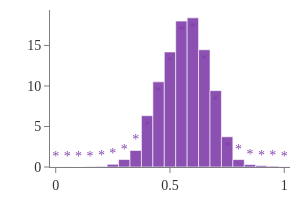

In [ ]:
gen = pagri_data_tools.info_gen(df_internet, column='mb_used_cat', mode='column')
gen.next()

### Категоризация данных


Сначала пишем все имеющиеся колонки ИИ и просим написать какие новые категориальный переменные можно создать.  
Если таблиц много, то идем по одной таблице, закончили с одной идем к следующей.  
Далее в конце можно спросить какие новые категориальные переменные можно создать, учитывая все таблицы.

Категориальная переменная, это то за счет чего мы можем разделить наши данные и установить, что есть влияние этого фактора на целевую переменную.  

ВАЖНО  
категориальные переменные могут быть не только в отдельном столбце.  
Категориальная переменная может быть разбита на разные столбцы.  
Например, оценка пользователей и оценка критиков могут быть в отдельных столбцах.  
Нужно при предобработке это не забыть привести  к категориальному типу, чтобы далее анализировать.  
Смотрим на имеющиеся столбцы в датафрейме и думаем, есть ли у нас категориальная переменная, которая разбита на несколько столбцов.

Категория может быть созадана
- из нескольких столбцов, когда у нас числовая переменная разбита на несколкьо столбцов
- при объединении нескольких таблиц, когда у нас есть несколько таблиц с одинаковыми столбцами
- из числовых перменных можно сделать диапазоны возраста, продаж, цен, размера, объема и т.д.
- из названий чего-либо можно сдлать категории по длинне названия, цвету вывески, количеству гласных. согласных, количеству позитивных, негативных слов и т.д.

ВАЖНО  
Можно создать категориальную переменную относится к топ 5-10 по какой-то числовой переменной или нет.  
То есть у нас будет столбец где будет типа топ и не топ (подумать как лучше называть), столбец називаем топ n по такой-то числовой переменной.  
Например, топ 5 жанров по количеству продаж.  
Тогда у нас у каждой записи будет признак относиться к топу или нет, это нам даст возмонсоть на графиках смотреть вклад топ 5-10 в общую картину.  
Таким образом мы получим новый разрез топ 5-10 

ВАЖНО  
категории можно делать из поведения пользователей и подобное  
У нас есть активность пользователей и есть раздел куда он заходил, это категории.  
Можно сделать просто категории из имеющихся, это правильно.  
Но важно сделать категории типа - открывал пользователь страницу помощи или нет,  
открывал пользователь раздел профиль 5 и более раз, менее 5 и не открывал.  
Тут можно придумать много таких категорий.

ВАЖНО  
Категория может появится после анализа выбросов, нулевых значений и прочих аномалий.  
Например, у нас датасет с данными о покупка и мы определили, что часть пользователей совершает слишком большие покупки, мы можем разбить на группы исходя их этого. 

ВАЖНО  
следим, чтобы не осталось пропусков в категориальной переменной  
все пропуски нужно заменить на что-то типа - не указано

In [ ]:
df.columns.isna()sum()

Если есть пропуски, то добавляем 

In [ ]:
.fillna("не указано").astype('category')

ВАЖНО  
Если у нас много пропусков (болше 20 процентов)  
То можно создать категориальуню переменную (с пропусками / без пропусков) для каждой колонки с пропусками.  
И далее на графиках долей и числовых можно будет анализировать.  
Плюс можно будет создать срезы.  
Бонусом мы получаем возможность изучать данные в разрезе пропусков в числовой переменной, так как na мы заполним на что-то типа - не указано

Если мы при загрузке данных не смогли изменить типы данных из-за пропусков, то теперь меняем типы данных. 

У нас могут быть категориальные переменные не только для изучения данных на графиках под другим углом,  
но категориальные переменные можно использовать для изучения среза данных.  
Таким образом думаем какие срезы в датафрейме дадут нам важную информацию. И создаем категориальную переменную для них.  
Например, у нас в данных есть растояние до центра, мы можем создать новую категориальную переменную и поместить туда катгории растояния до центра.  
И затем изучить отдельные срезы в данных, например квартиры только в центре.  

Думаем какие категориальные переменные сделать для срезов.  

Могут быть операции разность, сумма отношение с другими переменными, которые дадут новую переменную.  
Смотрим на имеющиеся переменные и думаем какие из этих операций можно применить.  

> Важно, когда создали новые переменные, особенно числовые, то нужно их изучить через my_info (взять df только с нужными столбцами)  
Посмотреть на гистограммы и стат параметры.  

> Если у нас есть категориальная переменная, в которйо больше 3 значений, то нужно подумать а не можем ли мы из нее сделать  
> новую категориальную переменную с 2-3 значениями, но тут важно, чтобы это несло смысл. Тут нам может помочь ИИ. И сообразительнсоть. Часто сразу не заментны возможные категории, котоыре несут смысл.  
> Тут исходим из смысла, наша задача созадть перменную, которая добавит нашему исследованию новый смысл, даст как бы новый разрез, и это улучшит  
> качество наших выводов.  
> Например, у нас столбец семейный стату, и там 6-7 статусов, мы можем собрать их в 2 семейный статус и не семейный статус.  
> Тут отлично помогает ИИ. Пишешь ему название переменной, униальные значения в ней,  
> и просишь придумать возможную новую категориальнуюд переменную из 2-3 значений.


> Вообще при категоризации ИИ очень хорошо помогает, он может дать идеи возможных категорий на оснвое имеющихся значений.  
> Поэтому можно все столбцы прогонять через ИИ и смотреть что он предлагает, если есть то , что даст новый разрез нашим данным, то созадем категорийю.


> Важно, когда мы создаем категории, то всегда смотреть value_counts.  
> И делаем так, чтобы в каждой группе было достаточно элементов, хотя бы больше 30, а лучше больше 100.  
> Иначе выводы будут некоректные.  
> В идеале, чтобы количество элементов в каждой группе было от 1000. Лучше изменить диапазон и забрать часть данных от другой категории.


> Важно, когда создаем категориальную переменную, то даем ей тип `category`  
> Чтобы она появилась на графиках (так как идет фильтрация на числовые и категориальные)  
> и чтобы места меньше занимала


> Придумываем какие колонки можно дополнительно сделать из имеющихся.  
> Например у нас есть колонка длительность звонков, и 0 это пропущенный звонок,  
> мы можем сделать колонку is_missed, в которой будет true или false


> Стараемся сделать категориальную колонку с да нет для всех возможных колонок.  
> Например, у нас колонка количество детей и есть 0, 1, 2, 3, 4, 5 мы созадем колнку  
> есть дети или нет. 2 значения  
> Это очень полезно, так как мы можем посмотреть это на графиках и проверить гипотезы  
> стат тестами.


> Смотрим на колонки и думаем можно ли из нее сделать колонку с 2 значениями,  
> например есть и нет что-то


> Очень важно, когда мы создаем новые колонки, в которых используем несколько дургих, то нужно проверить распределение этой новой переменной, особенно выбросы.  
> Например, у нас начальная и конечная дата сессии и мы считаем длительность сессии. Вот тут нужно посмотреть какая минимальная длительность  
> и какая максимальная. Ну и естественно проверить есть ли длительность 0 и меньше нуля.  
> Таким образом мы можем найти инсайты уже после создания новых колонок, хотя в изначальных данных этих инсайдов не было видно.


> Обычная категоризация данных


> Категоризация помогает избежать проблемы с разреженными данными, когда у нас есть слишком много групп с небольшим количеством элементов.  
> Это может привести к некорректным выводам и ошибкам в анализе.
> Категоризация нужна, чтобы образовать группы, в которых достаточно значений для использования статистических методов.  
> И вообще, если в группе 1-10 элементов, например у нас возраст пользователей и 5 человек с возрастом 22, 3 человека с возрастом 23 и так далее.  
> Мы не можем разбивать по таким группам, так как их размер небльшой и выводы будут некорректные, поэтому нам нужно собрать их в группы,  
> чтобы у нас были группы с достаточным размером.


- Если у нас категориальная переменная имеет много значений, то мы не можем номрально с ней работать.
  > Так как мы не можем построить графики по ним, так как их много и они не числовые. Не можем сравнить их все.  
  > Поэтому нам нужно сократить категории.
- Нужно посмотреть на данные и подумать можем ли мы разделить их по сегментам рынка или по другим категориям, которые нам помогут.
- Мы можем категоризировать на основе и числовых и категориальных столбцов. То есть мы можем из категориальной переменной сделать
  > другую категориальную, уменьшив или увеличив разбиение.
- добавление категорий обогощает данные, при чем категории могут формироваться не из одной колонки, а из серии, то есть чтобы попасть
  > в определенную категорию значения столбцов должно быть такое то, а не только один столбец определяет категорию.
- категории могут быть да нет, то есть состоять из двух значений, например, у нас есть данные о рекламе и столбец где она показвалась,
  > и у нас много много разных устройств. Мы можем разбить на да нет, то есть показвалась реклама по телеку или нет


> Мы можем разбить данные на категории двумя способами

- разбивать на равные части
  > подходит, когда
  >
  > - диапазон значений является равномерным и имеет линейную структуру
  > - мы понимаем на какие интервалы хотим разбить данные
  > - мы хотим разделить диапазон значений на равные части для удобства анализа.
- разбить на основе квантилей
  > подходит, если
  >
  > - диапазон значений имеет неравномерную структуру
  > - мы не можем понять какие интервалы выбрать
  > - хотим выделить группы с конкретными характеристиками (например, группы с низким доходом, средним доходом и высоким доходом)


> Выбираем нужные способ и используем  
> `create_category_column`


> Чтобы посмотреть распределение по квантилям используем `pagri_data_tools.quantiles_columns()`


Не забываем новые каеториальные переменные делать `.astype('category')`

In [ ]:
.astype('category')

ВАЖНО  
создали новую переменную, сразу же изучили ее использу `info_gen`  
задаем вопросы и пишем важные наблюдения  

In [ ]:
gen = pagri_data_tools.info_gen(df_internet, column='mb_used_cat', mode='column')
gen.next()

In [ ]:
df['floor_cat'] = df.apply(lambda x: 'первый' if x['floor'] == 1 else 'последний' if x['floor'] == x['floors_total'] else 'другой', axis=1)

In [ ]:
df_visits['is_new_user'] = df_visits['is_new_user'].map({True: 'да', False: 'нет'})

Посмотрим на квантили в столбце.

In [ ]:
pagri_data_tools.quantiles_columns(df.sales, list(np.arange(0, 1, 0.05)))

Можно так разделить на группы, если других идей нет  
- Дешевые: Заказы ниже Q1.  
- Средние: Заказы между Q1 и Q3.  
- Дорогие: Заказы выше Q3.  

Для определения границ используем квантили Q1, Q2 и Q3.

In [ ]:
pagri_data_tools.create_category_column()

> Сделаем следующие группы

- до 30 лет
- от 30 до 40 лет
- от 40 до 50 лет
- от 50 до 60 лет
- старше 60 лет


In [ ]:
labels = ['до 30', '30-40', '40-50', '50-60', 'старше 60']
bins = [-np.inf, 30, 40, 50, 60, np.inf]

Если нужно пропуски заменить, то добавляем параметр `fillnavalue='не укаазано'`

In [ ]:
df['age_cat'] = pagri_data_tools.create_category_column(df.age, labels=labels, bins=bins)
df['age_cat'].value_counts(dropna=False)

30-40        5704
40-50        5241
50-60        4520
до 30        3804
старше 60    2132
Name: age_cat, dtype: int64

Если у нас в таблице числовая переменная разбита на несколько столбцов, то лучше ее объеденить в одни столлбец.

Объеденим продажи в одну числовую переменную и создадим категориальную переменную region

In [ ]:
# Применяем melt для преобразования данных
value_vars = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
melted_df = pd.melt(df, id_vars=df.columns.difference(value_vars), 
                    value_vars=value_vars,
                    var_name='region', value_name='sales')
# Словарь для замены значений
region_mapping = {
    'na_sales': 'Северная Америка',
    'eu_sales': 'Европа',
    'jp_sales': 'Япония',
    'other_sales': 'Другие'
}

# Замена значений в столбце region
melted_df['region'] = melted_df['region'].replace(region_mapping).astype('category')
melted_df

,critic_score,genre,name,platform,rating,user_score,year_of_release,region,sales
0,76.00,Sports,Wii Sports,Wii,E,80.00,2006,Северная Америка,41.36
1,NaN,Platform,Super Mario Bros.,NES,не указано,NaN,1985,Северная Америка,29.08
2,82.00,Racing,Mario Kart Wii,Wii,E,83.00,2008,Северная Америка,15.68
3,80.00,Sports,Wii Sports Resort,Wii,E,80.00,2009,Северная Америка,15.61
4,NaN,Role-Playing,Pokemon Red/Pokemon Blue,GB,не указано,NaN,1996,Северная Америка,11.27
...,...,...,...,...,...,...,...,...,...
65763,NaN,Sports,LMA Manager 2007,X360,не указано,NaN,2006,Другие,0.00
65764,NaN,Adventure,Haitaka no Psychedelica,PSV,не указано,NaN,2016,Другие,0.00
65765,NaN,Platform,Spirits & Spells,GBA,не указано,NaN,2003,Другие,0.00
65766,NaN,Simulation,Winning Post 8 2016,PSV,не указано,NaN,2016,Другие,0.00


Если у нас есть названия, то из них можно создать новые категории, извлекая определенные слова

Выделим название улицы из адреса

In [ ]:
df['street'] = df.address.str.split(',').str[1]

Нужно убедиться, что на первом месте всегда город, иначе нужно думать как извлечь улицу

Нужно исходить из задачи. Если извлечь сложно, но нам нужно будет построить только топ улиц, то можно пренебречь этим.  
И извлечь просто сплитом.

In [ ]:
filtered_address = df[~df.address.str.lower().str.contains("москва")].address
cities = filtered_address[filtered_address.str.contains('поселение')].unique().tolist()
cities += filtered_address[filtered_address.str.contains('город')].unique().tolist()
cities = [city.split(',')[0].lower() for city in cities]
cities = set(cities+['москва', 'город москва', 'город москва, поселение'])
cities

In [ ]:
def extract_street(address):
    # Проверяем наличие города в адресе
    for city in cities:
        if city in address.lower():
            # Если город найден, разбиваем строку по запятой и берем второй элемент
            parts = address.split(',')
            if len(parts) > 1:
                return parts[1].strip()  # Возвращаем название улицы
    # Если город не найден, берем первый элемент
    return address.split(',')[0].strip()

# Применяем функцию к столбцу адресов
df['street'] = df['address'].apply(extract_street)

Так как в адресе после города может стоять поселение или город, то у нас часть улиц будет содержать название города или поселения.  
Но нам для анализа потребуются только улицы, на которых много заведений. Поэтому эти строки нам не помешают, так как в городах спутниках и в поселениях будет меньше заведений, чем в москве.  
Важно было выделить улицы, в которых на первом месте не стоит город и сразу идет улица. Такие мы извлекли.

Так как в адресе после города может стоять поселение или город, то у нас часть улиц будет содержать название города или поселения.  
Но нам для анализа потребуются только улицы, на которых много заведений. Поэтому эти строки нам не помешают, так как в городах спутниках и в поселениях будет меньше заведений, чем в москве.  
Важно было выделить улицы, в которых на первом месте не стоит город и сразу идет улица. Такие мы извлекли.

Создадим категориальную переменную, которая будет показывать круглосуточный ли объект. Для этого используем название объекта.  
Если в его названии есть слова "круглосуточный", "24 часа", "ежедневно"

Добавление дополнительных столбцов к основной таблице

In [ ]:

# Добавим столбец с названием улиц
places['street']=places['address'].str.split(',').str[1]

# Добавим столбец с режимом работы
places['is_24_7']=places['hours'].str.contains('ежедневно','круглосуточно')

places['is_24_7'].mean()

places['hours'].str.contains('ежедневно, круглосуточно').mean()

# Для удобства заменим числовые значения в столбце chain на понятную запись
places['chain']=places['chain'].replace({1:'Сетевое', 0:'Несетевое'})

# Для удобства построения графиков дадим сокращенное название округов
places['district_short']=places['district'].replace({'Северный административный округ':'САО', \
                                               "Северо-Восточный административный округ":"СВАО",\
                                              "Северо-Западный административный округ":"СЗАО",\
                                              "Западный административный округ":"ЗАО",\
                                              "Центральный административный округ":"ЦАО",\
                                              "Восточный административный округ":"ВАО",\
                                              "Юго-Восточный административный округ":"ЮВАО",\
                                              "Южный административный округ":"ЮАО",\
                                              "Юго-Западный административный округ":"ЮЗАО"})



Создаем новые переменные из времени

ВАЖНО  
если у нас год уже есть в таблице и он числовой,  
то переводим его в категориальный тип   
Но важно сначала перевести в строку, а потом в категориальный тип, иначе plotly будет воспринимать как continuous

In [ ]:
gen = pagri_data_tools.info_gen(df_internet, column='mb_used_cat', mode='column')
gen.next()

In [ ]:
weekday_dict = {
    'Monday': 'Понедельник',
    'Tuesday': 'Вторник',
    'Wednesday': 'Среда',
    'Thursday': 'Четверг',
    'Friday': 'Пятница',
    'Saturday': 'Суббота',
    'Sunday': 'Воскресенье'
}
month_dict = {
    1: 'Январь',
    2: 'Февраль',
    3: 'Март',
    4: 'Апрель',
    5: 'Май',
    6: 'Июнь',
    7: 'Июль',
    8: 'Август',
    9: 'Сентябрь',
    10: 'Октябрь',
    11: 'Ноябрь',
    12: 'Декабрь'
}

In [ ]:
df['publication_weekday'] = df['first_day_exposition'].dt.day_name().map(weekday_dict).astype('category')
df['publication_month'] = df['first_day_exposition'].dt.month.map(month_dict).astype('category')
df['publication_year'] = df['first_day_exposition'].dt.year.astype(str).astype('category')
# Задаем порядок для weekdays
weekday_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
df['publication_weekday'] = df['publication_weekday'].cat.reorder_categories(weekday_order, ordered=True)

# Задаем порядок для months
month_order = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
df['publication_month'] = df['publication_month'].cat.reorder_categories(month_order, ordered=True)


In [ ]:
df.columns.isna()sum()

In [ ]:
gen = pagri_data_tools.info_gen(df_internet, column='mb_used_cat', mode='column')
gen.next()

Для даты заказа создадим новую категориальную переменную в формате месяц год.

In [ ]:
# Словарь для замены месяцев
months_translation = {
    'Jan': 'Янв',
    'Feb': 'Фев',
    'Mar': 'Мар',
    'Apr': 'Апр',
    'May': 'Май',
    'Jun': 'Июн',
    'Jul': 'Июл',
    'Aug': 'Авг',
    'Sep': 'Сен',
    'Oct': 'Окт',
    'Nov': 'Ноя',
    'Dec': 'Дек'
}
# Получаем отдельно месяц и год
months = df['first_day_exposition'].dt.strftime('%b').astype('category').cat.reorder_categories(list(months_translation.keys()), ordered=True)
years = df['first_day_exposition'].dt.strftime('%y')
months_years = pd.concat([months, years], axis=1)
months_years.columns = ['month', 'year']
# Создаем список уникальных (год, месяц) и сортируем
unique_months = months_years.drop_duplicates().sort_values(by=['year', 'month'])

# Создаем список для порядка
month_year_order = []

# Формируем month_year_order на основе уникальных (год, месяц)
for _, row in unique_months.iterrows():
    year = row['year']
    month = row['month']
    month_year_order.append(f"{months_translation[month]}'{str(year)[-2:]}")

# Заменяем месяцы и соединяем с годом
df['publication_month_year'] = months.astype(str).map(months_translation) + "'" + years
df['publication_month_year'] = df['publication_month_year'].astype('category')
df['publication_month_year'] = df['publication_month_year'].cat.reorder_categories(month_year_order, ordered=True)
df['publication_month_year']

In [ ]:
df.columns.isna()sum()

In [ ]:
gen = pagri_data_tools.info_gen(df_internet, column='mb_used_cat', mode='column')
gen.next()

Для верменных переменных нужно делать не только отедльно месяц, год.  
Но и делать категориальную переменную обрезая время.  
То есть мы созадем переменную   
Янв'23

Но нужно подумать, нужна ли нам будет именно временная переменная, или достаточно категории,  
если будет нужна временная, то создаем обрезанную переменную datetime используя .dt.round()

Если нужно перевести в категорильный упорядоченный тип

In [ ]:
cohort_lifetime_order = list(map(str, range(100)))[:df_cohort['cohort_lifetime'].nunique()]
df_cohort['cohort_lifetime'] = df_cohort['cohort_lifetime'].astype(str).astype('category').cat.reorder_categories(cohort_lifetime_order, ordered=True)

> Категоризация с использованием лемматизации

> Если у нас есть столбец и мы хотим его лематизировать, то используем функцию  
> `lemmatize_column`


> Чтобы создать лемы для словаря категоризации, можно посмотреть имеющиеся предложения и использовать
>
> ```
> m = Mystem()
> m.lemmatize('образованием')
> ```


In [ ]:
m = Mystem()
m.lemmatize('образованием')

In [ ]:
pagri_data_tools.lemmatize_column()

In [ ]:
categorization_dict = {
    'недвижимость': ['жилье', 'недвижимость']
    , 'образование': ['образование']
    , 'автомобиль': ['автомобиль', 'машина']
    , 'свадьба': ['свадьба'] 
}

In [ ]:
df['purpose_new'] = pagri_data_tools.categorize_column_by_lemmatize(df.purpose, categorization_dict, use_cache=True)
df['purpose_new'].value_counts(dropna=False)

недвижимость    10779
автомобиль       4288
образование      3997
свадьба          2337
Name: purpose_new, dtype: int64

> Если нужно, уддалим старую колонку


In [ ]:
df = df.drop('purpose', axis=1).rename(columns={'purpose_new': 'purpose'})
df.head(1)

,children,dob_years,education,family_status,gender,income_type,debt,total_income,purpose,dob_cat,total_income_cat
0,1,42,высшее,женат / замужем,F,сотрудник,0,253876,Недвижимость,40-50,200-500 тыс


> С помощью лематизации мы можем сократить количество категорий.


> Например мы можем выделить группы:

- операции с автомобилем (ключевое слово - автомобиль)
- операции с недвижимостью (ключевые слова: жилье, недвижимость)
- проведение свадьбы (ключевое слово: свадьба)
- получение образования (ключевое слово: образование)


> Используем функцию  
> `categorize_column_by_lemmatize`


In [ ]:
pagri_data_tools.categorize_column_by_lemmatize()

Из времени также можно сделать категориальный переменные, например, создать переменную для времени заправки, если больше 1 минуты, то долгая заправка, иначе короткая и так далее.


ВАЖНО подумать какие переменные мы можем создать не только категориальные, но и числовые и временные.  
Например, обрезание времени, чтобы получить дату по часам и прочее,


> Если мы хотим преобразовать категории в числа, то мы можем использовать

- lable encoding
  > Заменяем быквы числами. Хорошо работает, когда у нас порядковые категориальные переменные.  
  > Не забываем про порядок, если у нас алфавитный порядок наших категорий соотвествует числовому, то ок,  
  > если нет, то нам нужно самим определить порядок чисел, чтобы они соответствовали категориям в нужном порядке.
- one hot encoding
  > Если у нас категориальная переменная не упорядочиваемая, то лучше использовать one hot encoding, чтобы разница между числами не вносила шум,  
  > так как черный и белый и красный цвет закодированные 1, 2, 3 вносят смысл количества, но они не имеют этого свойства.
- target encoding
  > замена категориальной переменной на каую-то статистику по одной из категорий внутри этой переменной.  
  > Например у нас категориальная переменная это наличие задержки. Значение задержан / незадержан. Мы кодируем их как 0 и 1. Далее мы берем и считаем по каждой группе (для задержан и для незадержан)  
  > статистику, например, среднее и получаем столбец, где вместо каждой буквы будет ее среднее.  
  > Тут важно делать регуляризацию. Так как маленькие группы могут иметь сильно зашумленные статистики, так как если у нас  
  > группа из 5 значений, то среди них может быть легко экстремальное одно и оно сбивает статистику, поэтому добавляем штраф всем статистикам.  
  > Регуляризация это что-то похожее на сглаживание.  
  > Как это делается
  >
  > - берем считаем среднее по таргету (целевой переменной, то есть той, по которой мы счтаем статистику) всей таблице (то есть не делим на категории)
  > - Далее используем следующую формулу для сглаженного значения среднего по конкретной группе:  
  >   (среднее по группе _ количество элементов в группе + среднее по таргету без учета категорий _ размер регуляризирующей группы) / (количество элементов в категории + размер регуляризирующей группы)  
  >   Количество элементов в регуляризационнной группе выбирает эмперически. То есть это количество элементов, которым мы сглаживаем.  
  >   Смысл в том, что мы берем сколько-то элементов с занчением для всех категорий и сглаживаем им наши отдельные категории.
  > - Размер регуляризирующей группы обычно выбирают с помощью grid search, то есть берут цикл для размера этой группы и считают результат модели для каждого размера,  
  >   и потом выбирают тот размер, для которого результат лучше.
  >
  > `target_encoding_linear`  
  > `target_encoding_bayes`


In [ ]:
pagri_data_tools.target_encoding_linear()
pagri_data_tools.target_encoding_bayes()

> Использование кластеризации для категоризации


> Можно понизить размерность до 3  
> и построить 3 д график  
> По этому графику посмотреть есть ли у нас возможные кластеры  
> Если есть, то выделить их  
> Причем для понижения размерности можно брать все столбцы, а можно только часть.


### Создание дополнительных датафреймов

Если для анализа срезов нужны сложные датафреймы (нужно  обогатить, соеденить и прчее), то  
думаем какие разрезы данных нам будут нужны и создаем для них датафреймы, если нужно.  
Если нам для срезов нужно просто отфильтровать данные, то этот раздел не нужен, мы при визуализации отфильтруем сразу.

Если у нас есть категориальная переменная в которой для каждой категории есть несколкьо записей, то можно аггрегировать данные по этой переменной и создать переменную количество объектов и дополнительно из имеющихся числоваых переменных также создать переменные.  
Например, среднее, медианное, суммарное значение и т.д. Далее можно будет построить диаграмму рассеяния.

Для сетевых заведений аггрегируем данные и создадим таблицу для дальнейшего анализа.

In [ ]:
df.head(1)

,id,name,is_chain,type,address,seats,street,seats_cat
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,средне


In [ ]:
df_chain_obj = df[df.is_chain == 'да'].groupby('name').agg(
    obj_cnt = ('id', 'nunique')
    , seats_median = ('seats', 'median')
)
df_chain_obj.head()

,obj_cnt,seats_median
name,,
beverly hills diner,1,88.00
bierloga,1,75.00
black & white,1,40.00
bocconcino,3,68.00
boobo,1,46.00


Создадим 2 категорилаьные переменные для количества объектов в сети и для медианного количества посадочных мест в объекте.

Будем считать, что если в сети 5 и менее объектов, то это сеть с малым количеством объектов, а если в сети 6 и более объектов, то это сеть с большим количеством объектов.

In [ ]:
labels = ['Мало заведений', 'Много заведений']
bins = [-np.inf, 5, np.inf]

In [ ]:
df_chain_obj['obj_cnt_cat'] = pagri_data_tools.create_category_column(df_chain_obj.obj_cnt, labels=labels, bins=bins)
df_chain_obj['obj_cnt_cat'].value_counts(dropna=False)

obj_cnt_cat
Мало заведений     457
Много заведений     93
Name: count, dtype: int64

Будем считать, если в заведении 30 и менее посадочных мест, то это небольшое заведение. Если более 30, то это крупное заведение.

In [ ]:
labels = ['Мало мест', 'Много мест']
bins = [-np.inf, 30, np.inf]

In [ ]:
df_chain_obj['seats_median_cat'] = pagri_data_tools.create_category_column(df_chain_obj.seats_median, labels=labels, bins=bins)
df_chain_obj['seats_median_cat'].value_counts(dropna=False)

seats_median_cat
Много мест    343
Мало мест     207
Name: count, dtype: int64

Теперь объеденим эти 2 категориии в одну.

In [ ]:
df_chain_obj['Категория заведения'] = (df_chain_obj['obj_cnt_cat'].astype(str) + ' - ' + df_chain_obj['seats_median_cat'].astype(str)).astype('category')
df_chain_obj.head()

,obj_cnt,seats_median,obj_cnt_cat,seats_median_cat,Категория заведения
name,,,,,
beverly hills diner,1,88.00,Мало заведений,Много мест,Мало заведений - Много мест
bierloga,1,75.00,Мало заведений,Много мест,Мало заведений - Много мест
black & white,1,40.00,Мало заведений,Много мест,Мало заведений - Много мест
bocconcino,3,68.00,Мало заведений,Много мест,Мало заведений - Много мест
boobo,1,46.00,Мало заведений,Много мест,Мало заведений - Много мест


### Объединение данных


Сначала все одниаковый по смыслу поля в разных таблицах приводим к одному названию.

Важно  
Все новые таблицы начинаем с `df_`  чтобы потом не нужно было искать навзание   
вводишь `df_` и далее будет список переменных таблиц

ВАЖНО  
Перевести id всех сущностей в числа и чтобы уникальность сохранилась.  
Это нужно для анализа на графиках, чтобы можно было для них аггрегировать по count и nunique

Если будет много новых таблиц, то созадем подразделы   
- без аггрегации 
- с аггрегацией

Не забываем про ИИ  
Пишем ему задание типа такого -  
пишем какие таблицы у нас есть, название таблицы, поля таблицы с описанием полей.  
и спрашиваем какие новые таблицы можно создать, чтобы проанализировать данные.  
Какие аггрегации сделать и так далее.  
Вот пример

у меня есть таблица 
users с полями 
- user_id - уникальный идентификатор пользователя
- first_name - имя пользователя
далее пишем все имеющиеся поля
есть таблица calls с полями 
- id - уникальный номер звонка
- call_date - дата звонка
и так далее описываем все таблицы и поля  
Пишем цель анализа, можно скопировать из описания и цели
И далее пишем что нужно 
- это pandas dataframes какие таблицы я могу из них сделать для будущего анализа, чтобы подробно все проанализировать, что с чем объеденить, какую аггрегацию выбрать, расскажи подробно и как можно больше

Вот структурированный подход к выбору таблиц для объединения при анализе данных:

1. Начните с бизнес-задачи:
- Четко определите, какой анализ вам нужно провести
- Какие метрики вы хотите получить
- Какие гипотезы проверить
2. Создайте карту данных:
- Выпишите все доступные датафреймы
- Для каждого датафрейма укажите ключевые поля
- Отметьте связи между таблицами (общие ключи)
3. Выберите основную таблицу:
- Определите центральную сущность анализа (например, пользователь или транзакция)
- Выберите таблицу с этой сущностью как базовую
4. Определите необходимые признаки:
- Составьте список всех нужных переменных для анализа
- Отметьте, в каких таблицах они находятся
- Исключите таблицы с избыточной информацией
5. Спланируйте последовательность объединения:
- Начните с основной таблицы
- Добавляйте только те таблицы, которые содержат нужные признаки
- Учитывайте гранулярность данных (уровень агрегации)

##### Создание таблиц без аггрегации

ОЧЕНЬ ВАЖНО 
когда мы соединяем несколько таблиц в одну, то нужно добавить метку откуда мы берем данные, если это не один источник просто в разных таблицах.  
По сути разные таблицы это категориальная переменная, и общая метрика которую мы соберем из разных фреймов, должна быть изучена в разрезе этой категории тоже.  
И также важно посмотреть структуру метрики по этой новой категории.  
Нужно внимательно посмотреть на таблицы и подумать есть ли у нас такая ситуация.  
При чем это может быть не очевидно.  
Например, у нас информация о звонках, сообщениях и так далее.  
Даже тут можно создать категориальную переменную (сообщение, звонок и так далее).  
Все что можно сделать категориальной переменной, нужно обязательно сделать.  

Чаще всего у нас будет таблица фактов и таблица измерений.  
И наша задача добавить категории к таблице фактов для дальнейшего анализа.

Думаем какие метрики нам нужно обхеденить в один датафрейм, чтобы потом проанализировать.  
Обычно мы берем датафрейм где есть числовая переменная, которую мы хотим проанализировать и к этому  
датафрейму добавляем категориальные переменные из других датафреймов.   
Также можно добавлять числовые перменные для анализа корреляции.  

Все новые созданные таблицы записываем в temp.ipynb

Сначала думаем какие таблицы соеденить для анализа без аггрегации.  
Чтобы проанализировать не аггрегированные данные.  
Тут нужно изучить размеры таблицы и какие зависимости нам было бы полезно изучить.  
Далее посчитать сколько будет строк в случии объединения без аггрегации и если памяти хватает, то делаем.  

Например, у нас есть таблицы тарифом, сообщений, пользователей, звонков.  
Объеденить в один фрейм мы их не можем, но мы можем создать отдельные фреймы для сообщений, звонков и трафика без аггрегации.  
И потом уже отдельно их изучить в dash app. 

Создадим дополнительные таблицы для анализа

Создадим отдельные таблицы для анализа выручки для звонков, сообщений и интернета.

In [ ]:
print('len of df_calls = ', len(df_calls))
print('len of df_messages = ', len(df_messages))
print('len of df_internet = ', len(df_internet))

len of df_calls =  202607
len of df_messages =  123036
len of df_internet =  149396


In [ ]:
calls_users = df_calls.merge(df_users, on='user_id', how='left')
messages_users = df_messages.merge(df_users, on='user_id', how='left')
internet_users = df_internet.merge(df_users, on='user_id', how='left')

In [ ]:
print('len of calls_users = ', len(calls_users))
print('len of messages_users = ', len(messages_users))
print('len of internet_users = ', len(internet_users))

len of calls_users =  202607
len of messages_users =  123036
len of internet_users =  149396


Добавим информацию о тарифах

In [ ]:
calls_full = calls_users.merge(df_tariffs, left_on='tariff', right_on='tariff_name', how='left')
messages_full = messages_users.merge(df_tariffs, left_on='tariff', right_on='tariff_name', how='left')
internet_full = internet_users.merge(df_tariffs, left_on='tariff', right_on='tariff_name', how='left')

In [ ]:
print('len of calls_full = ', len(calls_full))
print('len of messages_full = ', len(messages_full))
print('len of internet_full = ', len(internet_full))

len of calls_full =  202607
len of messages_full =  123036
len of internet_full =  149396


Количество строк не изменилось, все хорошо. 

Вот так нужно подумать и создать все нужные таблицы без аггрегации.  

##### Создание таблиц с аггрегацией

ОЧЕНЬ ВАЖНО когда мы соединяем несколько таблиц в одну, то нужно добавить метку откуда мы берем данные, если это не один источник просто в разных таблицах.  
По сути разные таблицы это категориальная переменная, и общая метрика которую мы соберем из разных фреймов, должна быть изучена в разрезе этой категории тоже.  
И также важно посмотреть структуру метрики по этой новой категории.

ВАЖНО  
вниметльно выбираем функции для аггрегации.  
Думаем какая аггрегирующая метрика нам нужна. Возможно нужно несколько, то используем несколько `.agg(mb_used=('mb_used', 'sum'), mb_used_avg=('mb_used', 'mean'))`

Думаем нужно ли считать   
`mean, median, count, nunique, sum`

Нужно хорошо подумать какие аггрегационные метрики нам будут нужны для анализа на графиках.  
Так как без аггрегации мы в dash app сами выбираем аггрегацию, а тут аггрегация уже сделана, поэтому нам нужно выбрать аггрегацию заранее.

ВАЖНО  
Хорошо думаем по каким каетгориям нужно саггрегировать данные, чтобы сравнить категории.  
Например, у нас заказы и расходы на макретинг. Мы хотим не просто сравнить источники по выручке или расходам, а хотим посмотреть выручку минус расходы.  
Для этого нужно каждого пользователя привязать к источнку (например по первому входу с какого источника он пришел)  
И далее добавить в таблицу, где нет источнкика колонку для каждого пользователя с истончиком и аггрегировать данные и обхеденить по источнику
Вот в таких ситуациях нужно аггрегировать по источнику, объеденять таблицы и рассчитывать метрки (выручка, прибыль и прочие)

ВАЖНО  
чтобы дальше при анашизе не было путаницы, аггрегированные метрики называем с префикосом аггрегации, например, avg_age, sum_revenue

И не забываем, что если мы рассчитали несколько аггрегирующих метрик в agg,  
то нужно все их изучить в info_gen

ВАЖНО  
Если мы можем сделать аггрегацию по нескольким столбцам (то есть группируем по нескольим столбцам),  
То не забываем сделать аггрегацию для каждого столбца отдельно.  
Так как в dash app у нас будет автомтаически групироваться по категории и браться, например, среднее занчение.  
И если исходный датафрейм у нас был сгруппирован, например, по месяцу и пользователям, то в итоге у нас будет среднее значение за месяц по пользователям.  
Поэтому нам нужно сделать отдельно аггрегацию по месяцу.  

Нужно подумать как лучше создавать аггрегированные таблицы.  
Сначала нужно определтиь какие уровни аггрегации нам нужны для анализа.  
Наприммер, средняя выручка за день по месяцам, нам нужно чтобы изначально в dash app шла таблица с аггрегацией по дням.  
И так все таблицы. Поэтому очень важно правильно выбирать уровень аггрегации.

Далее переходим к созаднию аггрегированных таблиц.  

Структура объединения с аггрегацией

1. Определение целей анализа
- Формулировка вопросов: Начните с четкого понимания, какие вопросы вы хотите ответить с помощью агрегации. Например, хотите ли вы узнать средний доход по регионам или общее количество продаж по месяцам?
- Идентификация ключевых метрик: Определите, какие метрики будут важны для вашего анализа (например, сумма, среднее, количество, максимум, минимум и т.д.).

2. Анализ исходных данных
- Изучение структуры данных: Посмотрите на каждый из датафреймов, которые вы хотите объединить. Определите, какие переменные есть в каждом из них и какие из них могут быть использованы для агрегации.
- Определение типов данных: Убедитесь, что типы данных в ваших переменных соответствуют тому, что вы хотите агрегировать (например, числовые данные для суммирования).

1. Определение уровня агрегации
- Группировка по уровням: Решите, на каком уровне вы хотите агрегировать данные. Например, вы можете агрегировать данные по месяцам, кварталам или годам, в зависимости от ваших целей.
- Многоуровневая агрегация: Если необходимо, подумайте о многоуровневой агрегации, когда данные агрегируются сначала по одному критерию, а затем по другому (например, сначала по регионам, затем по категориям товаров).  
Примеры:
- По времени (день/месяц/год)
- По объекту (пользователь/продукт/регион)
- По комбинации измерений

2. Классификация полей
- Метрики (что агрегируем)
- Атрибуты (характеристики объектов)
- Группировочные поля (по ним агрегируем)

3. Выбор агрегационных функций для каждого типа данных:
- Числовые: sum, mean, max, min, count
- Категориальные: mode, count, nunique
- Временные: first, last, max, min

Помним, что аггрегировать можно не только по строкам,  
можно использовать pivot_table для аггрегации по столбцам.

Важно не сделать таблицы аггрегации, которые у нас уже потенциально есть в неаггрегированном виде.  
То есть мы создаем аггрегации только для тех ситуаций, когда у нас нет этого без аггрегации.  

Тут важно определить по каким полям мы будем аггрегировать данные.  
И выбрать таблицы, которые нам нужно объеденить, чтобы изучить зависимости их полей.  

Таблиц может быть много, так как если у нас данных много, то нам нужно будет аггрегировать их перед соединением.  
Нужно подумать какие аггрегации нам нужны для анализа и для каждой сделать отдельный датафрейм и добавить нужные категориальные  
перменные из других датафреймов.  

То есть если у нас данных сильно много, то мы думаем как аггрегировать числовую перменную и уже к аггрегированной таблице джойним другие с категориями.  

Когда у нас в двух таблицах разные названия столбцвов, то нужно стандартизировать названия, чтобы они совпадали.  
Если мы используем не inner соединение. Так как при внешенм соединение в итоговой таблице будут пропуски, где нет совпадений.  
И если мы не приведем названия столбцов к одному виду, то у нас получиться, что в одном и другом столбце, по которому мы соединяли,  
будут пропуски. И если нам далее нужно будет соединять с другой таблицей по этому полю, то мы не сможем это сделать.  
И для расчетов также это портит все.  
Поэтому нужно всегда приводить названия столбцов к одному виду.

Если мы не хотим менять название столбца в исходной таблице, то мы можем прям в merge переименовать таблицу  
`df_revenue_by_month = df_revenue_by_month.merge(df_tariffs.rename(columns={'tariff_name': 'tariff'}), on='tariff')`

ВАЖНО  
Если мы можем создать таблицу без аггрегации, то не нужно создавать аггрегированные, так как мы можем в процессе изучения   
в dash app строить разные аггрегации и изучать в разрезах.  
Аггрегация нужна, когда мы не можем объеденить таблицы из-за размера например, и тогда нам нужно уже думать до построения графиков  
какие аггрегации сделать для объединнения таблиц.  
И придется делать много разных таблиц, которые нам нужно изучить. Это минус аггрегации. Так как мы не можем автоматизироваать процесс.

Если нам нужно для каждого пользователя найти источник, с которого он первый раз зашел, то делаем так

> Проверка соответствия:  
> Если у нас в разных таблицах есть значения, которые дожны быть одинакоые,  
> то нужно проверить, что значения в одном столбце соответствуют значениям в другом столбце.


In [ ]:
df['column_name1'].equals(df['column_name2'])

> Обоготить данные можно следующими способами

- взять поле нашей таблицы и найти дополнительные данные в интернете или ещё где-то и потом связать с нашей колонкой по этому полю
  > Самое просто это дата, если у нас есть дата, то мы можем много разной доп информации внести в наши данные связывая по дате.  
  > Также, например, у нас есть какие-то коды чего-то, мы ищем информацию по этим кодам и находим табличку с доп инфой по этим кодам и можем обоготить ими  
  > нашу таблицу. Например, у нас города или страны, мы можем по ним также внести доп инфу из какого-то источника, которая нам поможет.  
  > Вообще любое поле нашей таблицы это потенцильная нить для обогощения. Главное понять с чем полезным мы можем соеденить  
  > через конкретное поле, чтобы получить больше полезной информации для анализа, по сути для детализации наших зависимостей или для поиска  
  > новых зависимостей и инсайтов в них.  
  > Процесс следующий - мы берем каждую колонку нашего дата сета и думаем, с чем через нее мы можем связать и если придумываем, то идешь ищем эту информацию и  
  > в итоге соединяем.
- Можно пойти от обратного. Сначал подумтаь какие данные нам могут помочь и поискать их в интернете например, а потом уже думать как их соеденить с нашими
  > данными. Оба способа лучше делать одновременно.


> Каждый раз, когда мы работаем с дата сетом, мы должны понять что является сущностью этого дата сета.  
> Например событие, человек и прочее.  
> Далее нам нужно поянть а можем ли мы его идентифицировать по текущим данным (не всегда есть уникальный ай ди).  
> Если не можем, то нужно думта как обогатить данные, чтобы четко идентифицировать сущности


> Что нужно обязательно првоерить после соединения

- если мы соединяем по полю, которое уникально в обеих таблицах
  > - количество строк в левом датафрейме равно количеству строк в итоговом
  > - параметры каждого дата сета не изменились (если мы соединили правильно, то итоговые суммы по столбцам не должны измениться)
  >   - используем `df.sum(numeric_only=True)` для каждой таблицы до соединения и для общей таблицы и сравниваем значения
  >   - можно использвоать `df.describe` также до и после объединения и сравнивать параметры
- если у нас в одной из колонок для соединения не уникальные значения (то есть для одной строки в левой таблице будет несколько в итоговй)
  > - Сначала группируем таблицы, чтобы поле для соединения в обеих таблицах было уникальное
  >   и применяем предыдущий шаг с количеством строк в левой и итоговой и суммой значений в левой и итоговой одинаковой
  > - Если нам нужно соеденить без группировки (но это редко может быть, поэтому нужно подумать точно ли не моежм сгруппировать)  
  >   тогда нет выбора и остаются только следующие варианты  
  >    - если в левой таблице уникальные записи в колонке, по которйо соединяем  
  >    - тогда считаем сколько было записей в левой таблице в колонке для соединения и сравниваем с количеством **уникальных** записей в итоговой  
  >    они должны совпадать, но тут важно в итоговой брать уникальные записи - есил и в левой и правой нет уникальных - тут считаем сколько **уникальных** в левой до и сколько **уникальных** в итоговой, должно совпадать


> Если у нас что-то не сходится после соединения таблиц, то нужно внимально изучить это.  
> Тут может быть инсайт (кто-то не правильно вносит информацию, какие-то значения неверные или кто-то что-то хотел спрятать, не указать и прчоее).  
> Когда видим нестыковки после соединения таблиц, то должна загораться красная лампочка. Это потенциальный инсайт, баг, который мы можем найти и сообщить, чтобы его починили.


> помним, что метод соединения inner стоит по умолчанию в merge


> В колонках, по которым будем соеднить, проверяем, нет ли пропусков, пропуски нужно заменить нулями.  
> Иначе будет либо ошибка, либо пропуски сджойнятся с пропусками


> Проблема справочников  
> При объединение таблиц важно помнить про то, что в разных таблицах не только названия столбцов может быть разное,  
> но и одно значение может быть записано по разному в разных таблицах, например, названия профессий, названия городов,  
> имя в одной таблице на русском, а в другой на английском, номер телефона с черточкой или плюсом и без черточки или плюса.  
> Поэтому не забываем привести все значения таблиц к нижнему регистру, чтобы не было проблем разными регистрами для одного слова


> Проблема временных зон  
> В одной таблице может быть выгрузка по местному времени, а в другом по московскому


> Проблема курсов валют  
> Разыне системы могут брать курс за разные промежутки вермени, например, одна система берет курс в гугле (раз в час обновляется),  
> а другая система берет курс в ЦБ (обновляется раз в сутки)  
> И поэтому итоговые резултаты могут не состыковаться, поэтому, когда видим курсы валют, то нужно убедиться. что они взяты из одного испточника  
> и за один промежуток времени


> Когда мы работаем с данными, нам важно четко идентифицировать клиентов, событие или другую сущность, с которой мы работаем.  
> Иначе у нас будет шум, так как мы одного и того же клиента учтем более одного раза.


> Как можно обоготить данные, чтобы лучше идентифицировать сущности

- Добавить для клиента email, телефон, устройство, 4 цифры карты и другое, что может помочь его идентифицировать
  > Это важно так как у клиента могут быть разные телефоны, устройства, карты, но все это вместе поможет его идентифицировать точнее
- Добавить для события локацию, погоду, связанные событие, праздники, что поможет нам идентифицировать событие


Все новые созданные переменные помещаем в temp.ipynb

### Расчет метрик


ОЧЕНЬ ВАЖНО  
обязательно создать метрику количество всех сущностей, которые есть в датафреймах.   
Так как в анализе категорий мы сравниваем количество в категориях.  
А нам также очень важно посмотреть количество не категоризированных сущностей.  
Нужно подумать как лучше это сделать. В dash app есть функция cnt, главное не забыть ее использовать.  
Но это суммарное, нужно ещё среднее или медианное значение.
Если количество применимо к ним. Например количество пользователей, количество заказов, количество товаров и т.д.
И также важно смотреть суммарное и среднее / медианное значение.
И важно назвать не как было например user_id, а назвать понятнее users_cnt или типа того, чтобы не запутаться на графиках.  
Очень важно давать четкое и понятное детализированное название переменным.   
Это очень сильно помогает далее при анализе.  

ОЧЕНЬ ВАЖНО когда мы соединяем несколько таблиц в одну, то нужно добавить метку откуда мы берем данные, если это не один источник просто в разных таблицах.  
По сути разные таблицы это категориальная переменная, и общая метрика которую мы соберем из разных фреймов, должна быть изучена в разрезе этой категории тоже.  
И также важно посмотреть структуру метрики по этой новой категории.

ВАЖНО  
Строим временные графики не только по месяцам, важно построить и по дням.  
Для всех метрик желательно, чтобы посмотреть как метрика меняется со временем.  
Так как если мы построим только аггрегировав по месяцам, то можем потерять важные колебания и инсайты.  
Также на графике временных изменений метрик, рисуем линию срднего (моды, медианы, что подходит больше всего) и подписываем значение.  
Так будет видно колебание вокруг средннего значения.  
Если у нас данных сильно много и по дням сильно много данных на графике, то просто берем за последний год, полгода или три месяца.

ВАЖНО  
изучаем отдельно каждую новую метрики через info_gen

In [ ]:
gen = pagri_data_tools.info_gen(df_users, column='age_cat', mode='column')
gen.next()

ВАЖНО  
После каждого объединения таблиц (merge or join) нужно проверить, есть ли NaN значения в результирующем датафрейме, чтобы убедиться, что данные корректно объединены.



In [ ]:
df.isna().sum()

ВАЖНО  
Когда создали новую переменную, то записываем ее в temp.ipynb название переменной и описание  
Чтобы далее когда нужно будет добавлять в title_for_axis не нужно бьло искать

Сначала все одниаковый по смыслу поля в разных таблицах приводим к одному названию.

Если метрик много, то можно создать подразделы для них.  
Ниже примерные названия подразделов.  
Названия метрик могут повторяться в разных разделах ниже.  
Это нормально, так как многие разделы имеют общее.  
Нужно выбрать разделы, которые лушче подходят для конкретнго проекта.  

Если метрик не много, то просто созадем их в одном разделе  
Каждую новую метрику можно просто выделить начало создания жирным шрифтом

ВАЖНО  
для неаггригированных данных создаем новую категориальную переменную новый или нет пользователй (считаем для каждого пользователя его первый месяц и сравниваем с текущим месяцем)  
и также при аггрегации создаем вместе с mau считаем new_user_cnt 

сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки.

Используйте данные, чтобы рассчитать метрики отдельно за сентябрь, октябрь и ноябрь:
1. Количество сессий (визитов).
2. MAU.
3. DAU.
4. Revenue.
5. ARPU.
6. ARPPU.
7. Session / user.
8. Количество целевых действий (целевое действие — событие, за которое получен
доход).

Дополнительно рассчитайте показатель LTV на пользователя за период три месяца: с
сентября по ноябрь.

Дополнительно можно расчитать долю новых покупателей, долю новых пользователей за период

cogs (cost of good sold) - стоимость оказания услуги или товара (себестоймость 1 продажи или услуги)  
1cogs - особенные затраты на 1 сделку (например, покупки по промокоду, тестовые периоды пользования услугой, мы при этом бесплатно оказываем всю услугу или часть)      
cogs и 1cogs не имеют отношения к маркетингу

ВАЖНО   
при расчетах следующих метрик, нужно убедиться что поле в знаменателе не имеет нулей

ВАЖНО  
для когортного анализа колиества чего-то лучше делать отношение с начальным, как в retention.  
Тогда удобно сравнивать динамику.

Какие ещё метрики стоит считать  
ВАЖНО: почти все эти метрики расчитываются на определнном периоде, поэтому нужно это всегда уточнять
- $\text{CAC} = \frac{\text{Marketing costs}}{\text{Buyers}} $

- $\text{CPA} = \frac{\text{Marketing costs}}{\text{Users acquisition}}$
- $APC = \frac{Orders}{Buyers}$
- $\text{C1} = \frac{\text{Buyers}}{\text{Users acquisition}} $
- $\text{AOV} = \frac{\text{Revenue}}{\text{Orders}} $
- $\text{ROMI} = \frac{\text{LTV}}{\text{CARC}} * 100$
- $\text{ARPU} = \frac{\text{Revenue}}{\text{users}} $
- $\text{ARPPU} = \frac{\text{Revenue}}{\text{Buyers}} $
- $\text{ARPU} = \text{ARPPU} * \frac{\text{Buyers}}{\text{users}} = \text{ARPPU} * \text{C1}$
- $\text{ARPPU} = {\text{APC}}*{\text{AOV}} $
- $\text{gross profit} = \text{Users} * ((\text{AOV} - \text{cogs}) * \text{APC} - \text{1cogs}) * С1 - \text{CPA}$
- $Margin(\%) = \frac{AOV - COGS}{AOV}$
- $Margin(\%) = \frac{Revenue - Costs}{Revenue} = \frac{Margin}{Revenue}$
- $\text{Costs} = {\text{Marketing Costs}} + {\text{COGS}}*{\text{Orders}} + {\text{1st COGS}}* {\text{Buyers}} +  {\text{fix COGS}}$
- $\text{Monthly Sticky Factor} = \frac{\text{DAU}}{\text{MAU}}$
- $\text{Weekly Sticky Factor} = \frac{\text{DAU}}{\text{WAU}}$
- $ASL = \frac{\text{total session time by period}}{\text{number of sessions by period}}$

Способы расчета LTV  
ВАЖНО: 
LTV расчитываются на определнном периоде, поэтому нужно это всегда уточнять и ARPU тогда должна быть расчитана на этот же период и  
lifetime долен иметь изменрение такого же периода (то есть если ARPU за месяц, то lifetime в месяцах)  
Лучше всего считать LTV через когорты, тогда нам не нужен lifetime  
Расчет через валовую прибыль
- $\text{LTV} = \text{margin rate} * \frac{\text{Total revenue by period}}{\text{total users by period}}$
- $\text{LTV} = \text{margin rate} * \text{ARPU} * \text{Lifetime}$
- $ \text{LTV} = \text{(ARPU - CAC + CRC)} * \text{Lifetime} $

Расчет через выручку:
- $\text{LTV} = \frac{\text{Total revenue by period}}{\text{total users by period}}$
- $\text{LTV} = \text{ARPU} * \text{Lifetime}$
- $\text{LTV} = \text{AOV} * \text{APC}$

Чтобы рассчитать lifetime, нужно узнать Churn Rate за определенный период, который будет размерностью lifetime, то есть период должен быть таким же как в расчете ARPU

$\text{Lifetime} = \frac{1}{\text{Churn Rate}} $  

Ltv лучше считать по когортам  
И когда составили матрицу когорт, то уже успреднить каждый месяц жизни и потом суммировать все месяца (именно так, вертикально усредняем, горизонтально суммируем)  

В иделае считать не просто среднее значение по когортам, а средневзвешенное.  
То есть если мы хотим посчитать среднее значение по всем когортам какого-то показателя, то мы не просто суммируем все значения в когортах и делим на  
число когорт, мы взвешиваем какждое значение когорты.  
Есить 2 способа
- умножать значение каждой когорты на ее размер и потом всю эту сумму разделить на общий размер всех когорт
- сразу дать веса каждой когорты, то есть определить долю каждой когорты в общем.  
Берем размер когорты и делим на размер всех когорт. И потом умнажаем значения в когортах на коэффиценты.  

ВАЖНО  
для всех метрик, считаем среднее (или мода или медиана) за все время, изображаем на графике во времени и в идеале строим когортный анализ.  
То есть у нас должно быть аггрегированное за все время значение, разбитое во времени и разбитое по когортам.

Продуктовые метрики, которые полезно считать  
- MAU, DAU, WAU  
за весь период, динамика во времени по периодам
- сколько раз за день пользователи в среднем заходят на сайт. график, отражающий изменения метрики во времени.
    Сколько сессий в день можно нести два смысла
    - сколько всего сессий в среднем проходит в день  
    покажет среднюю нагрузку в день на сервис
    - сколько в среднем совершает сессий 1 пользователь в день  
    покажет поведение посетителей на платформе (как часто  они в днеь появляются)   
- сколько времени пользователи проводят на сайте. график во времени  
- продолжительность типичной пользовательской сессии за весь период. Чтобы выбрать подходящую среднюю меру, постройте график распределения. График во времени  
    - рисуем гистограму или violine
    - вычисляем все средние меры и выбираем наиболее подходящую из них и приводим число  
    Если среднее, мода и медина примерно равны, то можно брать среднее.  
    Но если они разные, то нужно подумать какое лучше взять и обосновать выбор.  
    Как всегда пишем причины, почему выбрали эту метрику.  
    Тут важно какой вопрос, если вопрос сколько обычно длиться одна сессия, и у нас ненормальное распределение длительностей сессий,  
    то среднее значение будет некоректно, так как обычно в данном случае это будет мода, так как среднее будет  
    смещенно вправо, елси у нас экспоненциальное распределение времени.  
    Вот этот момент очень важен.  
    Так как среднее введет в заблуждение.  
    Обычно сессия длить как раз модальное значение.  
- Рассчитайте Retention Rate, применяя когортный анализ. Покажите изменения метрики во времени на графике. Найдите средний Retention Rate на второй месяц «жизни» когорт.  
    - расчитываем retention rate, для этого
    - необходимо сделать когортный анализ по времени (по месяцам или неделям или дням и тп)  
    Чтобы сделать когортный анализ, мы по одной оси откладываем даты, а по второй оси откладываем номер месяца,  
    таким образом мы получим для одной даты разные значения retention rate черзе 1, 2, 3, 4 и так далее месяцев  
    Будет динамика по месяцам от стартового месяца.  
    Также дополнительно можно сделать тепловую карту времени и какой-нибудь каетгории (например возраст, пол польователей),  
    retention rate можно считать просто относительно предыдущего месяца (тут уже не будет динамики по месяцам)

    Ответ среднее значение, тепловая карта выводы  
    Для описания тенденции, берем среднее значение за первый период (после нулевого) и смотрим как дальше относительно этого значения  
    идут изменения

Метрики электронной коммерции
- сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. график во времени   
    Нужно ответить на 2 вопроса
    - Через сколько времени после первого посещения пользователь совершил первую покупку?  
    - В какую по счету сессию люди начинают покупать?
    Ответом будет среднее значение метрики (обоих вариантов) и выводы  
    Дополнительно можно попробовать построить бар чар и посмотреть эти значения в разрезе какой-то категории
- AOV. Применяя когортный анализ или другой метод, рассчитайте среднее количество покупок на одного покупателя за определённый период, например за 6 месяцев. график во времени
    то есть сколько в среднем один покупатель делает покупок за период  
    Для выбора периода нужно понять какой период нам лучше подходит, например если у нас данные за год,  
    то период 6 месяцев будет нормально. 
    - Суммируем все покупки за все периоды и делим на количество покупателей, которое было в нулевой период  
    Берем суммирем все покупки за первые 6 месяцев всех пользователей и   
    делим на общее число пользователей в начале периода (в первый месяца)   
    Важно уточнение за какой период  
    Для расчета показателей за период X месяцев можно использовать только данные  
    - по когортам, которые взаимодействуют с компанией в течении X месяцев или более  
    - за первые X месяцев жизни когорт  
- Рассчитайте средний чек, применяя группировку по времени совершения покупки. Когортный анализ не подходит — он может исказить расчёты. Постройте график, отражающий изменения метрики во времени.
- Выясните, как меняется LTV на покупателя по когортам. Помните, что LTV — накопительная метрика. Рассчитайте средний LTV по когортам за 6 месяцев; в расчёт включайте когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%. Отразите изменения метрики во времени на графике;
В финансовом менеджменте ответ на вопрос когда, также важен как ответ на вопрос сколько.  
Тут важно указывать за какой промежуток, так как LTV считается за период и еденица периода должна идти в ответе.    
Например, 3 y.e. это неверно    
правильно будет 3 y.e./год   
Тут у нас еденица расчета ltv это год     
Для выбора периода нужно понять какой период нам лучше подходит, например если у нас данные за год,  
то период 6 месяцев будет нормально. 
И нельзя сравнивать ltv за разные периоды.  
Если мы выбрали год, то мы берем отсечку год от первого сессии и считаем сколько всего люди все потратили за это время  
и делим на количество людей в первый период.  
Очень частая ошибка считать сначала среднее по разным периодам (например среднее людей, которые прожили месяц, потом 2 и так далее),  
а потом усреднять эти значения.  
Тут нужно суммировать все доходы от всех и разделить на количество пользователей на старте.  
Когорты это хорошо, но их нужно считать отдельно и не выводить из них общее среднее для всех.    
Чтобы проверить правильно ли мы рассчитали LTV можно сравнить его с   
LTV = среднее число покупок за выбранный период на одного пользователя * средний чек   
До этого мы как раз посчитали среднее число покупок за период на одного пользователя и средний чек.  

Маркетинговые метрики  
- Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам. Визуализируйте изменения метрик во времени;
(значит нужно изучить как данные по расходам в всего изменяются во времени)  
Ответ среднее занчение, график, выводы (можно сравнить с общей прибылью и можно cac сравнить с ltv)  
график затрат на маркетинг не только по периодам, но ещё график затрат по источникам (бар плот и heatmap)  
и сделать вывод какие источники самые затратные, какие менее затратные  
- Рассчитайте средний CAC на одного покупателя для всего проекта и для каждого источника трафика. Отразите изменения метрик на графиках
Важно, что метрика рассчитывается по покупателям, поэтому нам нужно использовать только тех, кто совершил хотя бы одну покупку  
Сложность в том, что пользователи заходят с разных источников.  
Возможные решения этой проблемы    
    - вычислить в какую именно сессию была совершена покупка и привязать ее именно к этому источнику (с которого эта сессия произошла)
    - привязать пользователя к тому источнику, с которого он чаще заходил  
    - привязать пользователя к источнику, с которого он первый раз зашел на сервис     
    этот метод предпочтительнее    
Ответ - среднее значение метрики в целом и по разным источникам  
таблица средних значений метрики по источника или/и график (бар плот)
выводы
-  Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт. Обратите внимание, что клиенты, пришедшие из разных источников, могут иметь разный LTV. Постройте графики, отражающие изменения метрик во времени.  
Окупаемость считаем не от выручки, а от LTV (в целом и по источникам)  
Не забывать про сопостовляемый период (как с LTV)
Ответ - среднее значение метрики, таблица средних значений метрики по источникам и графики (бар плот и heatmap)

ВАЖНО  
Все метрики нужно посмотреть в разрезе разных параметров (которые есть, например, по платформам, полу пользователй и другим категориям) и сделать выводы,  
о том как параметр влияет на каждую метрику. Посмотреть как они меняются во времени.

ВАЖНО  
Если нам нужно выбрать главные метрики, которые нужно изучить, если у нас слишком много метрик или мало времени,  
то собираем все метрики в датафрейм и строим матрицу корреляций.  
И берем те метрики, которые имеют наибольшую корреляцию с целевой метрикой, чаще всего выручкой (60-70+)

ВАЖНО  
Выводы должны не просто описывать графики, а содержать рекомендации.  
И общий вывод должен включить все метрики, которые мы получили (числами).  
И сделать вывод основываясь на всех полученных метриках, а не просто сказать, что вот этот канал лушче других.  
То есть в какой канал рекламы лучше направить больше выручки, какая категория больше приносит выручки (можно сделать предоложения почему). 
И итоговый вывод это всегда рекомендация что можно сделать, чтобы улучшить сервис, основываясь на полученных данных.  

ВАЖНО  
Сначал смотрим общую картину. Общую выручку, общие расходы, рентабельность и другие бизнес метрики, а потом уже спускаемся к детальным метрикам.  
Хорошая проверка, это когда мы сначала просто смотрим выручку и расходы и получаем вывод о окупаемости сервиса.  
А потом когда разобрали по метрикам, то результат должен сходиться, не должно быть так, что выручка - расходы говорит, что все плохо,  
а выводы по метрикам, что все хорошо.  

Что можно дополнительно посчитать

- накопительная сумма продаж    
- остаток на балансе (количество пришедших едениц минус количество ушедших)   
- накопительный остаток   
- создание категориальной переменной новый / постоянный клиент. Считаем для каждого клиента дату первой покупки,  если текущая дата  
равна минимальной, то это новый. Также можно добавить, что если прошло больше N дней, то тоже новый.

#### Производные метрики

Тут пишем разные производные метрики из имеющихся переменных.  
Тут будут те метрики, которые нельзя отнести к остальным подразделам метрик. 

#### Ключевые показатели эффективности (KPI)

Финансовые KPI

- Выручка — общий доход от продаж товаров или услуг.
- Прибыль — разница между доходами и расходами.
- Рентабельность — отношение прибыли к выручке или к активам.
- Коэффициент ликвидности — способность компании покрыть свои краткосрочные обязательства.
- Себестоимость продаж — общие затраты на производство товаров или услуг.

Операционные KPI

- Производительность — количество продукции, произведенной за единицу времени.
- Уровень запасов — количество товаров на складе в данный момент времени.
- Время выполнения заказа — время, необходимое для обработки и доставки заказа.
- Качество продукции — процент бракованных изделий или уровень удовлетворенности клиентов.

Маркетинговые KPI

- Стоимость привлечения клиента (CAC) — затраты на привлечение одного клиента.
- Конверсия — процент пользователей, совершивших целевое действие (например, покупку).
- Возврат на инвестиции в маркетинг (ROMI) — прибыль, полученная от маркетинговых кампаний.
- Трафик на сайт — количество посетителей на сайте.

KPI для HR

- Текучесть кадров — процент сотрудников, покинувших компанию за определенный период.
- Уровень удовлетворенности сотрудников — измеряется через опросы и анкетирования.
- Среднее время найма — время, необходимое для заполнения вакансии.
- Процент выполнения целей сотрудников — доля сотрудников, достигших своих KPI.

KPI для обслуживания клиентов

- Уровень удовлетворенности клиентов (CSAT) — измеряется через опросы после обслуживания.
- Чистый промоутерский балл (NPS) — измеряет лояльность клиентов.
- Время ответа на запросы — среднее время, необходимое для ответа на запросы клиентов.
- Процент решенных проблем с первого обращения — доля запросов, решенных при первом контакте.

#### Финансовые метрики.

- Выручка
- Прибыль
- Рентабельность
- Операционные расходы
- Кэш-флоу

#### Маркетинговые метрики

- Стоимость привлечения клиента (CAC)
- Пожизненная ценность клиента (LTV)
- Конверсия
- ROI (возврат на инвестиции)
- Охват и вовлеченность

#### Операционные метрики.

- Эффективность процессов
- Время выполнения заказа
- Уровень запасов
- Производительность труда
- Уровень дефектов

#### Метрики пользовательского опыта.

- Удовлетворенность клиентов (CSAT)
- Чистый промоутерский балл (NPS)
- Время на сайте
- Показатель отказов
- Количество активных пользователей

#### Метрики продаж

- Объем продаж
- Средний размер сделки
- Темп роста продаж
- Доля рынка
- Уровень удержания клиентов

#### Метрики производительности

- Время выполнения задач
- Эффективность использования ресурсов
- Уровень производительности сотрудников
- Качество продукции
- Время простоя

#### Метрики веб-аналитики

- Посещения
- Уникальные посетители
- Время на странице
- Конверсии по каналам
- Источники трафика

#### Метрики социальных медиа

- Подписчики
- Вовлеченность (лайки, комментарии, репосты)
- Охват постов
- Темп роста подписчиков
- Анализ упоминаний бренда

#### Метрики HR

- Уровень текучести кадров
- Удовлетворенность сотрудников
- Время на заполнение вакансий
- Эффективность обучения
- Уровень вовлеченности сотрудников

#### Метрики качества

- Уровень удовлетворенности клиентов
- Количество жалоб
- Соответствие стандартам
- Время на исправление дефектов
- Показатели качества продукции

#### Метрики продукта

Финансовые метрики:

- Выручка: общий доход от продаж.
- LTV (Lifetime Value): пожизненная ценность клиента, показывающая, сколько дохода приносит клиент за все время взаимодействия с продуктом.
- CAC (Customer Acquisition Cost): стоимость привлечения одного клиента.
- ARPU (Average Revenue Per User): средний доход на пользователя.

Метрики вовлеченности:
    
- DAU (Daily Active Users): количество уникальных пользователей, которые взаимодействуют с продуктом ежедневно.
- WAU (Weekly Active Users): количество уникальных пользователей за неделю.
- MAU (Monthly Active Users): количество уникальных пользователей за месяц.
- Retention Rate: процент пользователей, которые продолжают использовать продукт после определенного периода.

Метрики конверсии:

- Conversion Rate: процент пользователей, которые выполняют целевое действие (например, покупка, регистрация).
- Churn Rate: процент пользователей, которые перестают использовать продукт за определенный период.

Метрики качества:

- NPS (Net Promoter Score): показатель лояльности клиентов, основанный на их готовности рекомендовать продукт.
- CSAT (Customer Satisfaction Score): уровень удовлетворенности клиентов продуктом.
Метрики использования:

- Average Session Duration: среднее время, проведенное пользователем в приложении или на сайте.
- Bounce Rate: процент пользователей, которые покидают сайт после просмотра только одной страницы.

Метрики роста:

- GMV (Gross Merchandise Value): общий объем продаж товаров через платформу.
- Monthly Recurring Revenue (MRR): ежемесячный повторяющийся доход, особенно важен для подписочных моделей.

#### Экономические метрики


> тут будут расчеты экономических метрик


> Если расчет метрик является важным аспектом вашего исследования и требует подробного описания, то создание отдельной главы будет лучшим решением.  
> Если в этом разделе будет немного расчетов, то можно сделать расчеты метрик разделом предобработки данных


> Расчитываем разные метрики на основе имеющихся данных и тех, которыми смогли обогатить данные


> Важно следить за количеством недель в году, если мы создаем столбец месяца.  
> Проверять чтобы у нас не появлялась неделя дополнительная, из за того, что мы захватили предыдущий год


Финансовые метрики:

- Выручка: общий доход от продаж товаров или услуг.
- Прибыль: разница между выручкой и затратами, показывающая финансовый результат деятельности.
- Рентабельность: отношение прибыли к выручке, выраженное в процентах, что позволяет оценить эффективность использования ресурсов.

Метрики затрат:

- Себестоимость: общие затраты на производство и продажу товаров или услуг.
- Операционные расходы: затраты, связанные с основной деятельностью компании, включая зарплаты, аренду и коммунальные услуги.

Метрики ликвидности:

- Текущая ликвидность: отношение текущих активов к текущим обязательствам, показывающее способность компании покрывать краткосрочные долги.
- Коэффициент быстрой ликвидности: более строгий показатель ликвидности, исключающий запасы из текущих активов.

Метрики эффективности:

- ROE (Return on Equity): доходность собственного капитала, показывающая, насколько эффективно компания использует средства акционеров.
- ROA (Return on Assets): доходность активов, отражающая, как эффективно используются все активы компании для генерации прибыли.

Метрики роста:

- Темпы роста выручки: процентное изменение выручки за определенный период, показывающее динамику бизнеса.
- Темпы роста прибыли: процентное изменение прибыли, что позволяет оценить финансовую устойчивость и развитие компании.

Метрики инвестиционной привлекательности:

- P/E (Price to Earnings Ratio): соотношение цены акции к прибыли на акцию, используемое для оценки стоимости компании.
- EV/EBITDA (Enterprise Value to Earnings Before Interest, Taxes, Depreciation, and Amortization): показатель, который помогает оценить стоимость компании относительно ее операционной прибыли.

### Промежуточный вывод


Чтобы собрать все наблюдения используем это  
нужно поставить `_pagristart_` где начало и `_pagriend_` где конец

Не забываем удалить метки `_pagristart_` и `_pagriend_` 

In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.collect_observations(notebook_path, '/home/pagri/git_repos/pagri-projects/quarto/projects/prospective_tariff_for_telecom/temp_for_report.ipynb')

## Визуализация взаимосвязей переменных


Сначала пишем ИИ все наши таблицы и названия переменных, которые были и которые создали.  
И спрашиваем какие зависимости нужно изучить. Пишем напиши подробный список.  
Далее это вставляем в temp.ipynb и когда будем изучать то смотрим.  
И в конце убедиться, что мы это все изучили. Если нет, то отедльно строим графики для этого.  
Также в процессе сами думаем какие зависимости стоит изучить,  
когда ИИ нам напишет список.  

ВАЖНО  
не забываем, что легенду можно двигать куда нужно

In [ ]:
fig.update_layout(legend_x = 0.6, legend_y = 1)

ВАЖНО  
Когда смотрим графики и не видим явных различий, то нельзя сразу пропускать график, нужно подумать важная ли это зависимость для нас.  
Если нам это важно и значения не прям идеально ровно расположены, то сохраняем график и сразу пишем в temp.ipynb для гипотезы вывод.
Гипотезы формулируем для случаев, когда на графике нет явных различие числовой переменной по категории.  
Если различия явные, то нет смысла  проводить тест.

ВАЖНО  
Сезонность это не только, когда покупают шорты летом, также сезонностью может быть какие-то события, которые влияют на продажи.  
Например, вышел фильм, где актер был в шляпе и прочее. Также сезоность может быть редкой, например, во время олимпиады увеличивается спрос на спорт товары.  
Важно, когда мы видим на графике аномалию, то подумать сезоность ли это. С чем это связано.  
Аналитик не просто константирует факт, он ищет причину и выдвигает гипотезы. 

ВАЖНО  
Смотрим и общую картину и по каждой нужно категории отедльно и делаем это за один проход, чтобы снова не проходить все данные.  
И в такой последовательности мы можем сравнить общую картину и по каждой категории отдельно и сделать более точные выводы.
В итоге будет график общей ситуации и далее графики по каждой категории.  
Причем нужно определить, что для нас важно, что нужно отобразить в любом случае, даже если нет явных зависимостей.  
А остальное сохраняем только то, что представляет интерес.  
Схема следующая
- Нужно выбрать важные категории и числовые переменные, которые мы хотим изучить отдельно.  
- Когда изучаем графики, то изучаем всю картину целиком и затем изучаем отдельно каждую категорию.

ВАЖНО  
Когда мы анализируем данные и у нас в категории болше 10 значений, то по возможности нужно брать топ 5-10 значений на графиках.  
Нас в основном интересует топ 5-10 значений, а не все значения.  
Бывают исключения, но чаще всего нам интересно оп 5-10 значений.  
И тогда анализировать графики будет проще. И выводы можно будет сделать точнее.  

ВАЖНО  
Если у нас было несколько таблиц и мы создали общую из нескольких, то изучать нужно общую.  
Или как минимуму общую тоже, так как будет ошибкой, изучить только исходые таблицы.  

ВАЖНО  
Не далать выводы только по абсолютным значениям, если они зависят от других значений.  
Например, у нас 2 отдела продавали машины, один отдел продал 100 машин, другой 1000 машин.  
Казалось бы второй отдел справился лучше. Но если мы учтем, что у первого отдела было 500 машин, а у второго 100 000, то первый отдел продал больше машин в долевом выражении.

### Сравнительный анализ распределений числовых переменных по категориям

Берем каждую числовую переменную и строим накладывающиеся гистограммы для всех категорий.  
И так повторяем для всех числовых переменных.

ВАЖНО  
Строим накладывющиеся гистограммы или боксплты / violin для всех числовых переменных.  
Нужно изучить все числовые переменные и сравнить их распределения и сделать выводы какие лучше и прочее.

ВАЖНО   
смотрим на выбросы  
Мы могли при изучении отдельных столбцов не заметить их, если заметили, то возвращаемся в изучение и предобработку и изучаем их дополнительно

ВАЖНО  
категориальные переменные могут быть не только в отдельном столбце.  
Категориальная переменная может быть разбита на разные столбцы.  
Например, оценка пользователей и оценка критиков могут быть в отдельных столбцах.  
Нужно при предобработке это не забыть привести  к категориальному типу, чтобы далее анализировать.

ВАЖНО  
Если создали категориальную переменную есть пропуск или нет, то тут по ней тоже смотрим накладывающиеся гистограммы

ВАЖНО  
наложенные гистограммы нужно сделать не только для категориальных переменных.  
У нас могут быть 2 числовые переменные, которые мы решили не соединятьь через melt  
Но они имеют похожую природу. Для таких случаев тоже нужно сделать гистограммы.

ВАЖНО  
Когда посторили боксплоты
- сравниваем медианы, квартили, делаем выводы
- сравниваем количество выбросво
- сравниваем размахи внутри квартилей
- сравниваем iqr
- смотрим пересекаются ли irq у разных категорий, если не пересекаются, то это говорит о существенном отличии.

Сормируем словарь для подписей осей и названий графиков.

In [ ]:
titles_for_axis = dict(
    # numeric column ['Именительный падеж', 'для кого / чего']
    avg_score = ['Средняя оценка', 'средней оценки']
    # categorical column ['Именительный падеж', 'для кого / чего']
    # Распределение долей по городу и тарифу с нормализацией по городу
    , genre = ['Жанр', 'жанра']
)

Строим накладывающиеся гистограммы для нужных числовых переменных в рарзрезе нужных категорий   
в `histograms_stacked` есть `mode` со значениями`step` и `normal`  
Если у нас категория имеет мало значений, то можно normal  
Если у нас категория имеет много значений, то step  

Если у нас числовая переменная разбита на несколько столбцов, то сначала мелтим ее

In [ ]:
# Применяем melt для преобразования данных
value_vars = ['critic_score', 'user_score']
melted_df = pd.melt(df, # id_vars=df.columns.difference(value_vars), 
                    value_vars=value_vars,
                    var_name='score_type', value_name='score')
# Словарь для замены значений
region_mapping = {
    'critic_score': 'Оценка критиков',
    'user_score': 'Оценка пользователей',
}
# Замена значений в столбце region
melted_df['score_type'] = melted_df['score_type'].replace(region_mapping).astype('category')

In [ ]:
config = dict(
    df = df
    , cat_var = 'genre'
    , num_var = 'avg_score'
    , top_n=3
    , lower_quantile=0
    , upper_quantile=1
    , bins=20
    , line_width=3
    , opacity = 0.6
)
pagri_data_tools.histograms_stacked(config=config, titles_for_axis=titles_for_axis)

Строим накладывающиеся боксплоты для нужных числовых переменных в рарзрезе нужных категорий

ВАЖНО  
Если у нас есть несколько категориальных переменных и одна из категорий имеет мало значений, то строим в разрезе 2-х категорий  
для этого добавляем `legend_var`

In [ ]:
config = dict(
    df = df
    , cat_var = 'genre'
    , num_var = 'avg_score'
    , top_n='all'
)
pagri_data_tools.boxplots_stacked(config=config, titles_for_axis=titles_for_axis)

Строим накладывающиеся violin для нужных числовых переменных в рарзрезе нужных категорий

In [ ]:
config = dict(
    df = df
    , cat_var = 'genre'
    , num_var = 'avg_score'
    , top_n='all'
)
pagri_data_tools.violins_stacked(config=config, titles_for_axis=titles_for_axis)

### Исследование корреляционных связей

Следим за правильным порядком переменных полученных из времени

Чтобы подготовить title_for_axis, пишем ии так  

запомни - total_images = ['Число фотографий', 'числа фотографий', 0], - тут первый элемент списка это общая форма и с большой буквы, второй элемент это форма первого элемента при ответе на вопрос Чего и третий элеент списка это род элемента (0 - средний род, 1 - мужской род, 2 женский род) понятно?  

и далее даем список нужных названий колонок в таком виде 

Для корреляций достаточно просто указать название без рода и склонения

Сормируем словарь для подписей осей и названий графиков.

In [ ]:

titles_for_axis= dict(
        total_images = 'Число фотографий',
        last_price = 'Цена',
        total_area = 'Общая площадь',
        rooms = 'Число комнат',
        ceiling_height = 'Высота потолков',
        floors_total = 'Всего этажей',
        living_area = 'Жилая площадь',
        floor = 'Этаж'
)

ВАЖНО  
проверить, что все категориальные переменные по прежнему имеют категориальный тип, чтобы при анализе они не поетрялись

ВАЖНО  
Изучаем корреляцию на всем периоде данных и на отдельных периодах (например последние N лет, месяцев, дней)  
Также нужно посмотреть корреляцию в определенные периоды, для этого разбить нарпимер, на кварталы, сезоны или по другим категориям.  
И посмотреть корреляции в каждом срезе.  

In [ ]:
df.dtypes

In [ ]:
for key, df in dict(
            df_users = df_users
            , df_calls = df_calls
            , df_messages = df_messages
            , df_internet = df_internet
            , df_tariffs = df_tariffs
            , df_calls_full = df_calls_full
            , df_messages_full = df_messages_full
            , df_internet_full = df_internet_full
            , df_by_userid_month = df_by_userid_month
            , df_arpu = df_arpu).items():
    print(key)
    display(df.dtypes)

>Топ n значений одного столбца по значениям в другом
>Сделать функцию, чтобы в столбцах, где бльше 20 уникльных значений посмотреть топ n значений по другой колонке.  
>Например, топ 10 покупателей по сумме покупок и прочее.  
>Идея в том, что если  в столбце до 20 уникальных значений, то мы проанализируем комбинации с другими стобцами на графиках.  
>А вот если у нас столбец не числовой и в нем больше 20 уникальных значений, то на графике мы не сможем понять топ n.

>Изучаем топ n значений в категориальных столбцах датафрейма, где значений больше порогового, по значению в столбце value_column.  
>Тут можно делать разные топы, использовать разные функции.  
>Задача изучить то, что мы не сможем изучить на графиках из-за болшого количества занчений в категориальной переменной,  
>поэтому мы берем топ n значений.  

In [ ]:
gen = pagri_data_tools.top_n_values_gen()
next(gen)

>Чтобы сравнить метрики между собой мы можем
- использовать корреляционный анализ (Пирсена, Спирмена, Кенделла)


>`heatmap_corr(df)`

( r = 1 ): Полная положительная линейная зависимость.  
( 0.7 < r < 1 ): Сильная положительная линейная зависимость.  
( 0.3 < r \leq 0.7 ): Умеренная положительная линейная зависимость.  

Если числовых переменных не много и они входят на один график, то просто строим график

ВАЖНО  
Посмотреть корреляцию в каждой категории категориальной переменной.  
То есть задача взять категориальную переменную и посмотреть корреляцию для каждой категории отедльно.  
Это важно, так как во всех категориях суммарно может затеряться зависимости.  
Не нужно все их помещать в отчет, наша задача найти важные существенные зависимости и их уже пометсить в отчет.  
Но чтобы их найти, нужно смотреть не только на картину в целом, но изучить корреляции в каждой категории.

Посмотрим на коэффициенты корреляции между числовыми переменными.

In [ ]:
pagri_data_tools.heatmap_corr(df, titles_for_axis=titles_for_axis)

Лучше лишние ячейки убирать, если есть возможность 

In [ ]:
pagri_data_tools.heatmap_corr(df_by_userid_month[['sessions_per_day', 'calls_per_day']])

Если нужно быстро просмотреть, то проганяем в цикле

In [ ]:
for key, df in dict(
            df_users = df_users
            , df_calls = df_calls
            , df_messages = df_messages
            , df_internet = df_internet
            , df_tariffs = df_tariffs
            , df_calls_full = df_calls_full
            , df_messages_full = df_messages_full
            , df_internet_full = df_internet_full
            , df_by_userid_month = df_by_userid_month
            , df_arpu = df_arpu).items():
    print(key)
    display(pagri_data_tools.heatmap_corr(df))

Если переменных много и нужно разделить на части, то используем эту функцию 

In [ ]:
gen = pagri_data_tools.heatmap_corr_gen(df, part_size=10, titles_for_axis=titles_for_axis)
next(gen)

>Использование регрессии и случайного леса для определения влияния переменных  

>Коэффициенты регрессии позволяют оценить влияние каждой переменной на целевую переменную, учитывая влияние других переменных,  
>в то время как важные компоненты в случайном лесе позволяют оценить важность каждой переменной для предсказания целевой переменной.

>Используем регрессиию

>Чтобы построить регрессию и посмотреть стат значимость и коэффициенты удобно использовать модуль statsmodel

>VIF означает Variance Inflation Factor (Фактор инфляции дисперсии). Это статистическая метрика,   
>используемая для обнаружения мультиколлинеарности (сильной корреляции) между предикторами (фичами) в линейной регрессии.

>Обычно, VIF интерпретируется следующим образом:
>
- VIF < 5: слабая мультиколлинеарность
- 5 ≤ VIF < 10: умеренная мультиколлинеарность
- VIF ≥ 10: сильная мультиколлинеарность

>
>Смотрим R2 (коэффициент детерминации)
- использовать коэффициенты у регресси
>Мы строим регрессию и смотрим, у каких метрик больше коэффициенты. Таким образом мы поймем какие метрики сильнее зависят с целевой.  
>Важно, чтобы независимые переменные некоррелировали по отдельности и вместе (мультиколлиниарность).  
>По отдельности смотрим матрицу корреляции.  
>Чтобы определить коррелириуют ли вместе, береме независимые переменные,  
>и перебираем их выбирая одну из них целевой и смотрим R2.  
>Если R2 большой, то значит эта метрика (которая целевая на этом шаге) хорошо описывается другими и ее можно выбросить.
>Также не забываем поправки на гетероскедостичность (HC0, HC1, HC2, HC3) в статпакетах.  
>Нам нужно ответить на следующие вопросы
>    - Влияет ли метрика на целевую?
>    Оцениваем коэффициенты в уравнении регресси у каждой метрики.  
>    - Как влияет метрика на целевую?
>    Смотрим R2 (коэффициент детерминации). И определяем какая часть целевой переменной определяется независимыми метриками.  
>    - Коэффициенты при метриках в уравнении статистически значим? При какаом уровне значимости?
>    Смотрим в стат пакете p value для каждого коэффициента, что нам говорит значим ли этот коэффициент.  
>    То есть мы не просто смотрим его абсолютное значение, а учитываем p value.   
>    - Дайте содержательную интерпретацию коэффицентам?
>    При увеличении метрики k на 1, целевая метрика увеличивается на $b_{k} * 1$
>    То есть нужно перевести коэффициенты в реальное сравнение, насколько увелчисться целевая метрика при изменении определенной метрики на 1
>    - Найдите 95 процентный доверительный интервал.
>    В стат пакете смотрим значение и оно говорит, что если мы многократно повторим ноши вычисления с новыми данными, то 95 процентов наших  
>    полученных коэффицентов будут лежать в этом диапазоне.  

>Строим модель и изучаем результат  
>`linear_regression_with_vif`

In [ ]:
pagri_data_tools.linear_regression_with_vif()

>Испльзовать коэффициенты у классификацию    
>Строим случайный лес какие метрики сильнее всего влияют на решения модели.   
>`plot_feature_importances_classifier`   
>`plot_feature_importances_regression`

>Тут нужно подумать как использовать категориальные переменные тоже   
>Нужно их перевести в one hot encoding или подобное, чтобы также проверить силу их влияния на целевую перменную

In [ ]:
titles_for_axis = dict(
    debt = 'долга'
    , children = 'Кол-во детей'
    , age = 'Возраст'
    , total_income = 'Доход'
)
title = 'График важности признаков для предсказания цены'
pagri_data_tools.plot_feature_importances_classifier(df, target='debt', titles_for_axis=titles_for_axis, title=title)
pagri_data_tools.plot_feature_importances_regression()

>На основе полученных данных формулируем гипотезы, которые будем проверять в блоке проверки гипотез

> используем быблиотеку `shap`, чтобы определить метрики, которые лучше других помогают предсказывать целевую перемменную

Добавить в dash app возможность сохранять код для ячейки с фильтром (срезом данных).  
То есть у нас есть фильтр, мы хотим посмотреть срез данных и фильтруем данные.  
И если увидели что-то важное, то мы сохраняем код для создания графика с этими x, y, category и фильтром.  
То есть в коде сначала будет фильтрация датафрейма и потом создание графика в 2 строки.  

важно мы не пишем все наблюдения, а только те, которые могут быть важны для анализа, то есть мы смотрим, задаем вопросы данным и   
и если ответ важен, то мы записываем наблюдения)

ВАЖНО   
Когда мы видим таблицу или график, то мы придумываем вопросы к результату.  
Все возможные вопросы (как, почему, зачем, сколько, как долго, быстро ли, медленно ли, важно ли это, из-за чего это и прочие вопрсоы)
И отвечая на эти вопросы мы получаем наблюдения и выводы
И чтобы задавать правильные вопросы, мы должны сначала подумать о физике параметров, которые мы видим.

Если у нас много значений в переменной, то мы агрегируем данные и можем построить бары.  
Но если мы агрегируем данные по переменной, в которой много значений и нам это нужно.  
То мы не сможем построить бары, и тогда мы строим гистограмму. То есть мы берем, например, для каждой заправки считаем среднее время заправки и так как у нас много заправок,  
но мы хотим визуализировать среднее время по ним, и не агрегировать по другому параметру, то мы можем испльзовать гистограмму.  
В данном случае гистограмма своего рода агрегация в бины, то есть мы получаем как бы новую переменную из бинов, в каждом бине будет агрегированы данные.  
Это работает, когда нам нужно просто посмотреть колечество, так как в бинах будет количество. Таким образом мы получаем сколько у нас заправок имеют определенное среднее вермя заправки.


> Про размер графиков  
> Стандартный размер графиков width=600, height=400  
> Для более сложных графиков, когда требуется больше места для отображения данных, можно использовать размеры width=800, height=600 или width=1000, height=800


> Сравнивать количество элементов нужно в абсолютных и относительных величинах.  
> Когда мы сравниваем только в абсолютных величинах, мы не учитываем размеры групп.  
> В одной группе может быть элементов больше чем в другой и тогда сравнение будет не совсем точным.  
> Если у нас 2 категориальные переменные, то мы можем сравнивать отностельные величины  
> по одной переменной, а можем по другой.  
> Это как сравнивать суммарный возраст в группах, это не дает полной картины и мы сравниваем средний возраст,  
> чтобы размер группы не влиял.


> ВАЖНО
> Анализ графиков и выводы для них должны полностью перекрывать постановку задачи и цель.  
> Это значит, что если цель проанализировать зависимость наличия долга, то мы в идеале должны проанализировать  
> влиянеие каждой переменной на наличие долга (числовой и категориальной)  
> Кончено нужно проанализировать все возможные зависимости.  
> Но все зависимости с переменной в постновке задачи мы обязаны проверить и дать выводы. И о наличии и об отсутствие.  
> Важные выводы делаем не только о наличие интересных моментов, но и об отсутствие.


> Сначала раздел графиков  
> На основе графиков формируются гипотезы (например, у нас у мужчин зп больше)
> И после раздела графиков идет раздел проверки гипотез. Тут мы првоеряем разные гипотезы новые и те, что увидели на графиках.  
> Это правильная последовательность сначала изучили графики и потом на основе их сформировали гипоетзы
> Перед разделом про графики идет раздел с корреляцией и поиском главных компонет случайного леса.  
> Мы выбиарем переменную, для которой мы далее хотим посмотреть разыне зависимости и указываем ее целевой для сучайного леса  
> И смотрим какие фичи сильнее влияют.  
> И теперь можем построить графики с целевой перменно и этими главными фичами и в выводе можно указать про то что это важные компоненты случаного леса


> На основе полученных данных формулируем гипотезы, которые будем проверять в блоке проверки гипотез


### Изучение зависимостей между числовыми переменными


Построим дендогрммы для числовых переменных.

Если данных много, то делаем сэмплирование.

In [ ]:
sampled_df = df.sample(n=10, random_state=42)  # random_state для воспроизводимости

Дендограммы можно использовать в анализе данных без машинного обучения для визуализации иерархической структуры данных, определения оптимального числа кластеров и выявления выбросов. Они помогают исследовать скрытые закономерности и взаимосвязи в данных, что делает их полезными в различных контекстах. Рассмотрим основные случаи использования дендограмм в анализе данных:

- Визуализация иерархической структуры:  
Дендограммы позволяют визуально представить, как объекты или наблюдения группируются в кластеры на разных уровнях иерархии. Это помогает понять, какие элементы имеют схожие характеристики.
- Определение числа кластеров:  
Анализ высоты соединений в дендограмме может помочь определить оптимальное количество кластеров. Это особенно полезно, когда заранее неизвестно, сколько кластеров следует выделить.
- Анализ расстояний между объектами:  
Дендограммы показывают расстояния между кластерами, что позволяет оценить степень сходства или различия между группами данных.
- Выявление выбросов:   
Дендограммы могут помочь в обнаружении выбросов. Если отдельные наблюдения объединяются с другими на значительно большом расстоянии, это может указывать на их аномальность.
- Сравнение различных наборов данных:  
Дендограммы могут быть использованы для сравнения различных наборов данных или методов анализа. Это позволяет визуально оценить, как разные данные или методы приводят к различным результатам.
- Исследовательский анализ данных:  
Дендограммы могут быть полезны в исследовательском анализе данных для выявления скрытых закономерностей и взаимосвязей, что может привести к новым гипотезам и направлениям для дальнейшего анализа.

In [ ]:
import numpy as np
import pandas as pd
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage

# Пример данных
data = {
    'Feature1': [1.0, 2.0, 1.5, 8.0, 8.5, 9.0],
    'Feature2': [1.0, 1.5, 1.2, 8.0, 8.5, 9.0],
    'Category': ['A', 'A', 'A', 'B', 'B', 'B']  # Категориальный признак
}

df = pd.DataFrame(data)

# Выбор числовых признаков
numerical_data = df[['Feature1', 'Feature2']]

# Стандартизация данных
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)

# Вычисление иерархической структуры для дендограммы
linked = linkage(numerical_data_scaled, method='ward')

# Построение дендограммы с использованием Plotly
fig = ff.create_dendrogram(linked, orientation='bottom')
fig.update_layout(title='Dendrogram for Numerical Features',
                  xaxis_title='Distance',
                  yaxis_title='Observations',
                  width=800,
                  height=600, 
                  )
fig.show()

Построим графики рассеяния и изучим зависимости.


ВАЖНО  
Изучаем зависимости между числовыми переменными без фильтрации и с фильтрацией.  
То есть нужно взять и пройти по каждой категории и посмотреть на зависимости в каждой категории.  
Возможно даже в комбинации категорий.  
Так как в общей картинке зависимости могут затеряться.

ВАЖНО смотрим на выбросы  
Мы могли при изучении отдельных столбцов не заметить их, если заметили, то возвращаемся в изучение и предобработку и изучаем их дополнительно

In [ ]:
pairs = {('total_images', 'last_price'): None, ('total_images', 'floors_total'): {'total_images': [-2.15, 22.45], 'floors_total': [0.51, 28.54]}, ('total_images', 'kitchen_area'): {'total_images': [-1.04, 28.44], 'kitchen_area': [-0.6, 59.26]}, ('total_images', 'parks_nearest'): {'total_images': [np.int64(0), np.int64(50)], 'parks_nearest': [np.float64(1.0), np.float64(3190.0)]}, ('total_images', 'ponds_around3000'): {'total_images': [np.int64(0), np.int64(50)], 'ponds_around3000': [np.float64(0.0), np.float64(3.0)]}, ('total_images', 'living_total_ratio'): {'total_images': [np.int64(0), np.int64(50)], 'living_total_ratio': [np.float64(0.02), np.float64(1.0)]}, ('total_images', 'kitchen_total_ratio'): {'total_images': [np.int64(0), np.int64(50)], 'kitchen_total_ratio': [np.float64(0.03), np.float64(0.79)]}, ('total_images', 'price_per_sqm'): {'total_images': [np.int64(0), np.int64(50)], 'price_per_sqm': [np.int64(7962), np.int64(1907500)]}, ('last_price', 'living_area'): {'last_price': [np.int64(430000), np.int64(763000000)], 'living_area': [np.float64(2.0), np.float64(427.55)]}}
pagri_data_tools.pairplot_pairs(df, pairs, coloring=True, horizontal_spacing=0.12, rows=3, cols=3).show(config=dict(displayModeBar=False, dpi=200), renderer="png")
# если нужно интерактивый график, то
pagri_data_tools.pairplot_pairs(df, pairs, coloring=True, horizontal_spacing=0.12, rows=3, cols=3)

Чтобы в dash app выбрать нужные пары для scatterplot   
ставим  `_gen_` в месте где хотим чтобы появились ячейки с кодом для постройки графиков      
далее используем  `pagri_dash.scatterplot_analysis_dash`

In [ ]:
_gen_ 

ВАЖНО  
убираем лишние колонки, которые нам не нужно изучать, например, id, и другие числовые переменные, которые будут только тратить место в dash app

In [ ]:
df_by_userid_month.drop(['user_id', 'messages_included'], axis=1)

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
pagri_dash.scatterplot_analysis_dash(df, "path/to/notebook/for/save")

### Изучение зависимостей между категориальными переменными


> Чтобы автоматически генерировались подписи осей и заголовок графика для категориальных, временных и числовых с категориальными зависимостейь
> , нужно заполшнить такой словарь.  
> Первый элемент списка - это подпись оси  
> Второй элемент списка - это как это название будет отображаться в заголовке графика  
> Для числовых столбцов также указывается род, чтобы правильно выбрать (Середнее, средний, средняя) (0 - средний род, 1 - мужской род, 2 - женский род)


ВАЖНО  
для долей очень важно отображать количество,  поэтому если входит на график, то отображаем значнеия долей над барами

ВАЖНО  
Когда у нас 2 категории на графике долей, то у нас есть 2 варианта отображения - одна легенда, другая по оси и наоборот.  
И также для каждой нормализации.  
В итоге у нас для 2 категорий может быть 6 вариантов.  
Нужно посмотреть все варианты и решить, какой лучше доносит информацию.

ВАЖНО построить распределение количества по категориальным переменным без разбивки по другим категориям.  
То есть например, посмотреть количество новых пользователей по месяцам, по кородам и так далее.  
И так все количества, и не только категориальные.  
Это важно, так как по этим графикам будет видна общая динамика без разбивки на категории.  
И плюс всякие user_id и прочее в dash app не отображается, поэтому нужно это изучить отдельно.  

ВАЖНО  
Добавить возможность выбирать 1 col и 2 cols  как это в app dash числовые и категориальные  
Так как часто полезно посмотреть на распределение количества только в одной категории.

In [ ]:
f'Среднее / Медианное / Суммарное {numeric} в зависимости от {category} и {category}'  

ВАЖНО  
titles_for_axis далее будет один для всех разделов  
поэтому если нужно добавить, то возвращаемся и добавляем сюда, чтобы была одна переменная

Бывает полезно посмотреть сравнение по месяцам, дням, годам униклальных значений и всех занчений.  
Подумать есть ли у нас подобные ситуации, для которох можно постриоть такой график

In [ ]:
#Рассмотрим количество выпущенных игр за весь период наблюдений и сравним количество всего и уникальных игр
sum_un=df.pivot_table(index='year_of_release', values='name', aggfunc=lambda x: len(x.unique())) #Количество выпускаемых игр
sum_total=df.pivot_table(index='year_of_release', values='name', aggfunc='count') #Количество выпускаемых игр с учетом релиза на разных платформах
graph=sum_un.merge(sum_total, left_index=True, right_index=True)
fig = px.line(graph)
fig

Сормируем словарь для подписей осей и названий графиков.

In [ ]:
titles_for_axis = dict(
    # numeric column ['Именительный падеж', 'мменительный падеж с маленькой буквы', 'род цифорой']
    # (0 - средний род, 1 - мужской род, 2 - женский род[) (Середнее образовние, средний доход, средняя температура) )
    # для функций count и nunique пишем - Количество <чего / кого количество> - и также с маленькой буквы, цифра 0 в качестве рода
    age = ['Возраст', 'возраст', 1]
    , using_duration = ['Длительность использования', 'длительность использования', 2]
    , mb_used = ['Объем интернет трафика', 'объем интернет трафика', 1]
    , revenue = ['Выручка', 'выручка', 2]
    # categorical column ['Именительный падеж', 'для кого / чего', 'по кому чему']
    # Распределение долей по городу и тарифу с нормализацией по городу
    , city = ['Город', 'города', 'городу']
    , tariff = ['Тариф', 'тарифа', 'тарифу']
    , is_active = ['активный ли клиент', 'активности клиента', 'активности клиента']
)

Важно когда мы смотрем очередной график, то задавать не только вопросы к данным, но и думать как можно отфильтровать  
данные, чтобы сделать дополнительные полезные выводы.  
То есть мы фильтруем данные и потом эти графики поместим в раздел с анализом срезов.  

Чтобы в dash app выбрать нужные пары для scatterplot   
ставим  `_gen_` в месте где хотим чтобы появились ячейки с кодом для постройки графиков      
далее используем  `pagri_dash.scatterplot_analysis_dash`

In [ ]:
_gen_ 

Как правильно писать выводы для нормализации по col и row:
В dash app нормализация идет по значениям в легенде,   
Например, у нас по index - город, а по столбцам - тарифы.
- нормализация по index (в dash будет row)  
При нормализации по индексам вы получаете долю пользователей каждого тарифа в каждом городе относительно общего числа пользователей в этом городе.
то есть если по оси город, а в легенде название тарифа, то нормализация будет по тарифам.  
И мы сравниваем 
А если в легенде город, то нормализация идет по городам, и мы сравниваем по городам.  
И можно сделать такие выводы  
    - В Москве 60% пользователей выбирают тариф "Ультра", что указывает на его популярность среди москвичей.
    - В Санкт-Петербурге 70% пользователей предпочитают тариф "Смарт", что может говорить о том, что данный тариф более привлекателен для жителей этого города.
то ессть при нормализации по городу, мы получаем долю пользователей тарифа в городе.  
- нормализация по столбцам (в dash будет col)  
При нормализации по столбцам вы получаете долю пользователей каждого города для каждого тарифа относительно общего числа пользователей, выбравших этот тариф.
А когда мы нормализуем по тарифу, то мы получаем долю пользователей города в тарифе.      
    - Из всех пользователей, выбравших тариф "Ультра", 40% приходятся на Москву, что может указывать на то, что этот тариф пользуется спросом именно в этом городе.
    - Из всех пользователей, выбравших тариф "Смарт", 50% находятся в Санкт-Петербурге, что может свидетельствовать о том, что данный тариф более популярен среди петербуржцев.
- Нормализация по всем значениям (в dash all)    
При нормализации по всем значениям вы получаете долю пользователей каждого тарифа в каждом городе относительно общего числа пользователей всех тарифов в обоих городах.
    - В общем числе всех пользователей (Москва и Санкт-Петербург) 30% выбирают тариф "Ультра", что может указывать на его общую популярность.
    - Тариф "Смарт" составляет 20% от общего числа пользователей, что показывает, что он менее популярен по сравнению с тарифом "Ультра" на уровне всей выборки.

Сначала смотрим 1_cat, чтобы записать распределение по 1 категории.  
Не забываем делеть swap_cols чтобы изучить обе категориальные переменные.  
Записываем, если есть различия в долях в категории.  

ОЧЕНЬ ВАЖНО  
Если много значений и бары сливаютсю, то включаем heatmap  
ВАжно не забывать, что heatmap для этого и нужен.

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
pagri_dash.category_analysis_dash(df, 'df', "path/to/notebook/for/save")

> Строим матрицу тепловой карты для категориальных переменных и изучаем зависимости  


Чтобы в dash app выбрать нужные пары для scatterplot   
ставим  `_gen_` в месте где хотим чтобы появились ячейки с кодом для постройки графиков      
далее используем  `pagri_dash.scatterplot_analysis_dash`

In [ ]:
_gen_ 

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
pagri_dash.categorical_heatmap_matrix_dash(df, 'df', "/home/pagri/git_repos/pagri-projects/quarto/projects/housing-ads-investigation/temp.ipynb")

> Посмотрим на распределение количества элементов между группами


> Нужно подумать как отобразить не только процент от всего количества, но и пороцент в группе  
> То есть у нас есть значение в ячейке, сумма всех, сумма по категории на оси x и сумма по категории на оси Y  
> Вот нужно как-то отобразить процент от суммы, процент от одной категории и от другой категории


In [ ]:
12 (0.5% of total, 20% of row, 15% of col) 

> Можно сделать кнопки, чтобы можно было подсветку делать внури колонок и строк


> Можно сделать кнопки (процент от общего) (процент от тут указывается название оси x) (аналогично для второй оси)


In [ ]:
pagri_data_tools.categorical_graph_analys_gen()

> Строим treemap  
> `treemap`  
> `treemap_dash`
>
> ```
> app = treemap_dash(df)
> if __name__ == '__main__':
>    app.run_server(debug=True)
> ```


ВАЖНО  
на treemap очень хорошо заметно выделяющиеся цепочки категорий по количеству.  
Важно посмотреть по 3 и более категорий в ряд,  
не нужно сильна всматриваться, задача заметить категории которые выделяются (будет явно больше прямоугольник)  
И если нашли выделяющиеся важные категории, то сохраняем график и делаем выводы.

In [ ]:
pagri_data_tools.treemap()

In [ ]:
app = pagri_data_tools.treemap_dash(df)
if __name__ == '__main__':
    app.run_server(debug=True)

> Строим parallel_categories  
> `parallel_categories `  
> `parallel_categories_dash `
>
> ```
> app = treemap_dash(df)
> if __name__ == '__main__':
>    app.run_server(debug=True)
> ```


In [ ]:
pagri_data_tools.parallel_categories()

In [ ]:
app = pagri_data_tools.parallel_categories_dash(df)
if __name__ == '__main__':
    app.run_server(debug=True)

> Строим Sankey  
> `sankey `  
> `sankey_dash`
>
> ```
> app = treemap_dash(df)
> if __name__ == '__main__':
>    app.run_server(debug=True)
> ```


In [ ]:
pagri_data_tools.sankey()

In [ ]:
app = pagri_data_tools.sankey_dash(df)
if __name__ == '__main__':
    app.run_server(debug=True)

### Изучение зависимостей между числовыми и категориальными переменными


Построим графики для числовых переменных в разрезе категорий.

добавить слайдер как доп переменную и анимация будет сразу

In [ ]:
df = px.data.gapminder()

fig = px.bar(df, x="continent", y="pop", color="continent",
  animation_frame="year", animation_group="country", range_y=[0,4000000000], width=900, height=500)
fig.show()

Важно когда мы смотрем очередной график, то задавать не только вопросы к данным, но и думать как можно отфильтровать  
данные, чтобы сделать дополнительные полезные выводы.  
То есть мы фильтруем данные и потом эти графики поместим в раздел с анализом срезов.  

> Можно добавить кнопку среднее и количество  
> Чтобы можно было посмотртеть распределение по количеству, когда смотрить среднее.


In [ ]:
_gen_ 

Добавить в hover количество элементов в группе,  
чтобы понимать размер группы.

Добавить возможность перескакивать комбинации.  
Если много колонок, то комбинаций очень много и часть может быть просто не нужна для анализа.  

Изучаем следующим образом  
- смотрим на график и определяем есть ли взаимодейсвие (то есть отличаются ли значения в разных группах, это будет видно как разная высота баров)
- если разницы в барах нет, или она минимальная, то сразу можно пропускать
- если разница есть, то думаем важна ли для нас ээта комбинация столбцов
- если нет, то пропускаем
- если да, то пишем наблюдения и сохраняем

Не забываем смотреть 1_cat чтобы изучить отдельную категорию.  
То есть график появлился, смотрим на обе категории и на числовую переменную и думаем, нужно ли нам по отдельности изучить  
каждую категориальную переменную c числовой. Если уже изучили, то не изучаем.
Нужно подумать как сохранять уже изученые комбинации, чтобы не повторяться (может в dash app добавить всплывающее окно, для графиков, для которых уже был вывод, что уже было)

ВАЖНО  
Если много переменных, и не все они нужны для анализа,  
то смотрим df.columns, выбираем нужные и в dash передаем датафрейм с нужными колонками.

ВАЖНО  
не забываем смотреть sum для переменных типа выручки

ВАЖНО  
id это такая же числовая переменная, как и все остальные, но ее нужно аггрегировать, используя  
`count` и `nunique`

ВАЖНО  
для графика heatmap   
важно смотреть по какой колоноке больше значений и ее делать по оси X  
Так как ширина графика больше высоты

ВАЖНО  
Если на графика 2 категориальной переменной, то хороший размер 1000 на 450 (width на height)  
Если на графике 1 категориальной переменной, то хороший размер 600 на 400 (width на height)

Если у нас только 1 категорилаьная переменная, то добавляем временную и прям эту строку передаем в   
`numeric_category_analysis_dash`

In [ ]:
df.assign(temp=pd.Series(1, index=df.index).astype('category'))

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
pagri_dash.numeric_category_analysis_dash(df, 'df', "/home/pagri/git_repos/pagri-projects/quarto/projects/housing-ads-investigation/temp.ipynb")

### Анализ временных зависимостей


Изучим графики, представляющие различные временные переменные.


Это раздел нужен, чтобы изучить тредны, сезонность и определить какие категории уже свое отжили, а какие перспективные.  
Какие категории падают по продажам, может нужно с этим что-то сделать и так далее.
Смотрим на графики с временными зависимостями и отвечаем на такие вопросы:
- Есть ли категории, которые присутствуют не все время?
Например, у нас продажи игр и есть категория платформы, мы построили график суммарных продаж по платформам и по годам. И видим, что явно   
заметно, что платформа живет определенное время, так как есть пик продаж и потом продаж мало.
- Есить ли тренды, сезонность, циклы?
- Какие категории были популярны в прошлом, какие начинают становится популярными, какие показывают устойчивость долгое время
- Какие категории будут популяны ближайшее время исходя из того в какой-момент времени они находятся сейчас и какие результаты показывали в прошлом и показывают сейчас. 

ОЧЕНЬ ВАЖНО  
Обязательно смотрим heatmap для для всех числовых переменных в разрезе категорий по годам.  
Этот график отлично показывает участки, когда категория была активно, динамику во времени и прочее.  
По оси X идет время а по оси Y идет категория, и тогда каждая полоска это динами во времени, если например, у нас продажи,  
то будет четко видно где спад, а где подъем, когда мы подкрашиваем значения.

Проходим и из предыдущих разделов копируем все графики с временными переменными и вставляем сюда.

Когда мы хотим изучить верменную зависимость, то нам нуно создать новые переменные с обрезанными (trunc or round) значениям, чтобы можно было сгруппировать используя groupby or pivot_table  
по этой обрезанной переменной и применить функцию агрегации и построить график, например, среднее время заправки на азс по часам.  
Вот когда мы работаем с временем, нам нужно думать какие переменные создать, обрезая текущее время.


> Строим когортный анализ, если есть возможность


> Если у нас есть даты, то мы можем посмотреть не просто абсолютные значения на каждую дату какой-то метрики,  
> а посмотреть относительные значения относительно предыдущего значения.  
> Для этого нужно составить таблицу, в которой будет изменение в процентах относительно предыдущего значения.  
> И затем визуализировать для каждой даты динамику этого показателя


ВАЖНО  
Если у нас есть время, то нужно посмотреть среднее время жизни определенных продуктов и прочее.  
Тут важно, чтобы категории не жили все время, которое у нас есть в данных, иначе у всех будет одно время.  
Это нужно делатЬ, если у нас есть категориальная переменная, занчения которой не всегда присутствуют.
Например, у нас данные по годам продаж игр. Нужно взять продажи по годам и выбрать период, когда они активно продавались.  
Это можно сделать через квантили или через 2-3 std.  
Посчитать средене по всем играм.  
Также у нас могут быть категории, например, платформы, тогда мы можем сагрегировать по платформам и посмотреть среднее время жизни платформы. 


Построим график времени жизни платформы

In [ ]:
platform_lt = df.groupby('platform').agg({'year_of_release':'nunique'})
px.bar(platform_lt, x=platform_lt.index, y='year_of_release')

Посчитаем общее среднее время жизни платформы

In [ ]:
print('Среднее время жизни платформы', df.groupby('platform').agg({'year_of_release':'nunique'}).mean())

И так мы можем делать со всеми категориальными переменнми, если у нас есть временная переменная.  
Схема такая
- мы группируем по категорилаьной переменной и считаем уникльное количество нужных нам временных периодов.
- строим график
- считаем общее среднее время жизни

И далее мы получаем временной интервал (среднее время жизни), который мы можем использовать для фильтрации.  
То есть нам нужно определить перспективные направления в определенной категориальной перменной.  
У нас сейчас нарпимер, 2015 год. Мы выяснили что среднее время жизни категории 5 лет.  
Тогда мы смотрим сколько на момент 2015 года прожила каждая категория. И далее считаем сколько ей осталось ещё жить.  
Сортируем по времени оставшейся жизни. В итоге получаем топ переспективных категорий.

Общая схема такая
- Выбираем категориальную переменную, в которой нам нужно определить перспективные категории.
- Строим график для каждой категории ее вермени жизни. Делаем выводы.
- Считаем среднее время жизни платформ (в идеале если есть другие категории, которые разделют категории на общие, то использовать расчет внутри подгруп).
- Далее Берем актуальные на данный момент категории и считаем сколько они прожили к данному моменту.
- Вычитаем среднее время жизни всех платформ и строим график топ по оставшемуся времени жизни.
- Делаем выводы, какие категории будут лучше ближайшее время.

ВАЖНО  
Если нам нужно определить перспективные категории в будущем,  
то нужно использовать среднее время жизни категории. И взять период от текущего момента минус среднее время жизни.  
И изучить именно этот период. Так мы получим более точные результаты.  
Для выбранного периода строим данные по количеству проданных копий, например, по сумме выручки.   
Строим боксплоты или vilon рядом за этот временной период и сравниваем, какие категории дали лучше результаты.  
И делаем выводы.  
Таким образом важно изучить общие данные и данные за среднее время жизни категории отложенного от текущего момента назад.  

ВАЖНО  
Чтобы определить самую перспективную категорию, нужно взять отрезок времени от текущего минус среднее время жизни.  
И построить например, график общих продаж по годам в разрезе категории. Таким образом мы увидим у кого прибыль расте, а у кого падает.  
И так как мы значем среденее время жизни, то мы можем уже делать выводы о будущем.  


ВАЖНО  
Вообще очень важно на графиках, с временными зависимостями смотреть конечную дату и делать выводы, какие категории уже на спаде, а какие сейчас актуальны.    
Это можно понять по графику суммарных продаж по годам, суммарной выручки по годам, количествую новых пользователей по годам и так далее.  
Нужно делать, например, такие выводы:  
    Эти платформы относительно молоды (3-5 лет), свой пик они уже прошли и не показывают потенциальных перспектив роста продаж, но их продажи пока выше остальных и какое-то время они способны продержаться на плаву и заполнить нишу на рынке игровых платформ, ведь геймеры никуда не делись. Мы не видим платформ моложе либо с тенденцией роста к концу 2016 года, поэтому есть смысл сделать ставки на эти три: большинство крупных проектов подошли к своему завершению, и между ними и новыми разработками, которые возможно скоро появятся на рынке, будет явный провал, который надо переждать для "поддержания штанов"

Таким образом, смотрим на график (это моежт быть и бары, лини и heatmap в зависимости от количества категорий),  
и изучаем динамику. 
Пишем выводы, что данные категории уже не актуальны, что определенные категории набирают оброты, что другие категории показывают лучшую устойчивость..  
Например - 
- Жанр А был популярен до Х года, но последнее время потерял популярность, это видно по суммарным продажам и количеству новых пользователей.
- Жанр Б показвает устойчивый рост, что говрит о том, что он ещё будет определенное время популярным.
- Жанр В только появился на рынке и показывает хорошие результаты, то есть он может быть перспективным.
И так делаем выводы по каждой категории.  
Суть в том, чтобы проанализировать динамику во времени.  
Для этого и создается раздел анализ временных зависимостей, чтобы изучить тредны, сезонность и определить какие категории уже свое отжили, а какие перспективные.  
Какие категории падают по продажам, может нужно с этим что-то сделать и так далее.

ВАЖНО  
пройти просмотреть все графики и где нужно изменить тип на линии  
Если на графике динамика чего-то то линия лучше баров.  
Если идет сравнение то бары лучше.

ВАЖНО  
Пройти просмотреть все графики  
Где только 1 категориальная переменная сделать горизонтальную ориентацию

ВАЖНО  
Пройти просмотреть все графики и где нужно проставить числа над барами

### ВАЖНО

- Берем все датафреймы, которые анализировали.  
- И по очереди выводим все колонки, с указанием категориальная, числовая или другая.  
- Собираем все выводы от графиков. 
- И внимательно думаем, какие зависимости мы пропустили.  
- Строим их

In [ ]:
df_by_userid_month.dtypes

### Анализ срезов данных 

ВАЖНО  
Посмотреть графики для каждой категории в нужных категориальных переменных. 
Например, у нас категориальная переменная регион.  
Нужно посмотреть все зависимости для каждого региона отдельно и отобразить графики.  
Схема следующая
- Нужно выбрать важные категории и числовые переменные, которые мы хотим изучить отдельно.  
- Когда изучаем графики, то изучаем всю картину целиком и затем изучаем отдельно каждую категорию.

ВАЖНО  
Не нужно для всех категорий строитьотдельные графики.  
Тут логика следующая:
- Если на одном графике помещются данные по всем топ 5 категорий и можно сразу увдиеть результат по отдельным категоирям, то нет смысла строить отдельно.  
- Если же мы смотрим на график и нам охота посмотреть ситуацию по отдельной категории, то лучше простроить ее отдельно.  
- Нужно смотреть по ситуации и в зависимости от того, насколько разбивка по категориям на одном графике показывает ситуацию.

ВАЖНО  
если у нас по условию задачи нужно сравнить что-то, то нужно построить наложенные гистограамы (в виде каги) каждой категории.  
То есть если мы сравниваем тарифы, то нужно наложить гистограммы выручки, количества сообщений, звонков, гигабайт и так далее.  
Таким образом мы не только сравниваем аггрегирующие метрики на графике, разбивая метрику по категории, но и   
строим накладывающиеся гистограммы по каждой категории. Это очено важно, так как дает более глубокое сравнение.  

Вообще если есть время, то в идеале построить накладывющиеся гистограммы для всех важных числовых метрик по всем важным категориям.  
То есть берем метрику и категориальную переменную и строим гистограмму.  
Нужно сделать отдельную функцию.  

ВАЖНО  
Если у нас есть странные значения, например нулевая длительность звонков, или что-то подобное,   
то это также является срезом, который нужно изучить. Не только при предобработке, когда мы смотрели это по категориям.  
Тут мы не только смотрим по категориям на графиках, но ещё и смотрим все метрики и графики для этого среза или срезов.  
Таким образом выбросы, пропуски и любые аномальные занчения, которые можно объеденить в группу, являются срезом.  
И этот срез нужно отдельно изучить, построив все графики, которые строили для общего датафрейма.  

ВАЖНО  
Если у нас много пропусков (болше 20 процентов)  
То можно создать категориальуню переменную (с пропусками / без пропусков) для каждой колонки с пропусками.  
И изучить срезы отдельно. То есть сравнить их.

ВАЖНО  
Важно изучать топ N чего-то. Так как нас интересует увеличение результатов, и именно эти топ n уже показали результаты и нужно это изучить. И сделать выводы.  
Смотрим на категориальные переменные и числовые переменные в разделе, где мы их изучали.  
Отбираем нужные категории и числовые переменные. 
Категории мы также можем отобрать и в разделе изучения категорий, когда изучаем доли. То есть выбираем топ N не только по числовой переменной,  
но и по количествую в категориальной переменной. То есть мы изучим отедльно самые распространенные категории.
Выбрать топ 5 значений категориальной переменной по нужной количественной переменной.  
И посмотреть их отдельно на одном графике вместе (то есть фильтруем 5 значений категориальной переменной по топ числовой переменной).  
И каждую по отдельности.  
Причем смотрим и распределения и средние значения и суммы по определенной числовой переменной.
Схема такая
- когда изучаем общие данные, выбираем категории и числовые переменные, которые можно изучить через топ N.
- и в этом разаделе уже смотрим их по отдельности. Даже если мы до этого изучили всю картину и были графики, где эти категории уже есть в разрезе,  
то для лучшего понимания картины тут тоже строим графики, но уже для выбранных категорий и далее по отдельности. Можно и распределения построить.  
Задача проанализировать чем эти топ N категории отличаются от остальных.  
Например у нас данные о продажах игр.  
Мы построили график суммарных продаж и увидели, что определнное количество игр имеют болше результат чем другие (не обязательно 5, может быть и 2, 3, тут лучше ориентироваться на то, насколько выбранные отличаются от остальных, наша задача отобрать те, которые явно выделяются).

И так повторяем для всех важных категорий и числовых переменных.  
Суть в том, чтобы проаназировать как ведут себя лидеры.  
Также можно и изучить топ с самыми худшими результатами.

Срезы нужно обязательно сравнить со всем датафреймом.  
То есть мы например, изучили центр города и нужно сделать выводы основываясь на сравнении центра и всего города.

Нужно создать 2 генератора и параллельно идти, чтобы сначала выводился срез, а потом уже целый датафрейм.  
Тут наша задача не изучать выбросы, дубли и прочее.  
Тут задача найти отличия среза от всего датафрейма.

Возможно лучше прйти все колонки так попарно, а потом выбрать только те, которые имеют отличия.  
И построить только их.

ВАЖНО  
Еслиу нас есть временные переменные, то важно посмотреть графики за последние 10, 5, 3 или 1 год, в зависимости от задачи.   
Так как важно проанализировать не только всю историю, но и последнее время, так как именно это время актуально.  
Берем строим графики, например, суммарные продажи по жанрам за последние 3-5 лет и так далее.   

Срезы нужны не только чтобы изучить отдельно часть данных, важно сравнивать срез со всем датафреймом.  
Нужно подумать какие срезы будет полезно сравнить со всем датафреймом.  
И провести сравнительный анализ. И поместить в отчет то, что имеет отличия и важно для выводов.

Часто когда есть пользователи, то нужно изучить срезы активные и не активные пользователи.  
И постараться понять что отличает не активных.  

сделать приложение dash чтобы можно было выбирать колонки для анализа,  
чтобы можно было фильтровать по всем категориальным переменным,  
чтобы были слайдеры для фильтрации по числовым переменным,
чтобы можно было выбирать типы графиков и строить разные графики.  
Это не генератор, а это для ad-hoc анализа.   
То есть мы подумали что интересно будет изучить этот срез и эти переменные и изучили.  
А потом можно подумать как это автоматиировать, чтобы в цикле строились нужные графики.  

Анализ срезов состоит из анализа срезов из одного значения, то есть мы выбираем конкретное значени и по  нему фильтруем.  
и анализа срезов из нескольких переменных, когда мы выбираем несколько значений для среза или даже несколько переменных и в них выбираем определенные значения.  

Анализ срезов по одному значению мы просто фильтруем по нему и смотрим результат функции `info_gen` или 'info_column'  

А анализ срезво по нескольким значениям или переменным будет результатом анализа графиков в dash app.  
То есть мы в процессе анализа фильтруем данные и после работы в dahs app мы фильтрованные графики помещаюем в этот раздел.  
Чтобы разделить срезы и полный анализ.  

ВАЖНО  
Чтобы изучить активных и неактивных пользователей, нужно создать признак 'is_acitve'  
И внимательно посмотреть на графики с временными зависимостями, где во времени идет сранвение по 'is_active'  
Таким образом мы как бы посмотрим в прошлое, как вели себя пользователи, которые стали неактивными, и как вели себя активные пользователи

Нужно подумать как лучше изучать срезы.  
В данном разделе лучше изучить срезы отдельных значений, то есть отдельный город, отдельный пол и прочее.  
То есть мы фильтруем по одному значению и его изучаем в функцией `info`  
А изучение срезов данных, которые состоят из набора значений (например изучить цену в топ 10 городах), это уже будет сделано  
в анализе графиков.  

Тут мы изучаем подготовленный набор данных в разрезе разных категориальных переменных.  
Задача посмотреть на отдельные срезы и найти закономерности в данных.  

Например у нас есть данные о продажах квартир, мы создали новые категориальные перменные, обогатили данные  
И теперь хотим посмотреть какое распределение цены только в центре, или какая площадь квартир возле парков и прочее.  
То есть мы тут изучаем отдельно переменные в разрезе категорий, то есть строим срезы.  
ВАжно, что тут мы изучаем отедльные переменные, срезы в зависимостях переменных будем строить в разаделе визуализации. 

Определить цель. Прежде чем начинать анализ срезов, важно четко определить, какие вопросы вы хотите ответить или какие гипотезы хотите проверить. Это может включать:
- Сравнение различных групп (например, по возрасту, полу, региону).
- Изучение влияния определенных факторов на целевую переменную.
- Выявление аномалий или неожиданных паттернов в данных.

Выбор переменных для срезов. Выберите переменные, по которым вы хотите сделать срезы. Это могут быть как категориальные, так и количественные переменные. Примеры:
- Категориальные переменные: пол, категория товара, регион, уровень образования.
- Количественные переменные: возраст, доход, количество покупок (то есть мы можем просто взять срез с зарплатой до 100 тысяч и прочее, не обязательно иметь категорию для создания срезов, причем у нас может быть категория доходов, но срез мы можем взять в другом диапазоне).

Важно когда мы выбрали параметры по которым хотим сделать срез, то далее нужно выбрать условие по которому мы будем создавать срез.  
Срез это фильтрация или группировка, то есть должна быть либо функция аггрегации или значения по которым мы будем фильтровть.  
Например мы для среза выбрали параметр города. Теперь нам нужно отобрать города для среза.  
Мы выбираем параметр количество объявлений (все зависит от цели, можно было выбрать и количество населения, значение других параметров, все что поможет нам создать топ)
И далее по нему фильтруем или аггрегируем.  

Срезы данных можно создавать различными способами. Вот несколько подходов:
- Фильтрация данных: Используйте условия для выбора подмножеств данных.  
Например, выберите только тех клиентов, которые находятся в определенном регионе или имеют доход выше определенного порога.  
- Группировка данных: Используйте функции группировки (например, groupby в pandas для Python) для агрегирования данных по выбранным переменным.   
Это позволяет вам получить сводные статистики по группам.
- Кросс-табуляция: Для категориальных переменных создайте кросс-таблицы, чтобы увидеть взаимосвязи между переменными.

Анализ срезов. После создания срезов данных проведите анализ:
- Статистический анализ: Рассчитайте основные статистики (среднее, медиана, стандартное отклонение) для каждой группы или среза. Это поможет вам понять, как различаются группы по ключевым показателям.
- Визуализация: Постройте графики для визуального представления данных. Это могут быть:  
Гистограммы для распределения количественных переменных.  
Столбчатые графики для сравнения категориальных переменных.  
Ящики с усами (boxplots) для визуализации разброса и выявления аномалий.  
- Сравнительный анализ: Сравните срезы между собой. Например, как различается средний доход мужчин и женщин или как меняется поведение клиентов в зависимости от региона.

Если мы для среза выбрали одно значение (например конкретный город), то мы просто посмотреть результат функции`info` и проанализировать его  
Но если мы выбрали для среза набор значений, то нам нужно уже построить графики для сравнения стат параметров или других аггреигующих параметров  
для каждого занчения в срезе. То есть нам нужно выбрать параметры по которым мы будем сравнивать значения в срезе.  

Фильруем датасет по определенному значению и далее либо изучаем по отедльным столбцам, либо по всем испоьзуя генератор

То есть мы изучаем срез по одному значению

Созадем 2 генератора (или больше, если хотим сравнить несколько срезов), для среза и всего датафрейма и идем изучаем их вместе.  

Нужно сделать отдельный генератор, чтобы в нем не было информации про пропуски, нули и прочее,   
И организовать так, чтобы было удобно сравнивать.  
Также гистограммы нужно сделать на одном графике, чтобы накладывлись друг на друга и сделать прозрачность.    
Это очень удобно и если гистограммы будут накладываться друг на друга, то можно будет увидеть сразу отличия средних и мод на графике.    
В идеале сделать, чтобы были не столбцы, а типа каги, то есть линия со ступеньками, так удобнее сравнивать гистограммы. 

ОЧЕНЬ ВАЖНО  
- в наблюдения пишем обязательно диапазон значений столбца.  
Рынок жилья представлен объектами общей площадью от 12 до 900 кв.м. 
- пишем медианное занчение и по гистограмме и по квантилям определяем оснвоной диапазон.  
В основном это жилье от 30 до 100 кв.м. с пиком в сегменте 30-75 кв.м  
Это все нужно, чтобы потом сформулировать вот такой вывод (в оснвоном выводе отчета), то есть мы для разных столбцов пишем диапазоны,  
основной дипазаон, медианы, моды, а потом уже собираем это в 1 или несколько выводов,  
Например.  
Рынок жилья представлен объектами общей площадью от 12 до 900 кв.м. В основном это жилье от 30 до 100 кв.м. с пиком в сегменте 30-75 кв.м. В жилой площади квартиры преобладает диапазон 15-50 кв.м. Размер площади кухни-от 5 до 15 кв.м., с пиком 9 кв.м. Это стандартные небольшие квартиры эконом-класса. Подавляющее большинство квартир- 1-3 комнатные, с высотой потолка 2,6-2,7 м., но встречаются редкие варианты до 19 комнат и высотой потолка до 20 кв.м. (либо ошибка, либо свободная планировка с возможностью многоуровневости).


В итоге мы сраним диапазоны, моды, медианы в срезе и во всем датафйреме.  


Было бы идеально определить отличия в срезе и в общей картине, не просто сухими цифрами,  
а собрать все наблюдения вместе и расписать это в подобном виде-   
Рынок недвижимости центральной части города представлен несколько более широким по площади диапазоном : основная масса- это жилье от 30 до 150 кв.м с пиком в сегменте 45-80 кв.м. При этом жилая площадь занимает большую долю, чем среднестатистическая квартира: в центре СПб большое количество домов старой застройки, в которой пространство "сдвинуто" в пользу жилой площади. Особенностью этой части города является то, что большинство квартир, предлагаемых на продажу,- 2-3 комнатные: здесь в общей массе достаточно низкая доля 1-комнатного жилья и выше доля 4-комнатных квартир. Наибольшее количество предложений в абсолютном выражении (цена за объект) приходится на диапазон 5-15 млн.руб. с пиком 5-8 млн.руб.(маленькие квартиры эконом-класса), но есть и уникальные объекты стоимостью до 35 млн.руб. Стоимость квадратного метра недвижимости в основном варьируется от 70 до 150 тыс.руб. с пиком в 100 тыс.руб. Наряду с типовыми предложениями на продажу выставлено жилье со стоимостью 1 кв.м. до 266 тыс.руб за кв.м. В целом цены жилья центра города выше по цене, чем аналогичное в других районах.

In [ ]:
df_sliced = df[df.location_zone == 'Центр']
gen_slice = pagri_data_tools.info_gen(df_sliced)
gen = pagri_data_tools.info_gen(df)

In [ ]:
next(gen_slice)
next(gen)

Если есть что-то важное и есть отличия, по которым можно сделать выводы, то строим отдельно в отчет

In [ ]:
print('Центр города')
pagri_data_tools.info_column(df_sliced, 'last_price')
print('Весь датафрейм')
pagri_data_tools.info_column(df, 'last_price')

**Наблюдения:**  
- пишем тут наблюдения

ВАЖНО  
Сравниваем не только отдельные столбцы с общей картиной.  
Нужно взять срез и посмотреть на корреляцию, зависимости между числовыми, категориальными и т.д.  
Как это делали для всего датафрейма, только в укороченной версии, то есть можно взять общей картины, что мы нашли интересного  
(то есть взять названия столбцов) и посмотреть на эти же графики, но уже в срезах.  
Если есть время, то можно и полностью прогнать все необходимые срезы по всем столбцам как для всего датафрейма.  

Полезно изучить топ определенного столбца.  
То есть нам нужно выбрать параметр по которому мы отберем топ значений для категорий.  
Затем выбрать параметр для которого мы будем считать топ значений (числовая переменная)
И построить топ.  
Например, топ цен квартир в 10 городах с максимальным количеством объявлений.  


In [ ]:
selected_cities = df.groupby('locality_name').size().rename('count').sort_values(ascending=False).to_frame().head(10)
selected_cities

In [ ]:
selected_cities = selected_cities.index

In [ ]:
config = dict(
    df = df[df.locality_name.isin(selected_cities)]
    , x = 'locality_name'
    , x_axis_label = 'Название населённого пункта'
    , y = 'price_per_sqm'
    , y_axis_label = 'Цена квадратного метра'
    , title = 'Цена кв метра в зависимости от населенного пункта'
    , func = 'mean'
    , width = None
    , height = None
    , orientation = 'v'
)
pagri_data_tools.bar(config)

### Когортный анализ


Изучим данные по когортам.

ВАЖНО  
при когортном анализе мы строим матрицу, но обязательно посчитать среднее по когортам.  
То есть берем например 6 месяцев (или другое количество lt, чтобы было достаточно когорт проживших такое время)   
И усредняем по когортам. В итоге мы получим динамику метрики по времени жизни средней когорты.  
И также нужно посчитать просто среднее значение. И можно делать выводы, используя все эти значения.

> Не забывать про когортный анализ. Если у нас есть параметр, по которому мы можем наши данные разбить на когорты, то  
> нужно разложить на когорты и посмотреть динамику по когортам.  
> Когорты это например, пользователи пришедшие в одни день или месяц.  
> Если мы объеденим пользователей в когорты и посмотрим динамику какого-то параметра по месяцам например, то увидим как изменяется.  
> Тут также нужно помнить, что если значение например за 3 месяц больше значения за 4 месяц, то это ничего не значит само по себе.  
> Так как мы имеем дело с выборкой, то нам нужно проверить статистически значимая это разница.  
> Тут нам понядобятся стат тесты.


Для когортного анализа нам нужно 
- сгруппировать по временному периоду
- выбрать нужные метрики (одна или несколько), которые мы хотим расчитать для каждой когорты
- аггрегировать данные по когортам и рассчитать аггрегированные метрики
- если хотим посмотреть в разрезе каких-то категорий, то к аггрегации по когортам добавляем аггрегацию по этим категориям  
При чем этими каетегориями могут быть не только время прощедшее с регистрации.


Для каких метрик можно строить когортный анализ
- выручка, количество заказов, количество клиентов, количество транзакций, средний чек, arpu, arppu и другие метрики
- mau, dau, wau, retention rate, churn rate и другие метрики

Если мы группируем по времени прощелшем с регистрации (или другой даты, по которой создана когорта), то периоды будут lifetime.  
И можно сказать так - Retention Rate на нулевой месяц lifetime составит 100%  
ВАЖНО   
перед словом lifetime должна идти еденица измерения (день, месяц, год)

Retantion rate и Churn rate можно считать относительно стартовой даты  
churn rate = (активные в текущем месяце / активные в начальный месяц - 1) * 100  
А можно считать относительно предыдущего месяца  
churn rate = (активные в текущем месяце / активные в предыдущий месяц - 1) * 100

In [ ]:
first_activity_date = user_activity.groupby(['user_id'])['activity_date'].min()
first_activity_date.name = 'first_activity_date'
user_activity = user_activity.join(first_activity_date,on='user_id') 


Чтобы группировать когорты по неделям, лучше всего использовать день начала недели, его можно рассчитать так

Получим день начала недели, за которую произошло событие. Он станет идентификатором недели. 

In [ ]:
# unit использоуется для подстраховки
user_activity['activity_week'] = pd.to_datetime(
    user_activity['activity_date'], unit='d'
) - pd.to_timedelta(user_activity['activity_date'].dt.dayofweek, unit='d')
user_activity['first_activity_week'] = pd.to_datetime(
    user_activity['first_activity_date'], unit='d'
) - pd.to_timedelta(
    user_activity['first_activity_date'].dt.dayofweek, unit='d'
) 

Теперь для каждой строки датафрейма посчитаем lifetime

In [ ]:
user_activity['cohort_lifetime'] = (
    user_activity['activity_week'] - user_activity['first_activity_week']
)
user_activity['cohort_lifetime'] = user_activity[
    'cohort_lifetime'
] / np.timedelta64(1, 'W')
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'].astype(
    'int'
) 

Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённую «неделю жизни»:

In [ ]:
cohorts = user_activity.groupby(['first_activity_week','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index() 

Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю:

In [ ]:

initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][
    ['first_activity_week', 'user_id']
]
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'}) 
cohorts = cohorts.merge(initial_users_count,on='first_activity_week') 

рассчитаем Retention Rate

In [ ]:
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users'] 

Найти Churn Rate просто — достаточно определить, на сколько пользователей в когорте становится меньше в сравнении с предыдущим периодом. Чтобы рассчитать этот показатель, вызовем метод pct_change() (от англ. percentage change, «процентное изменение»). Он позволяет вычислить процентное изменение значения в столбце относительно предыдущей строки датафрейма. Если применить его с группировкой, метод сработает внутри группы.

По умолчанию он сравнивает значения в строках, что полезно для анализа временных рядов. Вы можете указ ить ось для вычисления изменения по столбцам или задать период для расчета.

In [ ]:
pd.DataFrame().pct_change()

In [ ]:
cohorts['churn_rate'] = cohorts.groupby(['first_activity_week'])['user_id'].pct_change() 

Также нужно построить churn rate относителльно стартового периода.  
(текущее / стартовое - 1) * 100

Поведенческие когорты  


Это когортный анализ в разрезе каких-то категорий.

Суть в том, что нам нужно разбить пользователей на когорты (по сути тут просто категории) и для каждой из них сделать когортный анализ,  
то есть создать когорты уже по времени действия для каждой категории и потом сравнить результаты

Чтобы провести поведенческий анализ, необходимо разделить пользователй по какому-то признаку и для каждой группы построить когортную матрицу,   
или просто столбец (если мы просто хотим для каждой когорты получить аггрегированную метрики без разбивки по какой-то категории)   
и далее визуализировать. Если матрица, то используем heatmap, если столбец, то используем barplot.

Например, у нас есть логи пользователей и категориальная переменная их действий (то есть где была активность)

Сформируем поведенческую когорту по типу события help.

По каждому пользователю выделим дату совершения первого события и добавим её к датафрейму events:

In [ ]:
min_event_datetime = events.groupby(['user_id'])['event_datetime'].min()
min_event_datetime.name = 'min_event_datetime'
events = events.join(min_event_datetime,on='user_id') 

Сформируем пользовательскую когорту на основе события, совершаемого в первую неделю жизни пользователя в сервисе. Нужно рассчитать параметр, который позволит для каждого события определить, через какое время после первого события оно произошло.
Создадим новый столбец time_to_event, содержащий время между событием и первым событием пользователя:

In [ ]:
events['time_to_event'] = events['event_datetime'] - events['min_event_datetime'] 

Нужны лишь события типа help и только те, у которых после первого события прошло меньше 7 дней. Обратите внимание на применение среза по timedelta: можно просто указать количество дней. Это работает и с другими единицами измерения времени. Например, с минутами.

In [ ]:
filtered_events = events[(events['event_type'] == 'help') & (events['time_to_event'] < '7 days')]

Сгруппируем датафрейм по пользователям и подсчитаем количество совершённых действий:

In [ ]:
count_events_by_users = filtered_events.groupby(['user_id']).agg({'event_datetime':'count'}).reset_index() 

Найдём медианное количество переходов в «Помощь» за первую неделю:

In [ ]:
print(count_events_by_users['event_datetime'].median()) 

Разделим пользователей по целевому поведению, установив 5 обращений как рубеж:

In [ ]:
count_events_by_users['is_target_behavior'] = (
    count_events_by_users['event_datetime'] > 5
)

user_ids_with_target_behavior = count_events_by_users[
    count_events_by_users['is_target_behavior']
]['user_id'].unique()
user_ids_without_target_behavior = count_events_by_users[
    ~count_events_by_users['is_target_behavior']
]['user_id'].unique() 

In [ ]:
events.loc[
    events['user_id'].isin(user_ids_with_target_behavior),
    'is_in_behavioral_cohort',
] = 'yes'
events.loc[
    events['user_id'].isin(user_ids_without_target_behavior),
    'is_in_behavioral_cohort',
] = 'no'
events['is_in_behavioral_cohort'] = events['is_in_behavioral_cohort'].fillna(
    'no_behavior'
) 

Посмотрим, как разделилось число пользователей между группами:

In [ ]:
print(events.groupby('is_in_behavioral_cohort')['user_id'].nunique()) 

Проанализируем, как для каждой поведенческой когорты изменяется Retention Rate с течением времени. Выделим недельные когорты и подсчитаем относительную неделю lifetime пользователя в мобильном приложении:

In [ ]:
events['event_week'] = pd.to_datetime(
    events['event_datetime'].dt.date
) - pd.to_timedelta(events['event_datetime'].dt.dayofweek, unit='d')
events['min_event_week'] = pd.to_datetime(
    events['min_event_datetime'].dt.date
) - pd.to_timedelta(events['min_event_datetime'].dt.dayofweek, unit='d')

events['cohort_lifetime'] = events['event_week'] - events['min_event_week']
events['cohort_lifetime'] = events['cohort_lifetime'] / np.timedelta64(1, 'W')
events['cohort_lifetime'] = events['cohort_lifetime'].astype(int) 

Создадим функцию расчёта и вывода Retention Rate в зависимости от lifetime:

In [ ]:
def printRetentionRate(df):
cohorts = df.groupby(['min_event_week','cohort_lifetime'],as_index=False).agg({'user_id':'nunique'}).sort_values(['min_event_week','cohort_lifetime'])

inital_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['min_event_week','user_id']]
inital_users_count = inital_users_count.rename(columns={'user_id':'cohort_users'})

cohorts = cohorts.merge(inital_users_count,on='min_event_week')

cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users']


print (cohorts.groupby(['cohort_lifetime'])['retention'].mean())
cohorts.groupby(['cohort_lifetime'])['retention'].mean().plot.bar() 

И теперь для каждой категории проведем когортный анализ и сравним категории между собой.

In [ ]:
printRetentionRate(events[events['is_in_behavioral_cohort'] == 'no_behavior']) 
printRetentionRate(events[events['is_in_behavioral_cohort'] == 'yes']) 
printRetentionRate(events[events['is_in_behavioral_cohort'] == 'no']) 

Примеры вывыодов для когортного анализа когортной матрицы   
После первого месяца количество покупателей в когорте снижается.  
В некоторых когортах число покупателей периодически начинает расти. Например, в когорте 2010-12-01.  
Количество покупателей уменьшается во всех когортах в декабре 2011. Возможно, это связано с сезонностью.  
Пользователи когорты декабря 2010 года продолжают составлять большую долю покупателей даже спустя год. В ноябре 2011 года их 445.  

Отслеживание абсолютных показателей по месяцам позволяет исследовать изменения с течением времени. А также заметить общие черты в поведении всех когорт — например, обнаружить сезонное снижение числа пользователей. Можно сделать и вывод о доле каждой когорты в общем количестве покупателей месяца.


Если мы строим когорты по месяцам, то количество дней в месяцах разное и при делениии на np.timedelta64(1, 'M') могут быть дробные числа, поэтому округляем до целого числа.

In [ ]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts[
    'cohort_lifetime'
] / np.timedelta64(1, 'M')
orders_grouped_by_cohorts['cohort_lifetime'] = (
    orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
)

Оставим в данных о месяце первого заказа только год и месяц:

In [ ]:
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts[
    'first_order_month'
].dt.strftime('%Y-%m') 

ВАЖНО  
когортную матирцу изучаем целиком, делаем выводы, а потом находим значение метрик средней когорты,  
для этого просто береме среднее занчение для каждого периода жизни когорты, то есть у нас есть певый месяц жизни для всех когорт,  
это столбик в матрице чаще всего, вот мы его успредняем и в итоге у нас будет значение lifetime и значение метрики.

### RFM анализ

In [ ]:
rfm_analysis = pd.DataFrame()
# Recency (from calls)
recency = calls.groupby('user_id')['call_date'].max()
# Frequency
frequency = calls.groupby('user_id')['id'].count()
# Monetary (можно использовать duration или mb_used как прокси)
monetary = calls.groupby('user_id')['duration'].sum()

### Промежуточный вывод


Чтобы собрать все наблюдения используем это  
нужно поставить `_pagristart_` где начало и `_pagriend_` где конец

Не забываем удалить метки `_pagristart_` и `_pagriend_` 

In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.collect_observations(notebook_path, '/home/pagri/git_repos/pagri-projects/quarto/projects/prospective_tariff_for_telecom/temp_for_report.ipynb')

ВАЖНО   
пройти и отсортировать графики с одинаковыми числовыми переменными  
То есть, чтобы 1 числовая переменная в разрезе разных категорий шли подряд.  
То есть чтобы все графики с выручкой шли подряд, чтобы все графики по количеству звонков в разрезе разных категорий шли подряд.  

ВАЖНО  
подумать для каждого раздела в визуализации (временные, числовые, категориальные и числовые с категориальными)  
какие закономерности не проверил.  
убедиться, что все зависимости, которые были в задании изучили.  
Это самый важный моменты, тут лучше остановится и тщательно подумать,  
так как могут быть изучены не все зависимости.

ВАЖНО   
Убедиться, что сетки по осям стоят где нужно, часто для вертикальных или горизонатльных графиков лишняя сетка вдоль баров

ОЧЕНЬ ВАЖНО  
Когда построили все графики и собрали все выводы, то проходим снова и смотрим все графика, зная все выводы, и думаем какие выводы ещё можно сделать.  
Так как в этом случае можно сделать выводы, на основе уже имеющихся, их объединяя или даже заметить что-то новое.  

## Формулирование и провера гипотез


### Формулирование гипотез


ВАЖНО  
Когда смотрим графики и не видим явных различий, то нельзя сразу пропускать график, нужно подумать важная ли это зависимость для нас.  
Если нам это важно и значения не прям идеально ровно расположены, то сохраняем график и сразу пишем в temp.ipynb для гипотезы вывод.
Гипотезы формулируем для случаев, когда на графике нет явных различие числовой переменной по категории.  
Если различия явные, то нет смысла  проводить тест.

ВАЖНО  
Если у нас числовая перменная разбита на 2 столбца, то также нужно проверить гипотезы.

ВАЖНО  
это редко бывает, но нужно об этом помнить  
Когда мы хотим проверить какую-то гипотезу на основе среднего или другой статистики, то нужно подумать нет ли сильного разделения на группы  
по какой-нибудь категориальной переменной.  
Если у нас есть такое разделение, то нужно использовать стратифицированную выборку.  
То есть мы должны взять выборку из каждой группы пропорционально её размеру.  
Считаем коэффициенты каждой группы (ее размер делим на количество всей выборки) и умнажаем их на количество нужных элементов.  
То есть мы из каждой страты возьмем прпорциональное количество элементов.  
Нарпимер, мы хотим сравнить средние значения дохода в двух компаниях.  
И берем по 100 сотрудников из каждой. Без стратификации у нас редкие сотрудники могут не попасть.  
Поэтому мы берем категориальную переменную (например должность) и делим выборку на группы. И из каждой берем пропорциональное количество элементов.

Смотрим выводы раздела визуализации взаимосвязей и из них формулируем гипотезы.  

И далее думаем какие гипотезы можно ещё проверить, которых у нас нет в выводах.  

На основе проведенного анализа данных сформулирем следующие гипотезы:


- Гипотеза 1: Нет зависимость между наличием детей и возвратом кредита в срок.  
- Гипотеза 2: У мужчин средний доход выше  
- Гипотеза 3: Цель получения кредита не зависит от среднего ежемесяченого доход  
- Гипотеза 4: Средний доход по семейному статусу одинаковый, но у вдовцов отличается  
- Гипотеза 5: У должников в среднем больше детей  
- Гипотеза 6: У должников средний возраст ниже  
- Гипотеза 7: Медианный доход у должников и не должников не отличаетс

> Не забываем что гипотезы можно проверять и между 2 категориальными переменными.  
> Проверять есть ли между ними зависимости.  
> Также если мы на графиках определили, что есть между 2 категориальными перменными связь, то тут можем это проверить


### Проверка гипотез


ВАЖНО  
принято в выводе писать положительный результат  
то есть пишем что гипотеза подтвердилась и указваем какая гипотеза.  
То если мы опровергли нулевую гипотезу, то пишем альтернативную гипотезу и пишем что она подтвердилась.  
Если у нас нет оснований отвергнуть нулевую гипотезу, то пишем нулевую гипотезу и пишем что нет оснований ее отвергнуть.  
То есть если мы отвергаем, то формулируем вывод как положительный, чтобы не было путаницы, а если нет оснований, то так и пишем.  

> Алгоритм проверки статистических гипотез

- постановка задачи
  > - Сформулировать, что мы хотим узнать о выборках с точки зрения бизнес задачи (равны ли средние доходы в группах)
  > - перевод бизнес-вопроса на язык статистики: средний доход в группах - проверка равенства средних значений
- формулировка гипотез
  > - формулировка нулевой гипотезы - с т.зр. равенства стат прараметров оцениваемых выборок  
  >   (Н0: Средние траты клиентов по группе А равны средним тратам клинентов по группе В)
  > - формулировка альтернативной гипотезы - с точки зрения неравенства параметров  
  >   (Н1: Средние траты клиентов по группе А не равны средним тратам клинентов по группе В)
- выбор критерия alpha (почему 0.05 или 0.01)
  > - цена ошибки первого рода (при большой цене ошибки - в мед исследованиях, потенциальном ущербе ) - значение может быть больше, например 0.1
  > - в ежедневных бизнес задачах, обычно - 0.05
- анализ распределения
  > - визуальная оценка
  > - следим за выбросами
  > - проверка гипотез о типе распредеделения (например критерий Шапиро-Уилка)
  > - если распределение не нормальное и размер выборки достаточный (больше 30-50 элементов)  
  >   может быть использован t-test именно для проверки гипотезы о равенстве средних.  
  >   Согласно ЦПТ (центральная предельная теорема) средние этих выборок будут распределены нормально. См. статью Зотова
- выбор критерия
  > - при оценке равенства средних T-test или Welch T-test (если есть сомнения, то лучше Уэлча)
  >   - при рвенстве дисперсий используем обычный т тест
  >   - если дисперсии в выборках разные, то используем т теста Уэлча
- получение результата
  > - расчет p-value
- интерпретация p-value
  > - сравнение p-value и alpha
  > - если альфа > p-value - отвергаем нулевую гипотезу
  > - если альфа < p-value - не можем отвергнуть нулевую гипотезу


> Какая у нас задача

- Исследовать взаимосвязь между 2 переменными
  > - обе переменные наминативные
  >   - Хи-квадрат Пирсона (не чувствителен к гетероскедастичности) (нормальность не обязательна)
  > - обе переменные количественные
  >   - Коэффициент корреляции Пирсона (параметрика) (чувствителен к выбросам) (только непрерывные переменные)
  >   - Коэффициент корреляции Спирмена (чувствителен к выбросам) / Кендалла (менее чувствителен к выбросам) (непараметрика) (непрерывные переменные и порядковые категориальные переменные)
  > - одна переменная номинативная (принимает 2 занчения), вторая количественная
  >   - значения
  >     - Т-критерий Стьюдента (параметрика) (желательно нормальность) (чувствителен к выбросам) (чувствителен к гетероскедастичности)
  >       - если дисперсии равны (тест левена, барлета) и количество в группах равно (тест на равенство пропорций), то используем обычный т тест (эта формула более точно даст результат для этого случая)
  >       - если дисперсии не равны (тест левена, барлета) или количество в группах не равно (тест на равенство пропорций), то используем тест Уэлча (эта формула использует больше неопределенности и лучше подходит для этого случая)
  >     - U-критерий Манна-Уитни (непараметрика) (нормальность не обязательна) (не чувствителен к гетероскедастичности)
  >       Если тестируемая фича полностью сдвигает выборку на некий коэффициент theta или масштабирует выборку на некий параметр theta (theta > 0),  
  >       то критерий Манна-Уитни применим
  >   - доли
  >     - Z тест для долей (параметрика) (желательно нормальность) (чувствителен к выбросам) (чувствителен к гетероскедастичности)
  >     - Chi-square тест для долей (непараметрика) (нормальность не обязательна) (не чувствителен к гетероскедастичности)
- Исследовать взаимосвязь между несколькими переменными
  > - Дисперсионный анализ (параметрика) (дисперсии в группах должны быть примерно равны) (желательно нормальность) (чувствителен к выбросам) (чувствителен к гетероскедастичности)
  > - Welch's ANOVA (устройчив к разной дисперсии в группах) (требует более больших размеров групп для точных результатов) (желательно нормальность) (чувствителен к выбросам) (не чувствителен к гетероскедастичности)
  > - Критерий Краскела-Уоллиса (непараметрика) (нормальность не обязательна) (не чувствителен к гетероскедастичности)
  > - Тест Тьюки (если anova или Краскела-Уоллиса нашил различия) (дисперсии в группах должны быть примерно равны) (параметрика) (желательно нормальность) (чувствителен к выбросам) (чувствителен к гетероскедастичности)
- Проверить на равенство дисперсий в группах перед anova
  > - Levene's test (не требует нормальность) (менее чувствительный)
  > - Bartlett's test (требует нормальность) (более чувствительный)


Сормируем словарь для подписей осей и названий гистограм.


In [ ]:
titles_for_axis = dict(
    # numeric column
    children = ['Количество детей', 'количества детей']
    , age = ['Возраст', 'возраста']
    , total_income = ['Ежемесячный доход', 'ежемесячного дохода']    
)

Примеры для разных критериев

#### 2 категориальные переменные и мы хотим сравнить количество в каждой группе.

**Гипотеза 1: Нет зависимость между наличием детей и возвратом кредита в срок**


> H0: Наличие детей не влияет на возврат кредита в срок.  
> H1: Наличие детей влияет на возврат кредита в срок.


Так как у нас обе переменных категориальные, то воспользуемся критерием хи-квадрат Пирсона.  
Уровень значимости alpha выберем 0.05


Убедимся, что у нас достаточно значнеий в каждой группе

Для параметрических тестов в каждой группе должно быть больше 30 элементов, а для не параметрических тестов больше 10 значений.

In [ ]:
df_by_userid_month['age_cat'].value_counts()

age_cat
старше 60    855
до 30        751
40-50        587
50-60        532
30-40        489
Name: count, dtype: int64

In [ ]:
pagri_data_tools.chi2_pearson(df.has_child, df.debt)

Хи-квадрат Пирсона
alpha =  0.05
p-value =  1.724356890544321e-05
Отклоняем нулевую гипотезу, поскольку p-value меньше уровня значимости


**Результат:**  

На уровне значимости 0.05 нулевая гипотеза о том, что наличие детей не влияет на возврат кредита в срок, была отклонена. Это свидетельствует о том, что существует статистически значимое влияние наличия детей на возврат кредита в срок.


#### Одна категориальная переменная и мы хотим проверить отличается ли количество в одной категориальной переменной, то используем chisquare

Он проверяет, насколько наблюдаемое распределение категориальной переменной отличается от ожидаемого равномерного распределения.  

**Гипотеза 1: Нет зависимости между количеством публикаций и днем недели.**  

H0: День недели не влияет на количество объявлений  
H1: День недели влияет на количество объявлений

In [ ]:
daily_counts = df['publication_weekday'].value_counts().sort_index()
daily_counts

publication_weekday
Понедельник    3591
Вторник        4157
Среда          3940
Четверг        4270
Пятница        3970
Суббота        1918
Воскресенье    1681
Name: count, dtype: int64

Убедимся, что у нас достаточно значнеий в каждой группе

Для параметрических тестов в каждой группе должно быть больше 30 элементов, а для не параметрических тестов больше 10 значений.

In [ ]:
df_by_userid_month['age_cat'].value_counts()

age_cat
старше 60    855
до 30        751
40-50        587
50-60        532
30-40        489
Name: count, dtype: int64

In [ ]:
pagri_data_tools.chisquare(daily_counts)

**Результат:**  

- На уровне значимости 0.05 нулевая гипотеза о том, что день недели не влияет на количество объявлений, была отклонена. Это указывает на то, что существует статистически значимое влияние дня недели на количество объявлений.

#### Категориальная с 2 значениями и числовая переменная  (тест манна уитни)

**Гипотеза 2: У мужчин средний доход выше**  

H0: У мужчин средний доход не выше, чем у женщин   
H1: У мужчин средний доход выше, чем у женщин

посмотрим на распределение

In [ ]:
pagri_data_tools.histogram(df.total_income, titles_for_axis)

Делаем вывод о распределении.  
Выбираем критерий для проверки гипотезы.  
Определяем уровнь значимости

Если распределение не нормальное или много выбросов или просто нет уверености, что параметрика будет хрошо работать, то используем  
тест манна уитни

У нас значительные выбросы в доходе нужно использовать непараметрический тест

Используем критерий Манна-Уитни  
Альтернатива будет - больше  
Уровень значимости alpha выберем 0.05

Убедимся, что у нас достаточно значнеий в каждой группе

Для параметрических тестов в каждой группе должно быть больше 30 элементов, а для не параметрических тестов больше 10 значений.

In [ ]:
df_by_userid_month['age_cat'].value_counts()

age_cat
старше 60    855
до 30        751
40-50        587
50-60        532
30-40        489
Name: count, dtype: int64

In [ ]:
male = df[df.gender=='M']['total_income']
female = df[df.gender=='F']['total_income']

Если используем альтернативу, то отсчет идет от первого аргумента функции.  
То есть он должен быть больше или меньше, исходя из постановки гипотезы. И исходя из этого выбераем параметр alternative.

In [ ]:
pagri_data_tools.mannwhitneyu(male, female, alternative='l')

**Результат:**  

- На уровне значимости 0.05 нулевая гипотеза о том, что у мужчин средний доход не выше, чем у женщин, была отклонена. Это указывает на то, что доход мужчин статистически значимо выше, чем у женщин.

#### Категориальная с 2 значениями и числовая переменная  (т тест)

Если используем ттест, то сначала проводим тест на проверку дисперсии


Распределение близко к нормальному, поэтому будем использовать тест ANOVA

Проверим гипотезу, что дисперсии в группах не отличаются

H0: Дисперсия оценок критиков в разных категориях продаж не отличается.  
H1: Дисперсия оценок критиков в разных категориях продаж отличается.  


Используем тест Левена


In [ ]:
yes = df[df.debt=='есть']['age']
no = df[df.debt=='нет']['age']

In [ ]:
pagri_data_tools.levene([yes, no])

In [ ]:
pagri_data_tools.levene_df(df[['sales_cat', 'critic_score']])

Так как дисперсия в группах разная, будем использовать тест Уэлча.  
Уровень значимости alpha выберем 0.05

Если используем альтернативу, то отсчет идет от первого аргумента функции.  
То есть он должен быть больше или меньше, исходя из постановки гипотезы. И исходя из этого выбераем параметр alternative.

In [ ]:
pagri_data_tools.ttest_ind(yes, no, equal_var=False, alternative='s')

Построим доверительный интервал

In [ ]:
pagri_data_tools.confint_t_2samples(yes, no, equal_var=False, alternative='s')

#### Категориальная переменная, у которой больше 2 значений и числовая (ANOVA)

**Гипотеза 4: Средний доход по семейному статусу не отличается**  

H0: Средний ежемесячный доход не различается между группами по семейному статусу  
H1: Средний ежемесячный доход различается между группами по семейному статусу  


посмотрим на распределение

In [ ]:
pagri_data_tools.histogram(df.total_income, titles_for_axis)

Делаем вывод о распределении.  
Выбираем критерий для проверки гипотезы.  
Определяем уровнь значимости

Предположения ANOVA:
- Данные должны быть нормально распределены.
- Дисперсии в группах должны быть равны (гомоскедастичность).
- Наблюдения должны быть независимыми.

Если хоть одно из этого не выполняется, то лучше использовать kruskal

Если распределение не нормальное или много выбросов или просто нет уверености, что параметрика будет хрошо работать, то используем  
тест манна уитни

Если эти предположения выполняются, то используем тест ANOVA

Если используем anova, то сначала проводим тест на проверку дисперсии


ANOVA уже учитывает множественное тестирование в своей структуре.  
Поэтому поправка Бонферрони не нужна.   
Но если после anova мы хотим сравнить отдельные пары, то будет множественное сравнение, и поправка Бонферрони нужна.

Если используем anova, то сначала проводим тест на проверку дисперсии



Проверим гипотезу, что дисперсии в группах не отличаются

H0: У должников и не должников дисперсия не отличается  
H1: У должников и не должников дисперсия отличается

Используем тест Левена


In [ ]:
gropu_a = df[df.debt=='a']['age']
gropu_b = df[df.debt=='b']['age']
gropu_c = df[df.debt=='c']['age']

In [ ]:
pagri_data_tools.levene([gropu_a, gropu_b, gropu_c])

In [ ]:
pagri_data_tools.levene_df(df[['sales_cat', 'critic_score']])

Так как дисперсия в группах разная, будем использовать тест Уэлча.  
Уровень значимости alpha выберем 0.05

Убедимся, что у нас достаточно значнеий в каждой группе

Для параметрических тестов в каждой группе должно быть больше 30 элементов, а для не параметрических тестов больше 10 значений.

In [ ]:
df_by_userid_month['age_cat'].value_counts()

age_cat
старше 60    855
до 30        751
40-50        587
50-60        532
30-40        489
Name: count, dtype: int64

Если дисперсии не отличаютс, то проводим обычный ANOVA

In [ ]:
pagri_data_tools.anova_oneway_df(df[['family_status', 'total_income']])

Если гипотеза о равенстве дисперсий была отклонена, то используем ANOVA Welch.

In [ ]:
pagri_data_tools.anova_oneway_welch_df(df[['family_status', 'total_income']])

Если нулевая гипотеза отклонилась, то можно определить в каких парах есть различия.  
Можно использовать множественное сравнение и т тест или мана уитни, но обязательно использовать поправку бонферони.  
Или можно использовать тест Тьюки.

Используем тест Тьюки, чтобы определить различия между группами  
Уровень значимости alpha выберем 0.05

тест Тьюки уже учитывает множественное тестирование в своей структуре.  
Поэтому поправка Бонферрони не нужна. 

In [ ]:
pagri_data_tools.tukey_hsd_df(df[['family_status', 'total_income']])

Смотрим в каких парах гипотеза отвергается

Видим, что гипотеза отвергается в парах где есть вдова / вдовец


**Результат:**  

- На уровне значимости 0.05 нулевая гипотеза о том, что средний ежемесячный доход не различается между группами по семейному статусу, была отклонена.  
Это указывает на то, что семейный статус оказывает статистически значимое влияние на ежемесячный доход.

#### Категориальная переменная, у которой больше 2 значений и числовая (Kruskal-Wallis)

Если распределение не нормальное или много выбросов или просто нет уверености, что параметрика будет хрошо работать, то используем  непараметрические методы.

Используем критерий Краскела-Уоллиса  
Уровень значимости alpha выберем 0.05

Убедимся, что у нас достаточно значнеий в каждой группе

Для параметрических тестов в каждой группе должно быть больше 30 элементов, а для не параметрических тестов больше 10 значений.

In [ ]:
df_by_userid_month['age_cat'].value_counts()

age_cat
старше 60    855
до 30        751
40-50        587
50-60        532
30-40        489
Name: count, dtype: int64

критерий Краскела-Уоллиса уже учитывает множественное тестирование в своей структуре.  
Поэтому поправка Бонферрони не нужна.   
Но если после критерия Краскела-Уоллиса мы хотим сравнить отдельные пары, то будет множественное сравнение, и поправка Бонферрони нужна.

In [ ]:
pagri_data_tools.kruskal_df(df[['family_status', 'total_income']])

Если нулевая гипотеза отклонилась, то можно определить в каких парах есть различия.  
Можно использовать множественное сравнение и т тест или мана уитни, но обязательно использовать поправку бонферони.  
Или можно использовать тест Тьюки.

Используем тест Тьюки, чтобы определить различия между группами  
Уровень значимости alpha выберем 0.05

тест Тьюки уже учитывает множественное тестирование в своей структуре.  
Поэтому поправка Бонферрони не нужна. 

In [ ]:
pagri_data_tools.tukey_hsd_df(df[['family_status', 'total_income']])

Смотрим в каких парах гипотеза отвергается

Видим, что гипотеза отвергается в парах где есть вдова / вдовец


**Результат:**  

- На уровне значимости 0.05 нулевая гипотеза о том, что средний ежемесячный доход не различается между группами по семейному статусу, была отклонена.  
Это указывает на то, что семейный статус оказывает статистически значимое влияние на ежемесячный доход.

#### Бутстреп (категориальная переменная имеет 2 значения)

Если мы не хотим использовать параметрику или не параметрику или нам нужно проверить гипотезу не по среднему, например, медиана или какой-то перцинтиль,  
то используем бутстреп

**Если категориальная переменная имеет 2 занчения.**

Вместо теста манна уитни, когда нет уверености в т тесте, можно использовать бутстреп

**Гипотеза 7:  Медианный доход у должников и не должников не отличается**  

H0: Медианный доход у должников и не должников не отличается  
H1: Медианный доход у должников и не должников отличается


Используем бутстреп для проверке гипотезы  
Уровень значимости alpha выберем 0.05

Когда мы сравниваем две группы в бутстрепе, мы можем просто посмотреть, находится ли 0 внутри доверительного интервала, чтобы определить, существует ли статистически значимое различие между группами.   
Если 0 лежит вне доверительного интервала, то мы можем сказать, что существует статистически значимое различие между группами.

In [ ]:
yes = df[df.debt=='есть']['total_income']
no = df[df.debt=='нет']['total_income']

In [ ]:
fig = pagri_data_tools.bootstrap_diff_2sample(yes, no, stat_func=np.median)

In [ ]:
fig.show()

**Результат:**  

- На уровне значимости 0.05 нулевая гипотеза о том, что медианный доход у должников и не должников не отличается, была отклонена.  
Это указывает на то, что существует статистически значимая разница между медианным доходом должников и не должников.  
95 % доверительный интервал разницы между медианным доходом должников и не должников равен (-2648.05, 179.34)


#### Бутстреп (категориальная переменная больше 2 значений)

Когда у нас больше двух групп, способ определения результата по позиции нуля от разности внутри или вне доверительного интервала не работает, поскольку мы имеем несколько доверительных интервалов для каждой пары сравнений.

Чтобы сравнить средние значения зарплаты между тремя и более группами, мы можем использовать бутстрэп. Алгоритм бутстрэпа будет следующим:

- Создаем выборку с заменой из исходных данных.
- Вычисляем средние значения зарплаты для каждой группы в выборке.
- Вычисляем разности средних между группами (например, разность между Молодым и Взрослым, между Взрослым и Старым и т.д.).
- Повторяем шаги 1-3 many times (например, 1000 раз).
- Строим гистограмму распределения разностей средних, полученных на шаге 3.
- Определяем p-value



Поправка Бонферрони заключается в том, что для значимости результата необходимо, чтобы p-value для каждого сравнения было меньше уровня значимости, разделенного на количество сравнений. Например, если уровень значимости равен 0.05, а мы делаем три сравнения, то необходимо, чтобы p-value для каждого сравнения было меньше 0.05/3 = 0.0167.

В случае использования бутстрэпа, мы можем применить поправку Бонферрони следующим образом:

- Вычисляем разности средних для каждой пары сравнений.
- Вычисляем p-value для каждой пары сравнений, используя гистограмму распределения разностей средних.
- Применяем поправку Бонферрони, разделяя уровень значимости на количество сравнений.
- Если p-value для какой-либо пары сравнений меньше поправленного уровня значимости, то считаем, что различие между группами статистически значимо.

В нашем примере, если мы применяем поправку Бонферрони, то необходимо, чтобы p-value для каждого сравнения было меньше 0.05/3 = 0.0167. Если мы получили следующие результаты:

- Разность между Молодым и Взрослым: 8000 (p-value: 0.01)
- Разность между Взрослым и Старым: 3000 (p-value: 0.04)
- Разность между Молодым и Старым: 11000 (p-value: 0.001)
- Тогда мы можем заключить, что средняя зарплата у Старых статистически значимо выше, чем у Молодых и Взрослых (поскольку p-value для этого сравнения меньше поправленного уровня значимости). Для остальных сравнений мы не можем сделать выводы о статистической значимости, поскольку p-value больше поправленного уровня значимости.

> Для проверки дисперсии

In [ ]:
pagri_data_tools.levene_df
pagri_data_tools.levene
pagri_data_tools.bartlett_df
pagri_data_tools.bartlett

> Выбираем критерий


In [ ]:
pagri_data_tools.chi2_pearson
pagri_data_tools.ttest_ind_df
pagri_data_tools.ttest_ind
pagri_data_tools.mannwhitneyu_df
pagri_data_tools.mannwhitneyu
pagri_data_tools.proportion_ztest_1sample
pagri_data_tools.proportions_ztest_2sample
pagri_data_tools.proportions_ztest_column_2sample
pagri_data_tools.proportions_chi2
pagri_data_tools.proportions_chi2_column
pagri_data_tools.anova_oneway_df
pagri_data_tools.anova_oneway
pagri_data_tools.tukey_hsd_df
pagri_data_tools.anova_oneway_welch_df
pagri_data_tools.kruskal_df
pagri_data_tools.kruskal
pagri_data_tools.bootstrap_diff_2sample # важно, сохраняем fig и в следующей ячейке делаем fig.shwo(), иначе на google colab работает некорректно

> Если отклоняем гипотезу, то строим доверитлеьный интервал


In [ ]:
pagri_data_tools.confint_t_2samples
pagri_data_tools.confint_t_2samples_df
pagri_data_tools.confint_proportion_ztest_2sample
pagri_data_tools.confint_proportion_ztest_column_2sample
pagri_data_tools.confint_proportion_2sample_statsmodels
pagri_data_tools.confint_proportion_coluns_2sample_statsmodels

> Сделать опцию в бутстреп функции, чтобы строился только доверительный интервал


> Также сделать функцию для доверилеьных интервалов для мана уитни через  
> the Hodges-Lehmann estimation, which provides a point estimate and a confidence interval for the difference in medians.


In [ ]:
import pingouin as pg

# Perform the Mann-Whitney U test and calculate the confidence interval
mw_test = pg.mwu(x, y, tail='two-sided', confidence=0.95)

# Print the results
print(mw_test)

In [ ]:
import numpy as np
from scipy import stats

# Perform the Mann-Whitney U test
u_stat, p_value = stats.mannwhitneyu(x, y, alternative='two-sided')

# Calculate the Hodges-Lehmann estimation
hl_est = np.median(np.array([x_i - y_j for x_i in x for y_j in y]))

# Calculate the confidence interval
ci = stats.t.interval(0.95, len(x) + len(y) - 2, loc=hl_est, scale=stats.sem(np.array([x_i - y_j for x_i in x for y_j in y])))

# Print the results
print('Hodges-Lehmann estimation:', hl_est)
print('Confidence interval:', ci)

> Подход следуюищй - мы до раздела проверка гипотез, когда изучаем данные (разделы пропусков, выбросов, дубликатов, зависиместей между перменными и графики),  
> то мы делаем выводы и формируем наблюдеия.  
> Вот эти наблюдения и выводы нужно проверить в проверке гипотез.  
> И потом в основном выводе уже писать не просто, что у нас мужчин больше чем женьшин, а писать, что на уровен значисомти таком то у нас мужчина больше чем  
> женщин с таким то доверительным интервалом.  
> Таким образом выводы по вомзожности должны проходить через этап проверки гипотез, тогда эти выводы становятся более существенными.


- Гипотезы появляются, когда мы задаем вопросы данным. Мы изучили данные, преобработали и теперь начинаем задавать вопросы.
- Выдвигаем гипотезу (заметили что-то необычное и хотим проверить), далее формулируем ее и далее проверяем.
- Не забываем формулировать гипотезы словами. Пишем что является гипотезой H0, а что гипотезой H1
- Формулируем все гипотезы, которые хотим проверить. Если будет 100 гипотез, то все 100 нужно сформулировать и потом проверить и сделать вывод.
- Гипотезы могут быть и простыми вопросами без гипотез H0 и H1, такие гипотезы мы проверяем графиками или анализируя таблицу.
- Восновном, когда мы собиаремся применить стат аппарат для проверки гипотезы, то мы должны записать ее через H0 и H1.


> Отличная статья про доверительные интервалы для разных статистик  
> https://habr.com/ru/articles/807051/


> Bootstrapping


> В бутстрепе, если мы хотим сравнить две выборки, то нельзя смотреть  
> где находится исходная разница средних в бутстрапированной выборке  
> Так как мы берем бутстреп из наших выборок и впролне реально.что наша разность  
> будет близка к с реднему бутстропированной выборки  
> Поэтому p value нужно определять по месту нуля в бутстропированной выборке


> Посмотрим p value для 0 (если различий нет, то разница должна быть 0)
> Для этого посчитаем cdf для + и - среднего, чтобы получить 2 значения cdf
> а теперь возьмем минимум и умножим на 2, так как альт гипотеза у нас.что
> просто не равно 0, значит и справа и слева


In [ ]:
Estimating the power of a non-parametric test using bootstrapping involves simulating the testing process multiple times to estimate the probability of rejecting the null hypothesis. Here's a general outline of the steps:

**Specify the null and alternative hypotheses **: Define the null and alternative hypotheses for your test. For example, the null hypothesis might be that the two groups have the same distribution, and the alternative hypothesis might be that the two groups have different distributions.

Generate simulated data: Generate simulated data that reflects the null hypothesis. For example, you could generate two groups of random data from the same distribution.

Perform the Mann-Whitney U test: Perform the Mann-Whitney U test on the simulated data to obtain a p-value.

Repeat steps 2-3 many times: Repeat steps 2-3 many times (e.g., 1000 times) to generate a distribution of p-values under the null hypothesis.

Estimate the power: Estimate the power of the test by calculating the proportion of times the p-value is below a certain significance level (e.g., 0.05) when the alternative hypothesis is true. To do this, you'll need to generate simulated data that reflects the alternative hypothesis and repeat steps 2-4.

### Промежуточный вывод


Чтобы собрать все наблюдения используем это  
нужно поставить `_pagristart_` где начало и `_pagriend_` где конец

Не забываем удалить метки `_pagristart_` и `_pagriend_` 

In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.collect_observations(notebook_path, '/home/pagri/git_repos/pagri-projects/quarto/projects/prospective_tariff_for_telecom/temp_for_report.ipynb')

- На уровне значимости 0.05 гипотеза, что есть зависимость между количеством публикаций и днем недели подтвердилась.  
- На уровне значимости 0.05 гипотеза, что удаленность от центра влияет на количество публикаций, подтвердилась.  

## Общий вывод


ВАЖНО  
проверить, что результат проверки гипотез учтен в выводах.  
То есть если у нас был промежуточный вывод, но проверка гипотез опровергла этот вывод, то нужно изменить вывод на противоположный.

Проходим собираем все промежуточные выводы, вставляем сюда и выбираем важные. 

ВАЖНО  
из промежуточных выводов в изучении данных собрать подобные выводы:  
- Рынок жилья представлен объектами общей площадью от 12 до 900 кв.м. В основном это жилье от 30 до 100 кв.м. с пиком в сегменте 30-75 кв.м. В жилой площади квартиры преобладает диапазон 15-50 кв.м. Размер площади кухни-от 5 до 15 кв.м., с пиком 9 кв.м. Это стандартные небольшие квартиры эконом-класса. Подавляющее большинство квартир- 1-3 комнатные, с высотой потолка 2,6-2,7 м., но встречаются редкие варианты до 19 комнат и высотой потолка до 20 кв.м. (либо ошибка, либо свободная планировка с возможностью многоуровневости).
- Цены на квартиры в основном находятся в диапазоне 2.5-15 млн.руб. с пиком в области 3-5 млн.руб.(небольшие квартиры эконом-класса), но есть и уникальные объекты стоимостью до 763 млн.руб. Стоимость квадратного метра недвижимости варьируется от 50-130 тыс.руб. с пиком в 90-100 тыс.руб. Наряду с типовыми предложениями на продажу выставлено жилье премиум-класса со стоимостью 1 кв.м. до 1.9 млн.руб.
- Общее время продажи жилой недвижимости-до 1618 дней. Половина квартир продается за период до 94 дней, а среднее значение по всему массиву данных -185 дней. При этом можно увидеть, что пик продаж приходится на 45-60 день с момента публикации. Исходя из расчета выбросов можно сказать, что продажи прошли аномально быстро, если сделки были оформлены в период до 16 дней и слишком долго, если до оформления сделки свыше 1134 дней.    

Это важно, так как дает представление о данных в сжатой и удобной форме.  
А далее уже идут выводы о зависимостях.  

Не забываем ставить 2 пробела после Выводы и другие для quarto

После каждой строки поставить либо перенос, либо 2 пробела для quarto  
так как когда следующая строка начинается с дефиса и jupyter это понимает и делает новую строку,   
то quarto не сделает новую строку

**Выводы:**  


- Долги есть у людей с разным доходом.  
- У должников в среднем больше детей.  
- У должников среднее количество детей больше у женщин, а у не должников срднее количество детей больше у мужчин  
- У должников средний возраст немного ниже для всех категорий семейного положения.  
- Медианный доход у должников и не должников практически не отличается  
- Должники имеют ниже средний возраст как мужчины так и женщины. Ситуация сохраняется во всех группах дохода.  
- Цель получения кредита практически не зависит от среднего ежемесяченого дохода.  
- 92 % клиентов не имеют долга.  
- Люди от 30 до 50 лет имеют самый высокий средний доход.  
- Больше всего кредит берут на цели, связанные с недвижимостью, кроме людей в гражданском браке  
- Люди в гражданском браке чаще берут кредит на свадьбу  
- Женщины чаще возвращают кредит.  
- Анализ значимости признаков для модели случайного леса показал, что доход является самым значимым признаком для предсказания задолженности.  
- 58 % клиентов либо женаты, либо замужем. 19 % в гражданском браке. Можно сделать вывод что большинство в браке.  
- Большинство клиентов женщины (66 процентов).  
- Только 5 процентов клиентов моложе 25 лет. Основная часть клиентов старше 30 лет.  
- Чем меньше количество детей, тем больше значений с высоким доходом.  
- Болшая часть женатых имеет доход 100-200 тыс  
- На всех уровнях образоания, кроме ученой степени, доход у мужчин выше.  
- У мужчин, которые в браке или были в браке, количество детей больше, чем у женщин в той же категории.  


**Аномалии и особенности в данных:**  

- В датафрейме есть строки дубликаты. 54 строки. Меньше 1 % от всего датафрейма.  
- В столбце с количеством детей есть отрицательные значения. 47 штук. Меньше 1 процента от всего датафрейма. Также есть клиенты с 20 детьми.  
- Колонока общий трудовой стаж содержит 74 % отрицаетльных значений. А также максимальное количество дней стажа больше 400 тысяч дней, это больше 1000 лет.  
- В колонке возраста 101 нулевое значени.  
- Колонка дохода имеет слишком много знаков после запятой.  
- В колонке с образованием присутствуют одни и те же знчения с разными регистрами. При этом в колонке с id образования все впрорядке.  


ВАЖНО  
в результаты предобработки добавляем также выводы из раздела про создание новых переменных и обогащение таблиц

**Результаты предобработки данных:**  

- Удалили колонки с id образования и семейного статуса, так как нам для графиков лучше подойдут названия, а не id.
- Колонка со стажем имеет совершенно некорректные данные. Чтобы не внести искажение в анализ, удалим эту колонку.


**Результаты проверки гипотез:**  

- Гипотеза 1: Средняя выручка с пользователя не зависит от возрастной группы.  
**Результат:** На уровне значимости 0.05 гипотеза была отклонена.  
Это указывает на то, что возрастная группа оказывает статистически значимое влияние на среднюю выручку с пользователя.
- Гипотеза 2: Средняя выручка между тарифами Smart и Ultra не отличается.  
**Результат:** На уровне значимости 0.05 гипотеза была отклонена.  
Это указывает на то, что выручка от тарифа Smart статистически значимо выше, чем от тарифа Ultra.
- Гипотеза 3: Средняя выручка с пользователя не зависит от месяца.  
**Результат:** На уровне значимости 0.05 гипотеза была отклонена.  
Это указывает на то, что месяц оказывает статистически значимое влияние на среднюю выручку с пользователя.
- Гипотеза 4: Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.  
**Результат:** На уровне значимости 0.05 нет оснований отвергнуть гипотезу.


ВАЖНО  
Используем ИИ для формулирования рекомендаций. Сначала кидаем ему описание проекта и цель и далее кидаем общие выводы и просим написать рекомендации.

**Рекомендации:**  

- Добавить контроль данных, чтобы не дублировались значения с разными регистрами в колонке с образованием.
- Добавить уникальный идентификатор клиента, чтобы избежать дублирования строк.
- Добавить проверку на отрицательные значения и на слишком болшьшие значения в количестве детей при загрузке данных.
- Выяснить откуда возникают отрицательные значения в трудовом стаже и добавить контроль ввода невалидных данных.
- Выяснить причину нулевых значений в колонке возраста и добавить проверку на нулевые значения при загрузке данных.
- Выяснить причину большого количества знаков после запятой в колонке дохода.


ВАЖНО   
ячейки далее лучше удалить до обработки ноутбука, чтобы не было ошибок  
Копировать что нужно можно из шаблона

> Что нужно сообщить в выводе

- информацию о том, что удалось подтвердить гипотезы (тут пишем только те, которые удалось подтвердить)
- всю информацию о датасете, которые важны. Дубликаты, которые несут практическую пользу и рекомендации по ним, пропуски также с рекомендациями
  > и остальные моменты по данным и рекомендации. Тут важно указывать именно найденные аномалии, которые имеют практическую пользу, которые нужно исправить и прочее.  
  > Пишем, что были найдены выбросы, они были связаны возможно с тем то и тем то.
- и в конце обязательно call to action
  > написать что необходимо сделать с этими результатами


> Советы по оформлению общего выывод

- не нужно вставлять таблицы и графики в вывод.
  > В выводе пишем словами самое важное и практически полезное, что мы получили, причем в порядке убывания важности.  
  > И когда мы пишем, что увидели то-то, то приводим гиперссылку на график или результат ячейки, где это получено.  
  > Так будет компактный вывод и при необходимости человек сможет быстро перейти и посмотреть график или таблицу


**Удалось подтвердить гипотезу** о влиянии различных характеристик клиента на факт погашения кредита в срок. Каждый из рассмотренных параметров оказывает влияние на надёжность заёмщика. Рассмотренные факторы по-разному влияют на надёжность заёмщиков. Например, семейное положение оказалось более значимым фактором, чем уровень дохода.


- В ходе анализа исходного набора данных было проведено (были устранены пропуски в двух колонках с числовыми значениями - 'total_income' и 'days_employed').
- После **устранения явных и скрытых дупликатов** и удаления оставшихся после обогащения пропусков объем датасета сократился на 0.05%
- Были устранены **выбросы** в колонках 'days_employed' и 'children': в первом случае выбросы возникли в результате системной ошибки (данные были внесены в часах, а не в днях); во втором случае ошибка, вероятнее всего была допущена людьми, вносившими данные в систему
- ...


**Необходимо**


> 1.  Запросить в отделе по работе с клиентами информацию о возможности брать кредит без подтверждения дохода.
>
> 2.  Сообщить коллегам, занимающимся выгрузкой о наличие дубликатов, если вопрос не разрешится, запросить индентификационный номер клиента к датасету.
>
> 3.  Прописать в задаче на поставку данных формат данных (пол только F и M, положительные значения). Приложить информацию о найденных аномалиях.


**Сначала проверяем орфографические ошибки**


In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.correct_notebook_text(notebook_path)

**Затем создаем номера у глав и оглавление**


> Чтобы добавить номера глав и ссылки для оглавления и сделать оглавлнеие  
> оглавление добавиться в начало ноутбука


> Сначала можно в режиме `draft` сделать пробный варант, проверить и потом уже запустить в режиме `final`


In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.make_headers_link_and_toc(notebook_path)

**Далее создаем ссыки на выводы и аномалии**


Выбираем нужные выводы и нужный порядок выводов и добавляем их в список выводов и используем эту функцию

In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
conclusions = [
    'С ноября 2017 по март 2018 тратилось много денег на компаню с id 3.'
    , 'Сумма заказа варируется от 0 до 2633.28 у.е.'
]
pagri_data_tools.add_conclusions(notebook_path, conclusions)

> Чтобы было удобно искать где вставить якорь для ссылки, названия выводов и аномалий должно точно совпадать  
> в итоговом списке аномалий и выводов и в тех местах (то есть в наблюдениях под ячейками), куда мы будем помещать ссылки


> Чтобы сделать ссылки на выводы и аномалии, нужно  
> в тех местах, куда хотим переходить по ссылке вставить текст выводов или аномалий (берем прямо из основных выводов)  
> выводы должны начинаться с `_conclusion_`  
> аномалии должны начинаться с `_anomalies_`  
> Примеры:  
>


Окончательный текст выводов можно будет потом исправить в выводах всего отчета и поместить их в начало,  
важно, выводы не менять до момента, пока мы не создадим ссылки на них.  
Чтобы автомтика не нарушилась.  
Затем можно будет исправить уже сам текст выводов и это не нарушит ссылки.

In [ ]:
==== _anomalies_ В столбце с количеством детей есть отрицательные значения. 47 штук. 

> Можно в одной ячейке и выводы и аномалии, с обеих ссылок будет переходить сюда, но назад будет возвращаться только в одно место,  
> в то, которое было первым в ячейке


ВАЖНО  
разобраться почему когда рядом ставишь 2 вывода или аномалии или 1 вывод плюс 1 аномалия (вместе 2), то появляется  
2 ссылки на оглавление

Делаем так
- Из всех выводов в выбираем те, которые хотим поместить в начале отчета
- Собриаем их в отдельном файле (чтобы удобно было копировать) Можно использовать clipboard history
- Добавляем в начало вывода _conclusiions_  
- Далее по одному выводу полностью копируем, вставляем в поиск и удаляем в начале _conclusions_  
при этом в буфере обмена с _conclusions_ 
- Переходим в нужное место через поиск и вставляем. 


In [ ]:
==== _conclusion_ Только 5 процентов клиентов моложе 25 лет. Основная часть клиентов старше 30 лет.
==== _anomalies_ В колонке возраста 101 нулевое значени.

ВАЖНО  
Проийти просмотреть чтобы не было 2 раза близко "к оглавлению"  
это может быть из-за того что у нас ссылки на выводы рядом с названием главы или раздела  
Или просто могут быть 2 выводы рядом.  

> Содеражние выводов и аномалий появится в начале ноутбука  
> также 2 режима `draft` и `final`


> Подумать как сделать удобнее создание выводов  
> Пока лучше сначала взять выводы из наблюдений и выбрать из них наиболее важные и интересные, не меняя их.  
> Далее берем этот список и поиском находим ячейку с этим выводом и перед графиком помещаем  
> _conclusion_ и сам вывод


> Чтобы был нужный порядок в списке выводов и аномалий в начале отчета, нужно передвать словарь со списками выводов и аномалий.  
> Переменная order принимает словарь, где ключи `conclusions` и `anomalies`, а значения это соответствующие списки


> Примеры списков


In [ ]:
order = dict(
            conclusions =[ 'Женщины чаще возвращают кредит, чем мужчины.']
            , anomalies = ['В датафрейме есть строки дубликаты. 54 строки. Меньше 1 % от всего датафрейма.  ']
)

**Ставим переносы для булитов там, где их нет**

In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.check_observes_new_line(notebook_path, mode='final')

ВАЖНО  
не забываме перенести рекомендации в начало после аномалий  
Порядок
- главные выводы
- аномалии в данных
- рекомендации

**Если сильно нужно, создаем ссыки на гипотезы**


> В главе гипотез для каждой гипоетзы, куда будем переходить из оглавления, в начале перед гипотезой ставим _hypothesis_ и пробел


In [ ]:
==== _hypotsis_ **Гипотеза 1: Название гипотезы**

> Выполняем следующую функцию и в начале отчета появится список гипотез с ссылками  
> Далее нужно добавить результат гипотез вручную


In [ ]:
pagri_data_tools.add_hypotheses_links_and_toc()

**Финальное размещение ноутбука на git hub с ссылкой на google colab**


> Комитим на гит хаб финальную версию ноутбука.  
> Создаем на гит хаб readme файл проекта, в котором в начале идет ссылка на google colab  
> Далее ее открываем и переходим на google colab  
> Выполняем все ячейки, смотрим все ли правильно отобразилось.  
> Далее в меню File выбираем сохранить копию на гит хаб.  
> Не меняем имя, тогда все содержимое ноутбука сохраниться на гит хаб.
